# CRIME PROSECUTION SERVICE ANALYSIS

# Nosakhare Edokpayi
## University of Gloucestershire

In [8]:
library(dplyr)
library(ggplot2)
library(RColorBrewer)
library(reshape2)
library(lubridate)
library(tidyverse)
library(igraph)
library(caret)
library(cluster)
library(nnet)


# DATA INTEGRATION
### rename_file()

In [9]:

rename_file <- function(csv_file) {

#' @param csv_file A character string containing the path to a CSV file.
#' @return A character string containing the path to the renamed CSV file.
#' @examples
#' rename_file("principal_offence_category_2018.csv")


  # Extract the file name without the directory path
  old_name <- basename(csv_file)
  
  # Check if the file name contains the string (case-insensitive)
  if (grepl("principal_offence_category_", old_name, ignore.case = TRUE)) {
    
    # If string is present, remove it from file name and create a new file path
    new_name <- gsub("principal_offence_category_", "", old_name, 
                     ignore.case = TRUE)
    new_path <- file.path(dirname(csv_file), new_name)
    
    # Rename the file with the new file path and return the new path
    file.rename(csv_file, new_path)
    
    return(new_path)

  } else {
    
    # If the string is not present, return the original file path
    return(csv_file)
    
  }
  
}

### get_csv_files()
- function to locate and apply the rename_file() function to csv files

In [10]:
get_csv_files <- function(path) {

#' @param path A character string containing the path to a directory.
#' @return A character vector containing the paths to the renamed CSV files.
#' @examples
#' get_csv_files("data")


  # get list of fullnames of all csv files in all sub directories in path
  csv_files <- list.files(path, pattern = "\\.csv$", 
                          full.names = TRUE, recursive = TRUE)
  
  # apply the rename_file function defined above to all files csv files
  csv_files <- lapply(csv_files, rename_file)
  
  # return vector
  return(unlist(csv_files))
  
}

### import_with_date_column()

In [11]:

import_with_date_column <- function(csv_file) {

#' @param csv_file A character string containing the path to a CSV file.
#' @return A data frame containing the CSV data with added date column.

  # Extract the year and month from the file path
  year <- basename(dirname(csv_file))
  month <- sub("([A-Za-z]+).*\\.csv", "\\1", basename(csv_file))
  
  # Create a date string in the format "01-Jan-2018"
  date_str <- paste0("01-", month, "-", year)
  
  # Read the CSV file and add the date column
  df <- read.csv(csv_file, stringsAsFactors = FALSE) %>% 
    mutate(date = as.Date(date_str, format = "%d-%b-%Y"))
  
  df$month <- format(df$date, format = "%b")
  df$year <- format(df$date, format = "%Y")
  
  # Return the data frame
  return(df)
}


### merge_df_rows()
- Merge multiple csv files into one data frame row-wise and add year and month column

In [12]:

merge_df_rows <- function(csv_file_list) {
  
  #' @param csv_file_list A character vector containing the paths to CSV files.
  #' @return A data frame containing the merged CSV data.
  #' @examples
  #' merge_df_rows(get_csv_files("data"))


  # import the first csv file
  ref_df <- import_with_date_column(csv_file_list[1])
  ref_colname <- colnames(ref_df)
  
  # create a vector to store the names of csv files that are not compatible
  not_compatible <- c()
  
  # loop through the remaining csv files
  for (i in 2:length(csv_file_list)) {
    
    # import the current csv file
    csv <- csv_file_list[i]
  
    current_df <- import_with_date_column(csv)
    current_colnames <- colnames(current_df)
    
    # check if the column names are identical
    if (identical(ref_colname, current_colnames)) {
      
      # if they are identical, merge the data frames
      ref_df <- rbind(ref_df, current_df)
      
    } else {
      # if they are not identical, print a message and add the csv file to the
      # not_compatible vector
      not_compatible <- c(not_compatible, csv)
    }
    
    
    if (i == length(csv_file_list) && is.null(not_compatible)) {
      
      print("All csv files are compatible, and have been merged!")
      rm(i, current_df, current_colnames, not_compatible)
    }
    
  }
  
  return(ref_df)
  
}

In [13]:
# Set main directory path
main_dir <- file.path(getwd(), "datasets/cps_raw_data")
main_dir
# fetch all csv files in the main directory and sub directories with function
csv_files <- get_csv_files(main_dir)
csv_files

[1] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data"

[1] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2014/april_2014.csv"    
 [2] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2014/august_2014.csv"   
 [3] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2014/december_2014.csv" 
 [4] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2014/february_2014.csv" 
 [5] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2014/january_2014.csv"  
 [6] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2014/july_2014.csv"     
 [7] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2014/june_2014.csv"     
 [8] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2014/march_2014.csv"    
 [9] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2014/may_2014.csv"      
[10] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2014/november_2014.csv" 
[11] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2014/october_2014.csv"  
[12] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2014/september_2014.csv"
[13] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2015/april_2015.csv"    
[14] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2015/august_2015.csv"   
[15] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2015/december_2015.csv" 
[16] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2015/february_2015.csv" 
[17] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2015/january_2015.csv"  
[18] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2015/july_2015.csv"     
[19] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2015/june_2015.csv"     
[20] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2015/march_2015.csv"    
[21] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2015/may_2015.csv"      
[22] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2015/october_2015.csv"  
[23] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2015/september_2015.csv"
[24] "c:/Users/s4214240/OneDrive - University of Gloucestershire/Document/Data Science/CT7202/ASSESSMENT/1 Submission/datasets/cps_raw_data/2016/april_2016.csv"    
[25] "c:/Users/s4214240/OneDrive - Univer

In [14]:
# merge all csv files into one data frame
df <- merge_df_rows(csv_files)

glimpse(df)

[1] "All csv files are compatible, and have been merged!"
Rows: 2,150
Columns: 54
$ X                                                                  <chr> "Na…
$ Number.of.Homicide.Convictions                                     <int> 81,…
$ Percentage.of.Homicide.Convictions                                 <chr> "85…
$ Number.of.Homicide.Unsuccessful                                    <int> 14,…
$ Percentage.of.Homicide.Unsuccessful                                <chr> "14…
$ Number.of.Offences.Against.The.Person.Convictions                  <chr> "7,…
$ Percentage.of.Offences.Against.The.Person.Convictions              <chr> "74…
$ Number.of.Offences.Against.The.Person.Unsuccessful                 <chr> "2,…
$ Percentage.of.Offences.Against.The.Person.Unsuccessful             <chr> "25…
$ Number.of.Sexual.Offences.Convictions                              <chr> "69…
$ Percentage.of.Sexual.Offences.Convictions                          <chr> "72…
$ Number.of.Sexual.Offences.Unsuccessf

In [15]:
unique(df$month)

[1] "Apr" "Aug" "Dec" "Feb" "Jan" "Jul" "Jun" "Mar" "May" "Nov" "Oct" "Sep"

In [16]:
head(df)

,X,Number.of.Homicide.Convictions,Percentage.of.Homicide.Convictions,Number.of.Homicide.Unsuccessful,Percentage.of.Homicide.Unsuccessful,Number.of.Offences.Against.The.Person.Convictions,Percentage.of.Offences.Against.The.Person.Convictions,Number.of.Offences.Against.The.Person.Unsuccessful,Percentage.of.Offences.Against.The.Person.Unsuccessful,Number.of.Sexual.Offences.Convictions,⋯,Percentage.of.All.Other.Offences..excluding.Motoring..Unsuccessful,Number.of.Motoring.Offences.Convictions,Percentage.of.Motoring.Offences.Convictions,Number.of.Motoring.Offences.Unsuccessful,Percentage.of.Motoring.Offences.Unsuccessful,Number.of.Admin.Finalised.Unsuccessful,Percentage.of.L.Motoring.Offences.Unsuccessful,date,month,year
,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<date>,<chr>,<chr>
1,National,81,85.3%,14,14.7%,"7,805",74.1%,"2,722",25.9%,698,⋯,16.3%,"8,283",86.3%,"1,314",13.7%,718,100.0%,2014-04-01,Apr,2014
2,Avon and Somerset,1,100.0%,0,0.0%,167,78.8%,45,21.2%,36,⋯,19.5%,188,83.6%,37,16.4%,24,100.0%,2014-04-01,Apr,2014
3,Bedfordshire,0,-,0,-,69,75.0%,23,25.0%,5,⋯,35.3%,40,88.9%,5,11.1%,16,100.0%,2014-04-01,Apr,2014
4,Cambridgeshire,0,-,0,-,99,81.1%,23,18.9%,6,⋯,25.0%,79,92.9%,6,7.1%,4,100.0%,2014-04-01,Apr,2014
5,Cheshire,1,50.0%,1,50.0%,140,74.9%,47,25.1%,17,⋯,10.7%,209,94.6%,12,5.4%,1,100.0%,2014-04-01,Apr,2014
6,Cleveland,0,-,0,-,85,67.5%,41,32.5%,11,⋯,15.2%,124,87.9%,17,12.1%,10,100.0%,2014-04-01,Apr,2014


# DATA CLEANING

### Add quater_year column

In [17]:
# Define a function to get year quarter
get_yearly_quarter <- function(date) {
  year <- lubridate::year(date)
  quarter <- lubridate::quarter(date, with_year = FALSE)
  
  quarter_year <- paste0("Q", quarter, "_", year)
  
  return(quarter_year)
}


df_quarterly <- df %>%
    mutate(quarter = get_yearly_quarter(date))

# Display the resulting data frame
head(df_quarterly)

,X,Number.of.Homicide.Convictions,Percentage.of.Homicide.Convictions,Number.of.Homicide.Unsuccessful,Percentage.of.Homicide.Unsuccessful,Number.of.Offences.Against.The.Person.Convictions,Percentage.of.Offences.Against.The.Person.Convictions,Number.of.Offences.Against.The.Person.Unsuccessful,Percentage.of.Offences.Against.The.Person.Unsuccessful,Number.of.Sexual.Offences.Convictions,⋯,Number.of.Motoring.Offences.Convictions,Percentage.of.Motoring.Offences.Convictions,Number.of.Motoring.Offences.Unsuccessful,Percentage.of.Motoring.Offences.Unsuccessful,Number.of.Admin.Finalised.Unsuccessful,Percentage.of.L.Motoring.Offences.Unsuccessful,date,month,year,quarter
,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<date>,<chr>,<chr>,<chr>
1,National,81,85.3%,14,14.7%,"7,805",74.1%,"2,722",25.9%,698,⋯,"8,283",86.3%,"1,314",13.7%,718,100.0%,2014-04-01,Apr,2014,Q2_2014
2,Avon and Somerset,1,100.0%,0,0.0%,167,78.8%,45,21.2%,36,⋯,188,83.6%,37,16.4%,24,100.0%,2014-04-01,Apr,2014,Q2_2014
3,Bedfordshire,0,-,0,-,69,75.0%,23,25.0%,5,⋯,40,88.9%,5,11.1%,16,100.0%,2014-04-01,Apr,2014,Q2_2014
4,Cambridgeshire,0,-,0,-,99,81.1%,23,18.9%,6,⋯,79,92.9%,6,7.1%,4,100.0%,2014-04-01,Apr,2014,Q2_2014
5,Cheshire,1,50.0%,1,50.0%,140,74.9%,47,25.1%,17,⋯,209,94.6%,12,5.4%,1,100.0%,2014-04-01,Apr,2014,Q2_2014
6,Cleveland,0,-,0,-,85,67.5%,41,32.5%,11,⋯,124,87.9%,17,12.1%,10,100.0%,2014-04-01,Apr,2014,Q2_2014


### Add CPS region category column

- get unique county areas for region mapping

In [18]:
unique(df_quarterly$X)

[1] "National"              "Avon and Somerset"     "Bedfordshire"         
 [4] "Cambridgeshire"        "Cheshire"              "Cleveland"            
 [7] "Cumbria"               "Derbyshire"            "Devon and Cornwall"   
[10] "Dorset"                "Durham"                "Dyfed Powys"          
[13] "Essex"                 "Gloucestershire"       "GreaterManchester"    
[16] "Gwent"                 "Hampshire"             "Hertfordshire"        
[19] "Humberside"            "Kent"                  "Lancashire"           
[22] "Leicestershire"        "Lincolnshire"          "Merseyside"           
[25] "Metropolitan and City" "Norfolk"               "Northamptonshire"     
[28] "Northumbria"           "North Wales"           "North Yorkshire"      
[31] "Nottinghamshire"       "South Wales"           "South Yorkshire"      
[34] "Staffordshire"         "Suffolk"               "Surrey"               
[37] "Sussex"                "Thames Valley"         "Warwickshire"         
[40] "West Mercia"           "West Midlands"         "West Yorkshire"       
[43] "Wiltshire"

##### map regions to county areas

In [19]:
region_county_map <- list(
  
  "All Regions" = "National",
  
  "Cymru/Wales" = c("Dyfed Powys", "Gwent", "North Wales", "South Wales"),
  
  "East Midlands" = c("Derbyshire", "Leicestershire", "Lincolnshire", 
                      "Northamptonshire", "Nottinghamshire"),
  
  "East of England" = c("Cambridgeshire", "Essex", "Norfolk", "Suffolk"),
  
  "Mersey-Cheshire" = c("Cheshire", "Merseyside"),
  
  "North East" = c("Cleveland", "Durham", "Northumbria"),
  
  "North West" = c("Cumbria", "Greater Manchester", "Lancashire"),
  
  "South East" = c("Kent", "Surrey", "Sussex"),
  
  "South West" = c("Avon and Somerset", "Devon and Cornwall", 
                   "Gloucestershire"),
  
  "Thames and Chiltern" = c("Bedfordshire", "Berkshire", "Buckinghamshire", 
                            "Hertfordshire", "Oxfordshire"),
  
  "Oxfordshire" = c("Wessex", "Dorset", "Hampshire & Isle of Wight", 
                    "Wiltshire"),
  
  "West Midlands" = c("Staffordshire", "Warwickshire", "West Mercia", 
                      "West Midlands"),
  
  "Yorkshire and Humberside" = c("West Yorkshire", "North Yorkshire", 
                              "South Yorkshire", "Humberside")
  
)

##### define match_region()

In [20]:
match_region <- function(county) {
  
  #' @param county A character vector of county names
  #' @return A character vector of region names
  #' @examples
  #' match_region("Avon and Somerset")


  # Create a flat list of counties across all regions
  all_counties <- unlist(region_county_map)
  
  # Check if the county matches any county in the flat list
  if (county %in% all_counties) {
    # If yes, return the name of the region that contains the county
    matching_region <- names(region_county_map)[
      sapply(region_county_map, function(region) county %in% region)
    ]
    
    return(matching_region)
    
  } else {
    return(NA)
  }
}

##### rename column x to "county_areas and match county areas to regions. Then, create new column

In [21]:
# rename the X column to county_areas
colnames(df_quarterly)[1] <- "county_areas"


In [22]:

# Apply the function to the county column and create a new region column
df_region <- df_quarterly %>%
  mutate(region = county_areas %>% sapply(match_region))
  
# The resulting data frame df will have a new column named region with the 
# corresponding region name for each county. If the county name does not match 
# with any of the values in the named list, the region name will be set to "Unknown".


##### check for missing values in region column

In [23]:
unique(df_region$region)

[1] "All Regions"              "South West"              
 [3] "Thames and Chiltern"      "East of England"         
 [5] "Mersey-Cheshire"          "North East"              
 [7] "North West"               "East Midlands"           
 [9] "Oxfordshire"              "Cymru/Wales"             
[11] NA                         "Yorkshire and Humberside"
[13] "South East"               "West Midlands"

##### get names of county_areas with missing regions

In [24]:
unique(filter(df_region, is.na(region))["county_areas"])

,county_areas
,<chr>
1,GreaterManchester
2,Hampshire
3,Metropolitan and City
4,Thames Valley


##### Update region_county_map dictionary by adding missing regions

In [25]:
region_county_map$`North West` <- c(region_county_map$`North West`, "GreaterManchester")
region_county_map$`Oxfordshire` <- c(region_county_map$`Oxfordshire`, "Hampshire")
region_county_map$`Thames and Chiltern` <- c(region_county_map$`Thames and Chiltern`, "Thames Valley")
region_county_map$`Greater London` <- c("Metropolitan and City")

##### re apply the match_reion function to the county_areas column to update newly added regions

In [26]:
df_region <- df_region %>%
  mutate(region = sapply(county_areas, match_region))

unique(filter(df_region, is.na(region))["county_areas"])

county_areas
<chr>


### rearrange column positions

In [27]:
# Shift date columns

df_arranged <- df_region %>%
  select(1, 56, 52:55, everything())

head(df_arranged)



,county_areas,region,date,month,year,quarter,Number.of.Homicide.Convictions,Percentage.of.Homicide.Convictions,Number.of.Homicide.Unsuccessful,Percentage.of.Homicide.Unsuccessful,⋯,Number.of.All.Other.Offences..excluding.Motoring..Convictions,Percentage.of.All.Other.Offences..excluding.Motoring..Convictions,Number.of.All.Other.Offences..excluding.Motoring..Unsuccessful,Percentage.of.All.Other.Offences..excluding.Motoring..Unsuccessful,Number.of.Motoring.Offences.Convictions,Percentage.of.Motoring.Offences.Convictions,Number.of.Motoring.Offences.Unsuccessful,Percentage.of.Motoring.Offences.Unsuccessful,Number.of.Admin.Finalised.Unsuccessful,Percentage.of.L.Motoring.Offences.Unsuccessful
,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,⋯,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,National,All Regions,2014-04-01,Apr,2014,Q2_2014,81,85.3%,14,14.7%,⋯,"2,640",83.7%,513,16.3%,"8,283",86.3%,"1,314",13.7%,718,100.0%
2,Avon and Somerset,South West,2014-04-01,Apr,2014,Q2_2014,1,100.0%,0,0.0%,⋯,66,80.5%,16,19.5%,188,83.6%,37,16.4%,24,100.0%
3,Bedfordshire,Thames and Chiltern,2014-04-01,Apr,2014,Q2_2014,0,-,0,-,⋯,11,64.7%,6,35.3%,40,88.9%,5,11.1%,16,100.0%
4,Cambridgeshire,East of England,2014-04-01,Apr,2014,Q2_2014,0,-,0,-,⋯,6,75.0%,2,25.0%,79,92.9%,6,7.1%,4,100.0%
5,Cheshire,Mersey-Cheshire,2014-04-01,Apr,2014,Q2_2014,1,50.0%,1,50.0%,⋯,50,89.3%,6,10.7%,209,94.6%,12,5.4%,1,100.0%
6,Cleveland,North East,2014-04-01,Apr,2014,Q2_2014,0,-,0,-,⋯,28,84.8%,5,15.2%,124,87.9%,17,12.1%,10,100.0%


### rename columns
- #### define rename function

In [28]:
rename_df_columns <- function(old_string, new_string, df) {
  
  col_names <- colnames(df)
  col_names <- gsub(old_string, new_string, col_names)
 
  colnames(df) <- col_names
  
  return(df)
  
}

- #### define named list using the string pairs for replacement in column names

In [29]:
# define named list using the string pairs for replacement in column names
find_replace_map1 <- list(
  "Number\\.of\\." = "",
  "Percentage\\.of\\." = "rate_",
  "\\.+" = "_",
  "_excluding_motoring" = ""
)

df_renamed <- df_arranged

for (key in names(find_replace_map1)) {
  old_string <- key
  new_string <- find_replace_map1[[key]]
  df_renamed <- rename_df_columns(old_string, new_string, df_renamed)
}


#convert column names to lowercase
colnames(df_renamed) <- tolower(colnames(df_renamed))

glimpse(df_renamed)

Rows: 2,150
Columns: 56
$ county_areas                                            <chr> "National", "A…
$ region                                                  <chr> "All Regions",…
$ date                                                    <date> 2014-04-01, 2…
$ month                                                   <chr> "Apr", "Apr", …
$ year                                                    <chr> "2014", "2014"…
$ quarter                                                 <chr> "Q2_2014", "Q2…
$ homicide_convictions                                    <int> 81, 1, 0, 0, 1…
$ rate_homicide_convictions                               <chr> "85.3%", "100.…
$ homicide_unsuccessful                                   <int> 14, 0, 0, 0, 1…
$ rate_homicide_unsuccessful                              <chr> "14.7%", "0.0%…
$ offences_against_the_person_convictions                 <chr> "7,805", "167"…
$ rate_offences_against_the_person_convictions            <chr> "74.1%", "78.8…
$ offences_again

- #### replace 'conviction' columns and 'unsuccessful' in column names

In [30]:
# define named list using the string pairs for replacement in column names
find_replace_map2 <- list(
  'convictions' = 'con',
  "unsuccessful" = "uns",
  '_excluding_motoring' = ''
)

# loop through the list and apply the rename_df_columns() function
for (key in names(find_replace_map2)) {

  # extract the old and new strings
  old_string <- key
  new_string <- find_replace_map2[[key]]

  # apply the rename_df_columns() function
  df_renamed <- rename_df_columns(old_string, new_string, df_renamed)
}

colnames(df_renamed)

[1] "county_areas"                        
 [2] "region"                              
 [3] "date"                                
 [4] "month"                               
 [5] "year"                                
 [6] "quarter"                             
 [7] "homicide_con"                        
 [8] "rate_homicide_con"                   
 [9] "homicide_uns"                        
[10] "rate_homicide_uns"                   
[11] "offences_against_the_person_con"     
[12] "rate_offences_against_the_person_con"
[13] "offences_against_the_person_uns"     
[14] "rate_offences_against_the_person_uns"
[15] "sexual_offences_con"                 
[16] "rate_sexual_offences_con"            
[17] "sexual_offences_uns"                 
[18] "rate_sexual_offences_uns"            
[19] "burglary_con"                        
[20] "rate_burglary_con"                   
[21] "burglary_uns"                        
[22] "rate_burglary_uns"                   
[23] "robbery_con"                         
[24] "rate_robbery_con"                    
[25] "robbery_uns"                         
[26] "rate_robbery_uns"                    
[27] "theft_and_handling_con"              
[28] "rate_theft_and_handling_con"         
[29] "theft_and_handling_uns"              
[30] "rate_theft_and_handling_uns"         
[31] "fraud_and_forgery_con"               
[32] "rate_fraud_and_forgery_con"          
[33] "fraud_and_forgery_uns"               
[34] "rate_fraud_and_forgery_uns"          
[35] "criminal_damage_con"                 
[36] "rate_criminal_damage_con"            
[37] "criminal_damage_uns"                 
[38] "rate_criminal_damage_uns"            
[39] "drugs_offences_con"                  
[40] "rate_drugs_offences_con"             
[41] "drugs_offences_uns"                  
[42] "rate_drugs_offences_uns"             
[43] "public_order_offences_con"           
[44] "rate_public_order_offences_con"      
[45] "public_order_offences_uns"           
[46] "rate_public_order_offences_uns"      
[47] "all_other_offences_con"              
[48] "rate_all_other_offences_con"         
[49] "all_other_offences_uns"              
[50] "rate_all_other_offences_uns"         
[51] "motoring_offences_con"               
[52] "rate_motoring_offences_con"          
[53] "motoring_offences_uns"               
[54] "rate_motoring_offences_uns"          
[55] "admin_finalised_uns"                 
[56] "rate_l_motoring_offences_uns"

### Sort dataset by date column

In [31]:
df_sorted <- df_renamed[order(df_renamed$`date`),]
head(df_sorted)

,county_areas,region,date,month,year,quarter,homicide_con,rate_homicide_con,homicide_uns,rate_homicide_uns,⋯,all_other_offences_con,rate_all_other_offences_con,all_other_offences_uns,rate_all_other_offences_uns,motoring_offences_con,rate_motoring_offences_con,motoring_offences_uns,rate_motoring_offences_uns,admin_finalised_uns,rate_l_motoring_offences_uns
,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,⋯,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
173,National,All Regions,2014-01-01,Jan,2014,Q1_2014,51,82.3%,11,17.7%,⋯,"3,291",84.9%,586,15.1%,"12,945",89.8%,"1,466",10.2%,890,100.0%
174,Avon and Somerset,South West,2014-01-01,Jan,2014,Q1_2014,0,-,0,-,⋯,63,87.5%,9,12.5%,256,86.5%,40,13.5%,20,100.0%
175,Bedfordshire,Thames and Chiltern,2014-01-01,Jan,2014,Q1_2014,0,0.0%,1,100.0%,⋯,13,86.7%,2,13.3%,171,92.9%,13,7.1%,12,100.0%
176,Cambridgeshire,East of England,2014-01-01,Jan,2014,Q1_2014,0,-,0,-,⋯,28,75.7%,9,24.3%,103,86.6%,16,13.4%,14,100.0%
177,Cheshire,Mersey-Cheshire,2014-01-01,Jan,2014,Q1_2014,0,-,0,-,⋯,50,90.9%,5,9.1%,264,94.3%,16,5.7%,13,100.0%
178,Cleveland,North East,2014-01-01,Jan,2014,Q1_2014,2,40.0%,3,60.0%,⋯,34,70.8%,14,29.2%,228,93.4%,16,6.6%,3,100.0%


### seperate count columns and percentages columns into two data frames

In [32]:
# extract percentage columns from df into new data frame and drop the original columns from df
df_rates <- df_sorted %>% select(1, 2, 3, 4, 5, 6, contains("rate", ignore.case = TRUE))
head(df_rates)


# drop columns by name using functions subset() with select()
drop_columns <- function(string, dataframe) {
  
  column_names <- grep(string, colnames(dataframe), ignore.case = TRUE)
  dataframe <- subset(dataframe, select = -column_names)
  return(dataframe)
  
}



target_string <- "rate"
df_drop <- drop_columns(target_string, df_sorted)

glimpse(df_drop)


,county_areas,region,date,month,year,quarter,rate_homicide_con,rate_homicide_uns,rate_offences_against_the_person_con,rate_offences_against_the_person_uns,⋯,rate_criminal_damage_uns,rate_drugs_offences_con,rate_drugs_offences_uns,rate_public_order_offences_con,rate_public_order_offences_uns,rate_all_other_offences_con,rate_all_other_offences_uns,rate_motoring_offences_con,rate_motoring_offences_uns,rate_l_motoring_offences_uns
,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
173,National,All Regions,2014-01-01,Jan,2014,Q1_2014,82.3%,17.7%,75.6%,24.4%,⋯,14.9%,94.2%,5.8%,85.6%,14.4%,84.9%,15.1%,89.8%,10.2%,100.0%
174,Avon and Somerset,South West,2014-01-01,Jan,2014,Q1_2014,-,-,78.6%,21.4%,⋯,13.1%,97.4%,2.6%,81.5%,18.5%,87.5%,12.5%,86.5%,13.5%,100.0%
175,Bedfordshire,Thames and Chiltern,2014-01-01,Jan,2014,Q1_2014,0.0%,100.0%,70.1%,29.9%,⋯,26.7%,91.2%,8.8%,76.9%,23.1%,86.7%,13.3%,92.9%,7.1%,100.0%
176,Cambridgeshire,East of England,2014-01-01,Jan,2014,Q1_2014,-,-,82.8%,17.2%,⋯,9.1%,97.9%,2.1%,94.9%,5.1%,75.7%,24.3%,86.6%,13.4%,100.0%
177,Cheshire,Mersey-Cheshire,2014-01-01,Jan,2014,Q1_2014,-,-,81.0%,19.0%,⋯,7.1%,95.5%,4.5%,90.6%,9.4%,90.9%,9.1%,94.3%,5.7%,100.0%
178,Cleveland,North East,2014-01-01,Jan,2014,Q1_2014,40.0%,60.0%,73.0%,27.0%,⋯,22.0%,97.0%,3.0%,82.0%,18.0%,70.8%,29.2%,93.4%,6.6%,100.0%


Rows: 2,150
Columns: 31
$ county_areas                    <chr> "National", "Avon and Somerset", "Bedf…
$ region                          <chr> "All Regions", "South West", "Thames a…
$ date                            <date> 2014-01-01, 2014-01-01, 2014-01-01, 2…
$ month                           <chr> "Jan", "Jan", "Jan", "Jan", "Jan", "Ja…
$ year                            <chr> "2014", "2014", "2014", "2014", "2014"…
$ quarter                         <chr> "Q1_2014", "Q1_2014", "Q1_2014", "Q1_2…
$ homicide_con                    <int> 51, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 3…
$ homicide_uns                    <int> 11, 0, 1, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0…
$ offences_against_the_person_con <chr> "9,087", "228", "68", "101", "170", "1…
$ offences_against_the_person_uns <chr> "2,930", "62", "29", "21", "40", "44",…
$ sexual_offences_con             <chr> "736", "35", "2", "10", "15", "11", "4…
$ sexual_offences_uns             <int> 286, 17, 1, 3, 1, 6, 3, 7, 3, 7, 3, 3,…
$ burglary_con  

### convert crime count data columns types to integer


- #### remove comma' from numeric columns and convert to integer

In [33]:
df <- df_drop

clean_numeric_cols <- function(col) {
  as.integer(gsub(",", "", col))
}

df_cleaned <- df %>%
  mutate_at(vars(colnames(df)[7:31]), clean_numeric_cols)


str(df_cleaned)

'data.frame':	2150 obs. of  31 variables:
 $ county_areas                   : chr  "National" "Avon and Somerset" "Bedfordshire" "Cambridgeshire" ...
 $ region                         : Named chr  "All Regions" "South West" "Thames and Chiltern" "East of England" ...
  ..- attr(*, "names")= chr [1:2150] "National" "Avon and Somerset" "Bedfordshire" "Cambridgeshire" ...
 $ date                           : Date, format: "2014-01-01" "2014-01-01" ...
 $ month                          : chr  "Jan" "Jan" "Jan" "Jan" ...
 $ year                           : chr  "2014" "2014" "2014" "2014" ...
 $ quarter                        : chr  "Q1_2014" "Q1_2014" "Q1_2014" "Q1_2014" ...
 $ homicide_con                   : int  51 0 0 0 0 2 0 0 0 0 ...
 $ homicide_uns                   : int  11 0 1 0 0 3 0 1 0 0 ...
 $ offences_against_the_person_con: int  9087 228 68 101 170 119 113 135 220 87 ...
 $ offences_against_the_person_uns: int  2930 62 29 21 40 44 13 58 64 29 ...
 $ sexual_offences_con      

In [34]:
# Display the resulting data frame
head(df_cleaned[df_cleaned$month == 'Jan' & df_cleaned$year == 2016, ])

,county_areas,region,date,month,year,quarter,homicide_con,homicide_uns,offences_against_the_person_con,offences_against_the_person_uns,⋯,criminal_damage_uns,drugs_offences_con,drugs_offences_uns,public_order_offences_con,public_order_offences_uns,all_other_offences_con,all_other_offences_uns,motoring_offences_con,motoring_offences_uns,admin_finalised_uns
,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1119,National,All Regions,2016-01-01,Jan,2016,Q1_2016,88,20,11741,3262,⋯,369,4457,303,3597,722,710,125,7962,1509,963
1120,Avon and Somerset,South West,2016-01-01,Jan,2016,Q1_2016,6,0,348,105,⋯,11,127,6,63,17,9,3,220,78,151
1121,Bedfordshire,Thames and Chiltern,2016-01-01,Jan,2016,Q1_2016,1,0,180,47,⋯,4,44,2,42,13,3,1,137,29,9
1122,Cambridgeshire,East of England,2016-01-01,Jan,2016,Q1_2016,3,2,132,27,⋯,2,34,1,33,3,4,0,92,14,17
1123,Cheshire,Mersey-Cheshire,2016-01-01,Jan,2016,Q1_2016,2,0,302,59,⋯,4,112,3,131,6,4,0,186,13,6
1124,Cleveland,North East,2016-01-01,Jan,2016,Q1_2016,2,0,148,32,⋯,6,62,7,56,9,13,1,99,8,4


### Missing Values in raw count data

In [35]:
df_clean <- df_cleaned

any(is.na(df_clean))

[1] FALSE

### Missing Values in rates dataframe

In [36]:
# sum(is.na(df_rates))

# str(df_rates)

# check for sum of values in df_rates columns 7:31 that are does not contain digit charachters
sum_non_digits_rate_values <- sum(sapply(df_rates[, 7:31], function(x) any(grepl("\\D", x))))


# sum_non_digits_rate_values <- sum(sapply(df_rates[, 7:31], function(x) sum(grepl("\\D", x))))

sum_non_digits_rate_values


[1] 25

In [37]:
clean_rates_df <- function(col, value_map) {
  for (old_val in names(value_map)) {
    new_val <- value_map[[old_val]]
    col <- gsub(old_val, new_val, col)
  }
  round(as.numeric(col), 1)
}


# dreate value mappping list
value_map <- list(
  "%" = "",
  "-" = "0"
)


# Use clean_rates_df() to replace all non-digit characters using the value mapping list
df_rates_cleaned <- df_rates %>% 
  mutate_at(vars(colnames(df_rates)[7:31]), ~ clean_rates_df(., value_map))


sum(is.na(df_rates_cleaned[7:31]))

[1] 0

### Extract all rows with county_areas "National" monthly aggregates into new dataframes for both rate and raw counts
##### raw count dataframe

In [38]:
df_monthly <- df_clean[df_clean$`county_areas` == "National",]
head(df_monthly)

,county_areas,region,date,month,year,quarter,homicide_con,homicide_uns,offences_against_the_person_con,offences_against_the_person_uns,⋯,criminal_damage_uns,drugs_offences_con,drugs_offences_uns,public_order_offences_con,public_order_offences_uns,all_other_offences_con,all_other_offences_uns,motoring_offences_con,motoring_offences_uns,admin_finalised_uns
,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
173,National,All Regions,2014-01-01,Jan,2014,Q1_2014,51,11,9087,2930,⋯,472,4988,305,4752,797,3291,586,12945,1466,890
130,National,All Regions,2014-02-01,Feb,2014,Q1_2014,61,18,8366,2891,⋯,427,4565,292,3787,730,3208,597,12078,1425,816
302,National,All Regions,2014-03-01,Mar,2014,Q1_2014,57,22,8595,3133,⋯,432,4649,295,3920,717,2994,541,11155,1425,633
1,National,All Regions,2014-04-01,Apr,2014,Q2_2014,81,14,7805,2722,⋯,391,4536,279,3549,654,2640,513,8283,1314,718
345,National,All Regions,2014-05-01,May,2014,Q2_2014,69,17,8178,2684,⋯,406,4510,312,4022,711,2753,510,8615,1446,726
259,National,All Regions,2014-06-01,Jun,2014,Q2_2014,61,18,8444,2927,⋯,436,4563,311,4023,712,2743,547,8407,1361,664


#### rate data frame

In [39]:
df_rates <- df_rates_cleaned
df_rates_monthly <- df_rates[df_rates$`county_areas` == "National",]
head(df_rates_monthly)

,county_areas,region,date,month,year,quarter,rate_homicide_con,rate_homicide_uns,rate_offences_against_the_person_con,rate_offences_against_the_person_uns,⋯,rate_criminal_damage_uns,rate_drugs_offences_con,rate_drugs_offences_uns,rate_public_order_offences_con,rate_public_order_offences_uns,rate_all_other_offences_con,rate_all_other_offences_uns,rate_motoring_offences_con,rate_motoring_offences_uns,rate_l_motoring_offences_uns
,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
173,National,All Regions,2014-01-01,Jan,2014,Q1_2014,82.3,17.7,75.6,24.4,⋯,14.9,94.2,5.8,85.6,14.4,84.9,15.1,89.8,10.2,100
130,National,All Regions,2014-02-01,Feb,2014,Q1_2014,77.2,22.8,74.3,25.7,⋯,14.8,94.0,6.0,83.8,16.2,84.3,15.7,89.4,10.6,100
302,National,All Regions,2014-03-01,Mar,2014,Q1_2014,72.2,27.8,73.3,26.7,⋯,15.2,94.0,6.0,84.5,15.5,84.7,15.3,88.7,11.3,100
1,National,All Regions,2014-04-01,Apr,2014,Q2_2014,85.3,14.7,74.1,25.9,⋯,14.8,94.2,5.8,84.4,15.6,83.7,16.3,86.3,13.7,100
345,National,All Regions,2014-05-01,May,2014,Q2_2014,80.2,19.8,75.3,24.7,⋯,14.5,93.5,6.5,85.0,15.0,84.4,15.6,85.6,14.4,100
259,National,All Regions,2014-06-01,Jun,2014,Q2_2014,77.2,22.8,74.3,25.7,⋯,15.0,93.6,6.4,85.0,15.0,83.4,16.6,86.1,13.9,100


### drop county_areas "National" rows from dataframes
#### raw count dataframe

In [40]:
# drop county_areas "National" rows from dataframe
df <- df_clean[df_clean$county_areas != "National", ]
unique(df$county_areas)

[1] "Avon and Somerset"     "Bedfordshire"          "Cambridgeshire"       
 [4] "Cheshire"              "Cleveland"             "Cumbria"              
 [7] "Derbyshire"            "Devon and Cornwall"    "Dorset"               
[10] "Durham"                "Dyfed Powys"           "Essex"                
[13] "Gloucestershire"       "GreaterManchester"     "Gwent"                
[16] "Hampshire"             "Hertfordshire"         "Humberside"           
[19] "Kent"                  "Lancashire"            "Leicestershire"       
[22] "Lincolnshire"          "Merseyside"            "Metropolitan and City"
[25] "Norfolk"               "Northamptonshire"      "Northumbria"          
[28] "North Wales"           "North Yorkshire"       "Nottinghamshire"      
[31] "South Wales"           "South Yorkshire"       "Staffordshire"        
[34] "Suffolk"               "Surrey"                "Sussex"               
[37] "Thames Valley"         "Warwickshire"          "West Mercia"          
[40] "West Midlands"         "West Yorkshire"        "Wiltshire"

#### rates data frame

In [41]:
# drop county_areas "National" rows from dataframe
df_rates <- df_rates[df_rates$county_areas != "National", ]
unique(df_rates$county_areas)

[1] "Avon and Somerset"     "Bedfordshire"          "Cambridgeshire"       
 [4] "Cheshire"              "Cleveland"             "Cumbria"              
 [7] "Derbyshire"            "Devon and Cornwall"    "Dorset"               
[10] "Durham"                "Dyfed Powys"           "Essex"                
[13] "Gloucestershire"       "GreaterManchester"     "Gwent"                
[16] "Hampshire"             "Hertfordshire"         "Humberside"           
[19] "Kent"                  "Lancashire"            "Leicestershire"       
[22] "Lincolnshire"          "Merseyside"            "Metropolitan and City"
[25] "Norfolk"               "Northamptonshire"      "Northumbria"          
[28] "North Wales"           "North Yorkshire"       "Nottinghamshire"      
[31] "South Wales"           "South Yorkshire"       "Staffordshire"        
[34] "Suffolk"               "Surrey"                "Sussex"               
[37] "Thames Valley"         "Warwickshire"          "West Mercia"          
[40] "West Midlands"         "West Yorkshire"        "Wiltshire"

### Split dataset into successful and unsuccessful columns
#### split_datasets( ) function

In [42]:
# split the data frame into two data frames, one for columns ending with 'con' and one for columns ending with 'un'

split_dataset <- function(df) {
  
  convictions <- df %>%
    select(c(1:6), ends_with("con"))
  
  unsuccessful <- df %>%
    select(c(1:6), ends_with("uns"))
  
  return(list(convictions, unsuccessful))
}


#### get all dataset split
raw count data frames

In [43]:

split_result <- split_dataset(df)
df_convictions <- split_result[[1]]
df_unsuccessful <- split_result[[2]]

head(df_convictions)
head(df_unsuccessful)

,county_areas,region,date,month,year,quarter,homicide_con,offences_against_the_person_con,sexual_offences_con,burglary_con,robbery_con,theft_and_handling_con,fraud_and_forgery_con,criminal_damage_con,drugs_offences_con,public_order_offences_con,all_other_offences_con,motoring_offences_con
,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
174,Avon and Somerset,South West,2014-01-01,Jan,2014,Q1_2014,0,228,35,49,8,338,18,93,148,123,63,256
175,Bedfordshire,Thames and Chiltern,2014-01-01,Jan,2014,Q1_2014,0,68,2,7,16,75,17,22,31,30,13,171
176,Cambridgeshire,East of England,2014-01-01,Jan,2014,Q1_2014,0,101,10,18,6,148,10,30,47,37,28,103
177,Cheshire,Mersey-Cheshire,2014-01-01,Jan,2014,Q1_2014,0,170,15,38,10,205,14,39,64,77,50,264
178,Cleveland,North East,2014-01-01,Jan,2014,Q1_2014,2,119,11,36,3,334,11,46,65,123,34,228
179,Cumbria,North West,2014-01-01,Jan,2014,Q1_2014,0,113,4,16,1,115,6,38,52,78,52,112


,county_areas,region,date,month,year,quarter,homicide_uns,offences_against_the_person_uns,sexual_offences_uns,burglary_uns,robbery_uns,theft_and_handling_uns,fraud_and_forgery_uns,criminal_damage_uns,drugs_offences_uns,public_order_offences_uns,all_other_offences_uns,motoring_offences_uns,admin_finalised_uns
,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
174,Avon and Somerset,South West,2014-01-01,Jan,2014,Q1_2014,0,62,17,1,0,32,0,14,4,28,9,40,20
175,Bedfordshire,Thames and Chiltern,2014-01-01,Jan,2014,Q1_2014,1,29,1,4,7,4,3,8,3,9,2,13,12
176,Cambridgeshire,East of England,2014-01-01,Jan,2014,Q1_2014,0,21,3,4,4,15,4,3,1,2,9,16,14
177,Cheshire,Mersey-Cheshire,2014-01-01,Jan,2014,Q1_2014,0,40,1,5,0,5,1,3,3,8,5,16,13
178,Cleveland,North East,2014-01-01,Jan,2014,Q1_2014,3,44,6,2,2,31,3,13,2,27,14,16,3
179,Cumbria,North West,2014-01-01,Jan,2014,Q1_2014,0,13,3,0,0,7,0,3,1,2,5,7,12


rates data frame

In [44]:
split_result_rates <- split_dataset(df_rates)

df_rates_convictions <- split_result_rates[[1]]
df_rates_unsuccessful <- split_result_rates[[2]]

head(df_rates_convictions)
head(df_rates_unsuccessful)

,county_areas,region,date,month,year,quarter,rate_homicide_con,rate_offences_against_the_person_con,rate_sexual_offences_con,rate_burglary_con,rate_robbery_con,rate_theft_and_handling_con,rate_fraud_and_forgery_con,rate_criminal_damage_con,rate_drugs_offences_con,rate_public_order_offences_con,rate_all_other_offences_con,rate_motoring_offences_con
,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
174,Avon and Somerset,South West,2014-01-01,Jan,2014,Q1_2014,0,78.6,67.3,98.0,100.0,91.4,100.0,86.9,97.4,81.5,87.5,86.5
175,Bedfordshire,Thames and Chiltern,2014-01-01,Jan,2014,Q1_2014,0,70.1,66.7,63.6,69.6,94.9,85.0,73.3,91.2,76.9,86.7,92.9
176,Cambridgeshire,East of England,2014-01-01,Jan,2014,Q1_2014,0,82.8,76.9,81.8,60.0,90.8,71.4,90.9,97.9,94.9,75.7,86.6
177,Cheshire,Mersey-Cheshire,2014-01-01,Jan,2014,Q1_2014,0,81.0,93.8,88.4,100.0,97.6,93.3,92.9,95.5,90.6,90.9,94.3
178,Cleveland,North East,2014-01-01,Jan,2014,Q1_2014,40,73.0,64.7,94.7,60.0,91.5,78.6,78.0,97.0,82.0,70.8,93.4
179,Cumbria,North West,2014-01-01,Jan,2014,Q1_2014,0,89.7,57.1,100.0,100.0,94.3,100.0,92.7,98.1,97.5,91.2,94.1


,county_areas,region,date,month,year,quarter,rate_homicide_uns,rate_offences_against_the_person_uns,rate_sexual_offences_uns,rate_burglary_uns,rate_robbery_uns,rate_theft_and_handling_uns,rate_fraud_and_forgery_uns,rate_criminal_damage_uns,rate_drugs_offences_uns,rate_public_order_offences_uns,rate_all_other_offences_uns,rate_motoring_offences_uns,rate_l_motoring_offences_uns
,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
174,Avon and Somerset,South West,2014-01-01,Jan,2014,Q1_2014,0,21.4,32.7,2.0,0.0,8.6,0.0,13.1,2.6,18.5,12.5,13.5,100
175,Bedfordshire,Thames and Chiltern,2014-01-01,Jan,2014,Q1_2014,100,29.9,33.3,36.4,30.4,5.1,15.0,26.7,8.8,23.1,13.3,7.1,100
176,Cambridgeshire,East of England,2014-01-01,Jan,2014,Q1_2014,0,17.2,23.1,18.2,40.0,9.2,28.6,9.1,2.1,5.1,24.3,13.4,100
177,Cheshire,Mersey-Cheshire,2014-01-01,Jan,2014,Q1_2014,0,19.0,6.3,11.6,0.0,2.4,6.7,7.1,4.5,9.4,9.1,5.7,100
178,Cleveland,North East,2014-01-01,Jan,2014,Q1_2014,60,27.0,35.3,5.3,40.0,8.5,21.4,22.0,3.0,18.0,29.2,6.6,100
179,Cumbria,North West,2014-01-01,Jan,2014,Q1_2014,0,10.3,42.9,0.0,0.0,5.7,0.0,7.3,1.9,2.5,8.8,5.9,100


#### get monthly aggregate data split
raw count data frames

In [45]:
split_monthly_result <- split_dataset(df_monthly)

df_monthly_convictions <- split_monthly_result[[1]]
df_monthly_unsuccessful <- split_monthly_result[[2]]

head(df_monthly_convictions)
print("Monthly convictions rates data")

head(df_monthly_unsuccessful)
print("Monthly unsuccessful rates data")

,county_areas,region,date,month,year,quarter,homicide_con,offences_against_the_person_con,sexual_offences_con,burglary_con,robbery_con,theft_and_handling_con,fraud_and_forgery_con,criminal_damage_con,drugs_offences_con,public_order_offences_con,all_other_offences_con,motoring_offences_con
,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
173,National,All Regions,2014-01-01,Jan,2014,Q1_2014,51,9087,736,1715,522,11057,846,2693,4988,4752,3291,12945
130,National,All Regions,2014-02-01,Feb,2014,Q1_2014,61,8366,712,1549,541,10150,758,2455,4565,3787,3208,12078
302,National,All Regions,2014-03-01,Mar,2014,Q1_2014,57,8595,731,1618,569,10716,814,2413,4649,3920,2994,11155
1,National,All Regions,2014-04-01,Apr,2014,Q2_2014,81,7805,698,1470,517,10045,666,2259,4536,3549,2640,8283
345,National,All Regions,2014-05-01,May,2014,Q2_2014,69,8178,721,1562,532,10146,754,2403,4510,4022,2753,8615
259,National,All Regions,2014-06-01,Jun,2014,Q2_2014,61,8444,778,1467,512,9938,708,2466,4563,4023,2743,8407


[1] "Monthly convictions rates data"


,county_areas,region,date,month,year,quarter,homicide_uns,offences_against_the_person_uns,sexual_offences_uns,burglary_uns,robbery_uns,theft_and_handling_uns,fraud_and_forgery_uns,criminal_damage_uns,drugs_offences_uns,public_order_offences_uns,all_other_offences_uns,motoring_offences_uns,admin_finalised_uns
,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
173,National,All Regions,2014-01-01,Jan,2014,Q1_2014,11,2930,286,284,139,998,137,472,305,797,586,1466,890
130,National,All Regions,2014-02-01,Feb,2014,Q1_2014,18,2891,288,284,163,945,111,427,292,730,597,1425,816
302,National,All Regions,2014-03-01,Mar,2014,Q1_2014,22,3133,320,239,144,943,114,432,295,717,541,1425,633
1,National,All Regions,2014-04-01,Apr,2014,Q2_2014,14,2722,269,226,116,840,108,391,279,654,513,1314,718
345,National,All Regions,2014-05-01,May,2014,Q2_2014,17,2684,310,267,164,1017,127,406,312,711,510,1446,726
259,National,All Regions,2014-06-01,Jun,2014,Q2_2014,18,2927,311,277,132,947,110,436,311,712,547,1361,664


[1] "Monthly unsuccessful rates data"


rates data frame

In [46]:
split_monthly_result_rates <- split_dataset(df_rates_monthly)

df_rates_monthly_convictions <- split_monthly_result_rates[[1]]
df_rates_monthly_unsuccessful <- split_monthly_result_rates[[2]]

head(df_rates_monthly_convictions)
print("Monthly convictions rates data")

head(df_rates_monthly_unsuccessful)
print("Monthly unsuccessful rates data")

,county_areas,region,date,month,year,quarter,rate_homicide_con,rate_offences_against_the_person_con,rate_sexual_offences_con,rate_burglary_con,rate_robbery_con,rate_theft_and_handling_con,rate_fraud_and_forgery_con,rate_criminal_damage_con,rate_drugs_offences_con,rate_public_order_offences_con,rate_all_other_offences_con,rate_motoring_offences_con
,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
173,National,All Regions,2014-01-01,Jan,2014,Q1_2014,82.3,75.6,72.0,85.8,79.0,91.7,86.1,85.1,94.2,85.6,84.9,89.8
130,National,All Regions,2014-02-01,Feb,2014,Q1_2014,77.2,74.3,71.2,84.5,76.8,91.5,87.2,85.2,94.0,83.8,84.3,89.4
302,National,All Regions,2014-03-01,Mar,2014,Q1_2014,72.2,73.3,69.6,87.1,79.8,91.9,87.7,84.8,94.0,84.5,84.7,88.7
1,National,All Regions,2014-04-01,Apr,2014,Q2_2014,85.3,74.1,72.2,86.7,81.7,92.3,86.0,85.2,94.2,84.4,83.7,86.3
345,National,All Regions,2014-05-01,May,2014,Q2_2014,80.2,75.3,69.9,85.4,76.4,90.9,85.6,85.5,93.5,85.0,84.4,85.6
259,National,All Regions,2014-06-01,Jun,2014,Q2_2014,77.2,74.3,71.4,84.1,79.5,91.3,86.6,85.0,93.6,85.0,83.4,86.1


[1] "Monthly convictions rates data"


,county_areas,region,date,month,year,quarter,rate_homicide_uns,rate_offences_against_the_person_uns,rate_sexual_offences_uns,rate_burglary_uns,rate_robbery_uns,rate_theft_and_handling_uns,rate_fraud_and_forgery_uns,rate_criminal_damage_uns,rate_drugs_offences_uns,rate_public_order_offences_uns,rate_all_other_offences_uns,rate_motoring_offences_uns,rate_l_motoring_offences_uns
,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
173,National,All Regions,2014-01-01,Jan,2014,Q1_2014,17.7,24.4,28.0,14.2,21.0,8.3,13.9,14.9,5.8,14.4,15.1,10.2,100
130,National,All Regions,2014-02-01,Feb,2014,Q1_2014,22.8,25.7,28.8,15.5,23.2,8.5,12.8,14.8,6.0,16.2,15.7,10.6,100
302,National,All Regions,2014-03-01,Mar,2014,Q1_2014,27.8,26.7,30.4,12.9,20.2,8.1,12.3,15.2,6.0,15.5,15.3,11.3,100
1,National,All Regions,2014-04-01,Apr,2014,Q2_2014,14.7,25.9,27.8,13.3,18.3,7.7,14.0,14.8,5.8,15.6,16.3,13.7,100
345,National,All Regions,2014-05-01,May,2014,Q2_2014,19.8,24.7,30.1,14.6,23.6,9.1,14.4,14.5,6.5,15.0,15.6,14.4,100
259,National,All Regions,2014-06-01,Jun,2014,Q2_2014,22.8,25.7,28.6,15.9,20.5,8.7,13.4,15.0,6.4,15.0,16.6,13.9,100


[1] "Monthly unsuccessful rates data"


### Export data frames to csv files

In [176]:
write.csv(df, "datasets/cps_data_all.csv", row.names = FALSE)
write.csv(df_convictions, "datasets/cps_data_convictions.csv", row.names = FALSE)
write.csv(df_unsuccessful, "datasets/cps_data_unsuccessful.csv", row.names = FALSE)
write.csv(df_monthly_convictions, "datasets/cps_data_monthly_convictions.csv", row.names = FALSE)
write.csv(df_monthly_unsuccessful, "datasets/cps_data_monthly_unsuccessful.csv", row.names = FALSE)

write.csv(df_rates, "datasets/cps_data_rates_all.csv", row.names = FALSE) 
write.csv(df_rates_convictions, "datasets/cps_data_rates_convictions.csv", row.names = FALSE)
write.csv(df_rates_unsuccessful, "datasets/cps_data_rates_unsuccessful.csv", row.names = FALSE)
write.csv(df_rates_monthly_convictions, "datasets/cps_data_rates_monthly_convictions.csv", row.names = FALSE)
write.csv(df_rates_monthly_unsuccessful, "datasets/cps_data_rates_monthly_unsuccessful.csv", row.names = FALSE)

----
----

# EXPLORATORY DATA ANALYISIS

### load data sets

In [48]:
df <- read.csv("datasets/cps_data_all.csv", header = TRUE, stringsAsFactors = FALSE)
df_convictions <- read.csv("datasets/cps_data_convictions.csv", header = TRUE, stringsAsFactors = FALSE)
df_unsuccessful <- read.csv("datasets/cps_data_unsuccessful.csv", header = TRUE, stringsAsFactors = FALSE)
df_monthly_convictions <- read.csv("datasets/cps_data_monthly_convictions.csv", header = TRUE, stringsAsFactors = FALSE)
df_monthly_unsuccessful <- read.csv("datasets/cps_data_monthly_unsuccessful.csv", header = TRUE, stringsAsFactors = FALSE)

In [49]:
str(df)

'data.frame':	2100 obs. of  31 variables:
 $ county_areas                   : chr  "Avon and Somerset" "Bedfordshire" "Cambridgeshire" "Cheshire" ...
 $ region                         : chr  "South West" "Thames and Chiltern" "East of England" "Mersey-Cheshire" ...
 $ date                           : chr  "2014-01-01" "2014-01-01" "2014-01-01" "2014-01-01" ...
 $ month                          : chr  "Jan" "Jan" "Jan" "Jan" ...
 $ year                           : int  2014 2014 2014 2014 2014 2014 2014 2014 2014 2014 ...
 $ quarter                        : chr  "Q1_2014" "Q1_2014" "Q1_2014" "Q1_2014" ...
 $ homicide_con                   : int  0 0 0 0 2 0 0 0 0 1 ...
 $ homicide_uns                   : int  0 1 0 0 3 0 1 0 0 0 ...
 $ offences_against_the_person_con: int  228 68 101 170 119 113 135 220 87 105 ...
 $ offences_against_the_person_uns: int  62 29 21 40 44 13 58 64 29 29 ...
 $ sexual_offences_con            : int  35 2 10 15 11 4 22 16 6 9 ...
 $ sexual_offences_uns       

In [50]:
str(df_convictions)

'data.frame':	2100 obs. of  18 variables:
 $ county_areas                   : chr  "Avon and Somerset" "Bedfordshire" "Cambridgeshire" "Cheshire" ...
 $ region                         : chr  "South West" "Thames and Chiltern" "East of England" "Mersey-Cheshire" ...
 $ date                           : chr  "2014-01-01" "2014-01-01" "2014-01-01" "2014-01-01" ...
 $ month                          : chr  "Jan" "Jan" "Jan" "Jan" ...
 $ year                           : int  2014 2014 2014 2014 2014 2014 2014 2014 2014 2014 ...
 $ quarter                        : chr  "Q1_2014" "Q1_2014" "Q1_2014" "Q1_2014" ...
 $ homicide_con                   : int  0 0 0 0 2 0 0 0 0 1 ...
 $ offences_against_the_person_con: int  228 68 101 170 119 113 135 220 87 105 ...
 $ sexual_offences_con            : int  35 2 10 15 11 4 22 16 6 9 ...
 $ burglary_con                   : int  49 7 18 38 36 16 36 25 20 28 ...
 $ robbery_con                    : int  8 16 6 10 3 1 5 10 6 0 ...
 $ theft_and_handling_con  

In [51]:
colnames(df_convictions)

[1] "county_areas"                    "region"                         
 [3] "date"                            "month"                          
 [5] "year"                            "quarter"                        
 [7] "homicide_con"                    "offences_against_the_person_con"
 [9] "sexual_offences_con"             "burglary_con"                   
[11] "robbery_con"                     "theft_and_handling_con"         
[13] "fraud_and_forgery_con"           "criminal_damage_con"            
[15] "drugs_offences_con"              "public_order_offences_con"      
[17] "all_other_offences_con"          "motoring_offences_con"

## DATA ATTRIBUTES

### Correlation analysis

In [52]:
head(df_convictions)

,county_areas,region,date,month,year,quarter,homicide_con,offences_against_the_person_con,sexual_offences_con,burglary_con,robbery_con,theft_and_handling_con,fraud_and_forgery_con,criminal_damage_con,drugs_offences_con,public_order_offences_con,all_other_offences_con,motoring_offences_con
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Avon and Somerset,South West,2014-01-01,Jan,2014,Q1_2014,0,228,35,49,8,338,18,93,148,123,63,256
2,Bedfordshire,Thames and Chiltern,2014-01-01,Jan,2014,Q1_2014,0,68,2,7,16,75,17,22,31,30,13,171
3,Cambridgeshire,East of England,2014-01-01,Jan,2014,Q1_2014,0,101,10,18,6,148,10,30,47,37,28,103
4,Cheshire,Mersey-Cheshire,2014-01-01,Jan,2014,Q1_2014,0,170,15,38,10,205,14,39,64,77,50,264
5,Cleveland,North East,2014-01-01,Jan,2014,Q1_2014,2,119,11,36,3,334,11,46,65,123,34,228
6,Cumbria,North West,2014-01-01,Jan,2014,Q1_2014,0,113,4,16,1,115,6,38,52,78,52,112


#### create function to plot correlation heatmap

In [53]:
# 
plot_correlation_heatmap <- function(data, title) {
    options(repr.plot.width = 9)  # Set the width of the plot
    
    # Convert correlation matrix to long format
    correlation_df <- melt(data)
    
    ggplot(correlation_df, aes(x = Var2, y = Var1, fill = value)) +
      geom_tile(color = "white") +
      scale_fill_gradient2(low = "blue", mid = "white", high = "red",
                         limits = c(-1, 1), na.value = "white") +
      labs(title = paste0("Correlation Matrix of ", title),
            x = "Columns",
            y = "Columns") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
}


#### Convictions data correlation

In [54]:
corr_matrix_convictions <- cor(df_convictions[7:18], method = "pearson")
corr_matrix_convictions <- round(corr_matrix_convictions, 2)

corr_matrix_convictions

,homicide_con,offences_against_the_person_con,sexual_offences_con,burglary_con,robbery_con,theft_and_handling_con,fraud_and_forgery_con,criminal_damage_con,drugs_offences_con,public_order_offences_con,all_other_offences_con,motoring_offences_con
homicide_con,1.00,0.78,0.74,0.72,0.71,0.67,0.77,0.68,0.75,0.70,0.53,0.67
offences_against_the_person_con,0.78,1.00,0.92,0.92,0.86,0.88,0.93,0.91,0.93,0.92,0.68,0.87
sexual_offences_con,0.74,0.92,1.00,0.84,0.78,0.79,0.84,0.82,0.82,0.83,0.60,0.79
burglary_con,0.72,0.92,0.84,1.00,0.91,0.93,0.88,0.94,0.90,0.93,0.80,0.88
robbery_con,0.71,0.86,0.78,0.91,1.00,0.89,0.86,0.88,0.90,0.89,0.83,0.85
theft_and_handling_con,0.67,0.88,0.79,0.93,0.89,1.00,0.84,0.94,0.88,0.93,0.83,0.87
fraud_and_forgery_con,0.77,0.93,0.84,0.88,0.86,0.84,1.00,0.84,0.96,0.87,0.69,0.84
criminal_damage_con,0.68,0.91,0.82,0.94,0.88,0.94,0.84,1.00,0.89,0.94,0.83,0.88
drugs_offences_con,0.75,0.93,0.82,0.90,0.90,0.88,0.96,0.89,1.00,0.91,0.78,0.89
public_order_offences_con,0.70,0.92,0.83,0.93,0.89,0.93,0.87,0.94,0.91,1.00,0.79,0.90


plot correlation heatmap

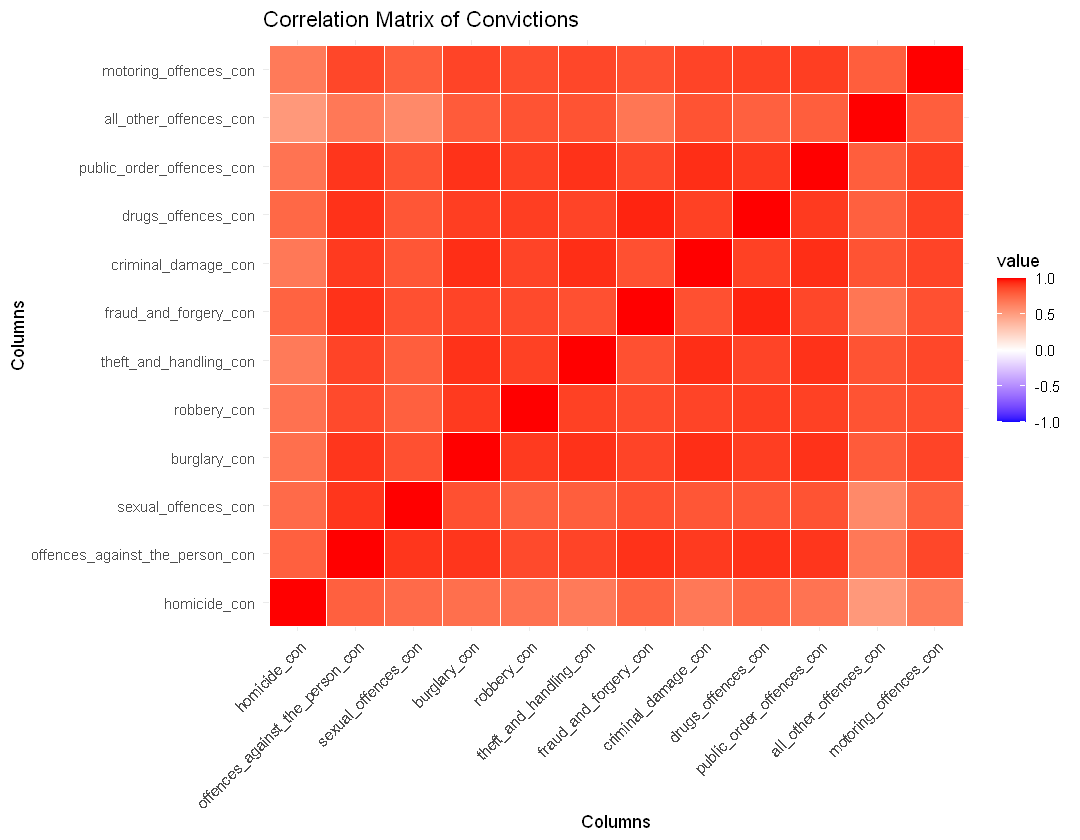

In [55]:
plot_correlation_heatmap(corr_matrix_convictions, "Convictions")

#### Unsuccessful correlation

In [56]:
corr_matrix_unsuccessful <- cor(df_unsuccessful[7:18], method = "pearson")
corr_matrix_unsuccessful <- round(corr_matrix_unsuccessful, 2)

corr_matrix_unsuccessful

,homicide_uns,offences_against_the_person_uns,sexual_offences_uns,burglary_uns,robbery_uns,theft_and_handling_uns,fraud_and_forgery_uns,criminal_damage_uns,drugs_offences_uns,public_order_offences_uns,all_other_offences_uns,motoring_offences_uns
homicide_uns,1.00,0.71,0.64,0.62,0.60,0.66,0.71,0.65,0.70,0.68,0.47,0.66
offences_against_the_person_uns,0.71,1.00,0.88,0.91,0.85,0.94,0.92,0.91,0.95,0.95,0.72,0.94
sexual_offences_uns,0.64,0.88,1.00,0.80,0.76,0.81,0.82,0.80,0.84,0.84,0.63,0.84
burglary_uns,0.62,0.91,0.80,1.00,0.86,0.90,0.83,0.86,0.87,0.89,0.77,0.88
robbery_uns,0.60,0.85,0.76,0.86,1.00,0.85,0.79,0.79,0.82,0.83,0.79,0.86
theft_and_handling_uns,0.66,0.94,0.81,0.90,0.85,1.00,0.88,0.91,0.92,0.94,0.77,0.89
fraud_and_forgery_uns,0.71,0.92,0.82,0.83,0.79,0.88,1.00,0.84,0.91,0.89,0.64,0.87
criminal_damage_uns,0.65,0.91,0.80,0.86,0.79,0.91,0.84,1.00,0.87,0.90,0.74,0.85
drugs_offences_uns,0.70,0.95,0.84,0.87,0.82,0.92,0.91,0.87,1.00,0.93,0.68,0.90
public_order_offences_uns,0.68,0.95,0.84,0.89,0.83,0.94,0.89,0.90,0.93,1.00,0.71,0.90


plot correlation heatmap

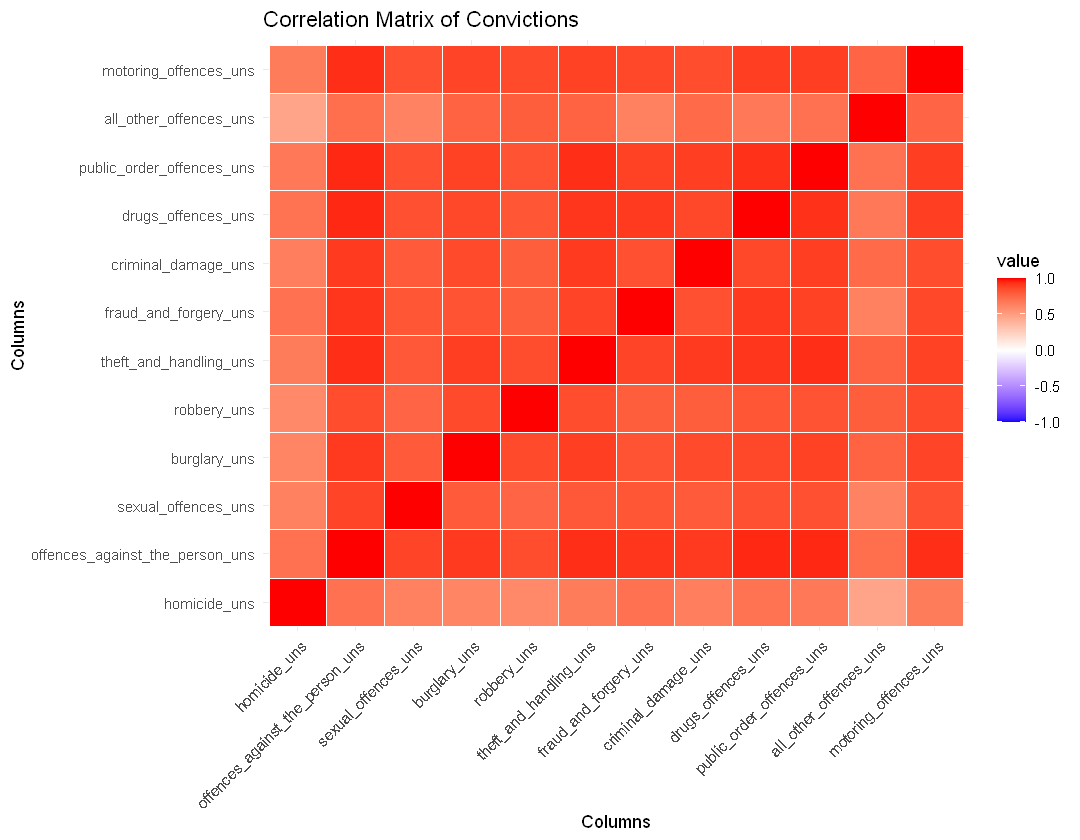

In [57]:
plot_correlation_heatmap(corr_matrix_unsuccessful, "Convictions")

### Identify Highly Correlated Variable pairs for convicted data
#### define function to find highly correlated pairs based on given threshold

In [58]:
# Function to find highly correlated variable pairs

find_highly_correlated_pairs <- function(corr_matrix, correlation_threshold) {
  
  # Convert the correlation matrix to a data frame for easier manipulation
  corr_df <- as.data.frame(corr_matrix)
  
  # Find highly correlated variable pairs
  highly_correlated_pairs <- corr_df %>%
    as_tibble(rownames = "Variable1") %>%
    gather(Variable2, Correlation, -Variable1) %>%
    filter(abs(Correlation) >= correlation_threshold, Variable1 != Variable2) %>%
    mutate(VariablePair = paste(pmin(Variable1, Variable2), pmax(Variable1, Variable2), sep = " and ")) %>%
    distinct(VariablePair, .keep_all = TRUE) %>%
    arrange(desc(abs(Correlation)))
  
  return(highly_correlated_pairs)
}



#### define a function to plot a graph of the highly correlated variables

In [59]:

# Function to create network graph from highly correlated pairs
create_network_graph <- function(highly_correlated_pairs, title) {
  # Create a graph object
  graph <- graph.empty()
  
  var1 <- highly_correlated_pairs$Variable1
  var2 <- highly_correlated_pairs$Variable2
  correlation <- highly_correlated_pairs$Correlation
  
  # Extract unique variable names from highly correlated pairs
  vars <- unique(c(var1, var2))
  
  # Add nodes to the graph
  graph <- add_vertices(graph, length(vars))
  V(graph)$name <- vars
  
  # Convert correlation values to numeric
  correlation <- as.numeric(correlation)
  
  # Add edges for highly correlated pairs
  for (i in seq_along(var1)) {
    var1_name <- var1[i]
    var2_name <- var2[i]
    corr <- correlation[i]
    
    # Get the vertex indices for the variables
    var1_index <- which(vars == var1_name)
    var2_index <- which(vars == var2_name)
    
    # Add an edge between var1 and var2 with the correlation as the edge attribute
    graph <- add_edges(graph, c(var1_index, var2_index))
    E(graph)$correlation <- corr
  }
  
  # Set visual attributes for the graph
  layout <- layout_with_fr(graph)  # Layout algorithm for node positioning
  
  # Plot the graph
  plot(graph, layout = layout, vertex.label = V(graph)$name, vertex.size = 10, vertex.color = "lightblue",
       edge.width = E(graph)$correlation * 3, edge.arrow.size = 0.5,
       main = title)
}


#### at threshold = 0.9

Variable1,Variable2,Correlation,VariablePair
<chr>,<chr>,<dbl>,<chr>
drugs_offences_con,fraud_and_forgery_con,0.96,drugs_offences_con and fraud_and_forgery_con
criminal_damage_con,burglary_con,0.94,burglary_con and criminal_damage_con
criminal_damage_con,theft_and_handling_con,0.94,criminal_damage_con and theft_and_handling_con
public_order_offences_con,criminal_damage_con,0.94,criminal_damage_con and public_order_offences_con
fraud_and_forgery_con,offences_against_the_person_con,0.93,fraud_and_forgery_con and offences_against_the_person_con
drugs_offences_con,offences_against_the_person_con,0.93,drugs_offences_con and offences_against_the_person_con
theft_and_handling_con,burglary_con,0.93,burglary_con and theft_and_handling_con
public_order_offences_con,burglary_con,0.93,burglary_con and public_order_offences_con
public_order_offences_con,theft_and_handling_con,0.93,public_order_offences_con and theft_and_handling_con


[1] "Highly Correlated Variable Pairs Network Graph - Convictions"


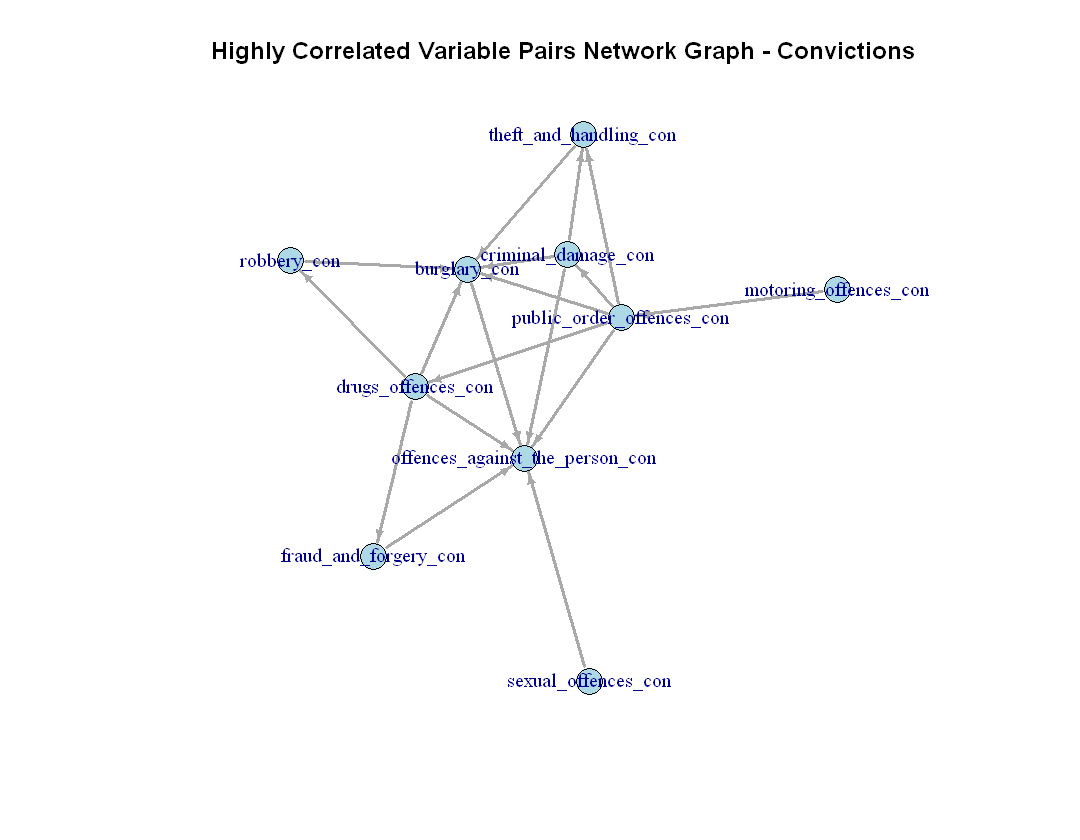

In [60]:

# Set threshold = 0.9 for convictions correlation matrix
correlation_threshold <- 0.9

# Find highly correlated variable pairs for convictions correlation matrix
highly_correlated_pairs_convictions <- find_highly_correlated_pairs(corr_matrix_convictions, correlation_threshold)
highly_correlated_pairs_convictions

# visualise the network graph
print("Highly Correlated Variable Pairs Network Graph - Convictions")
create_network_graph(highly_correlated_pairs_convictions, "Highly Correlated Variable Pairs Network Graph - Convictions")



All_other_offences and Homicide_offences are not present among the highly correlated variable pairs as defined by our threshold 0.9

hence they are not represented in the network graph

#### at threshold = 0.8

Variable1,Variable2,Correlation,VariablePair
<chr>,<chr>,<dbl>,<chr>
drugs_offences_con,fraud_and_forgery_con,0.96,drugs_offences_con and fraud_and_forgery_con
criminal_damage_con,burglary_con,0.94,burglary_con and criminal_damage_con
criminal_damage_con,theft_and_handling_con,0.94,criminal_damage_con and theft_and_handling_con
public_order_offences_con,criminal_damage_con,0.94,criminal_damage_con and public_order_offences_con
fraud_and_forgery_con,offences_against_the_person_con,0.93,fraud_and_forgery_con and offences_against_the_person_con
drugs_offences_con,offences_against_the_person_con,0.93,drugs_offences_con and offences_against_the_person_con
theft_and_handling_con,burglary_con,0.93,burglary_con and theft_and_handling_con
public_order_offences_con,burglary_con,0.93,burglary_con and public_order_offences_con
public_order_offences_con,theft_and_handling_con,0.93,public_order_offences_con and theft_and_handling_con


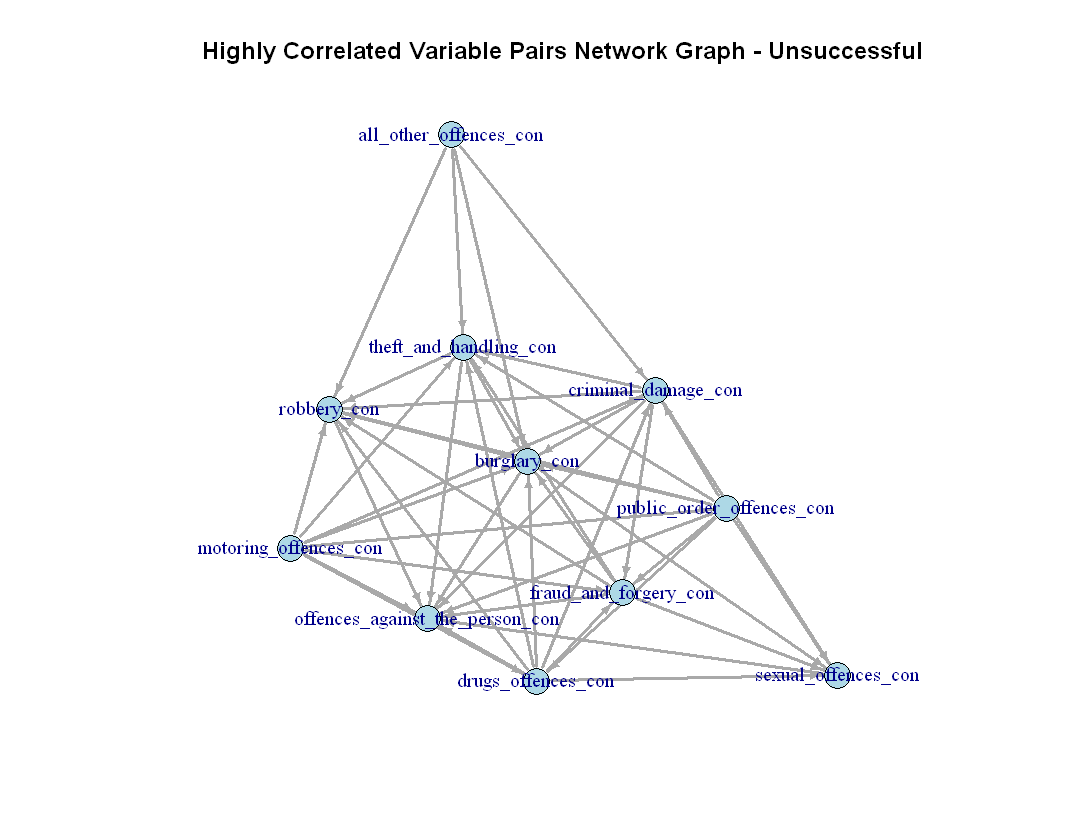

In [61]:

# Set threshold = 0.8 for unsuccessful correlation matrix
correlation_threshold <- 0.80

# Find highly correlated variable pairs at the given threshold
highly_correlated_pairs <- find_highly_correlated_pairs(corr_matrix_convictions, correlation_threshold)
highly_correlated_pairs

# Visualise the network graph
create_network_graph(highly_correlated_pairs, "Highly Correlated Variable Pairs Network Graph - Unsuccessful")


when threshold is reduced to 0.8 we see 

### **TEST**

In [62]:
cor_test <- cor.test(df_convictions$drugs_offences_con, df_convictions$fraud_and_forgery_con)
cor_test

cor_test <- cor.test(df_convictions$criminal_damage_con, df_convictions$burglary_con)
cor_test


	Pearson's product-moment correlation

data:  df_convictions$drugs_offences_con and df_convictions$fraud_and_forgery_con
t = 151.86, df = 2098, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9536816 0.9608270
sample estimates:
      cor 
0.9574006 



	Pearson's product-moment correlation

data:  df_convictions$criminal_damage_con and df_convictions$burglary_con
t = 127.14, df = 2098, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9356869 0.9455309
sample estimates:
     cor 
0.940807 


----

## CRIME PROSECUTION RATES


#### **QUESTION 1:** How does the rate of convictions and unsuccessful outcomes differ for different principal offence categories?

Steps:
Using the monthly prosecution dataset;
- Find the total convictions for each Principal offence Category for each year
- Find the total unsuccessful outcomes for each Principal offence Category for each year
- Find the total number of prosecuted cases for each Principal offence Category for each year
- Find the rate of convictions for each Principal offence Category for each year
- Find the rate of unsuccessful outcomes for each Principal offence Category for each year


#### **HYPOTHESIS 1:** The distribution of convictions and unsuccessful outcomes varies significantly across principal offence categories.
- **Null hypothesis:** There is no significant difference in the proportions of convictions and unsuccessful outcomes among the principal offence categories.
- **Alternative hypothesis:** The proportions of convictions and unsuccessful outcomes differ significantly among the principal offence categories.


The hypothesis will be tested separately for each year's analysis. By doing so, we can determine if there are significant differences in the proportions between the years, indicating temporal changes in the outcomes, which will then be analysed and visualised. This analysis can help identify trends, fluctuations, or patterns in conviction rates and unsuccessful outcomes over time.


In [63]:
head(df_monthly_convictions)

,county_areas,region,date,month,year,quarter,homicide_con,offences_against_the_person_con,sexual_offences_con,burglary_con,robbery_con,theft_and_handling_con,fraud_and_forgery_con,criminal_damage_con,drugs_offences_con,public_order_offences_con,all_other_offences_con,motoring_offences_con
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,National,All Regions,2014-01-01,Jan,2014,Q1_2014,51,9087,736,1715,522,11057,846,2693,4988,4752,3291,12945
2,National,All Regions,2014-02-01,Feb,2014,Q1_2014,61,8366,712,1549,541,10150,758,2455,4565,3787,3208,12078
3,National,All Regions,2014-03-01,Mar,2014,Q1_2014,57,8595,731,1618,569,10716,814,2413,4649,3920,2994,11155
4,National,All Regions,2014-04-01,Apr,2014,Q2_2014,81,7805,698,1470,517,10045,666,2259,4536,3549,2640,8283
5,National,All Regions,2014-05-01,May,2014,Q2_2014,69,8178,721,1562,532,10146,754,2403,4510,4022,2753,8615
6,National,All Regions,2014-06-01,Jun,2014,Q2_2014,61,8444,778,1467,512,9938,708,2466,4563,4023,2743,8407


##### get column names for extraction

In [64]:
column_names <- colnames(df_monthly_convictions)

column_indices <- seq_along(column_names)

for (i in column_indices) {
  print(paste(i, column_names[i]))
}

[1] "1 county_areas"
[1] "2 region"
[1] "3 date"
[1] "4 month"
[1] "5 year"
[1] "6 quarter"
[1] "7 homicide_con"
[1] "8 offences_against_the_person_con"
[1] "9 sexual_offences_con"
[1] "10 burglary_con"
[1] "11 robbery_con"
[1] "12 theft_and_handling_con"
[1] "13 fraud_and_forgery_con"
[1] "14 criminal_damage_con"
[1] "15 drugs_offences_con"
[1] "16 public_order_offences_con"
[1] "17 all_other_offences_con"
[1] "18 motoring_offences_con"


#### extract principal offence categories for further analysis

In [65]:
# Extract the columns related to convictions
principal_offence_categories <- colnames(df_monthly_convictions)[7:18]
principal_offence_categories <- substr(principal_offence_categories, 1, nchar(principal_offence_categories) - 4)

principal_offence_categories

[1] "homicide"                    "offences_against_the_person"
 [3] "sexual_offences"             "burglary"                   
 [5] "robbery"                     "theft_and_handling"         
 [7] "fraud_and_forgery"           "criminal_damage"            
 [9] "drugs_offences"              "public_order_offences"      
[11] "all_other_offences"          "motoring_offences"

##### get unique years of dataset

In [66]:
unique_years <- unique(df$year)
unique_years

[1] 2014 2015 2016 2017 2018

#### Define function to process and compute aggregate prosecution data for each principal offence category in each year.

Aggregated data will  the following values for each principal offence category:
- sum of convictions counts
- sum of unsuccessful counts
- total prosecuted count (conviction count + unsuccessful count)
- conviction rate
- unsuccessful rate

In [67]:
compute_yearly_data <- function(year, category_names, convictions_data, unsuccessful_data) {
  # Filter the convictions data for the given year
  filtered_convictions_data <- convictions_data[convictions_data$year == year, ]
  
  # Filter the unsuccessful prosecutions data for the given year
  filtered_unsuccessful_data <- unsuccessful_data[unsuccessful_data$year == year, ]
  
  # Compute total convictions
  no_of_convictions <- colSums(filtered_convictions_data[, 7:18])
  
  # Compute total unsuccessful prosecutions
  no_of_unsuccessful <- colSums(filtered_unsuccessful_data[, 7:18])
  
  # Compute total prosecutions
  total_prosecutions <- no_of_convictions + no_of_unsuccessful

  # compute conviction rate
  conviction_rate <- round(no_of_convictions / total_prosecutions * 100, 2)

  # compute unsuccessful rate
  unsuccessful_rate <- round(no_of_unsuccessful / total_prosecutions * 100, 2)
  
  # Create the data frame for the bar chart
  yearly_prosecutions_df <- data.frame(
    principal_offence_category = category_names,
    no_of_convictions = no_of_convictions,
    no_of_unsuccessful = no_of_unsuccessful,
    no_of_prosecutions = total_prosecutions,
    conviction_rate = conviction_rate,
    unsuccessful_rate = unsuccessful_rate,
    row.names = NULL
  )
  
 
  return(yearly_prosecutions_df)
}



#### define function to execute the above function for each year

In [68]:
# 
execute_all_yearly_data <- function(unique_years, category_names, conviction_data, unsuccessful_data) {

  # Create an empty list to store the data frames
  yearly_df_list <- list()

  # Loop through all the quarters
  for (year in unique_years) {

    # compute the data for the given quarter using the compute_quarterly_data function
    yearly_prosecutions_df <- compute_yearly_data(year, category_names, conviction_data, unsuccessful_data)

    # Append the data frame to the list
    yearly_df_list[[paste0("prosecutions_", year)]] <- yearly_prosecutions_df

  }


  # Return the list
  return(yearly_df_list)

}

#### Execute the function to get the yearly data for all the quarters ####

In [69]:
# Call the function to process all the quarters and store the list of data frames in a variable
yearly_df_list <- execute_all_yearly_data(unique_years, principal_offence_categories, df_monthly_convictions, df_monthly_unsuccessful)

# print the list
# yearly_df_list


#### Define functions to generate graphs for visualisation for each years data
- conviction count bar chart
- unsuccessful count bar chart
- Total case prosecution bar chart (convition count + unsuccessful count)
- prosecution rate stacked bar chart (conviction vs unsuccessful)

In [70]:
# Generic function to generate a bar chart for the given data and title
generate_bar_chart <- function(df, x_var, y_var, fill_var, x_label, y_label, chart_title) {
  ggplot(df, aes(x = reorder({{x_var}}, {{y_var}}), y = {{y_var}}, fill = {{fill_var}})) +
    geom_bar(stat = "identity") +
    labs(x = x_label, 
        y = y_label, 
        title = chart_title) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
          legend.position = "none",
          plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
          axis.title.x = element_text(size = 12, margin = margin(t = 10)),
          axis.title.y = element_text(size = 12, margin = margin(r = 10)),
          axis.text = element_text(size = 10),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.border = element_blank())
}

# Function to generate the conviction data bar chart for the given year
conviction_bar_chart <- function(df, year) {
  chart_title <- paste("Total Convictions by Principal Offence Category in", year)
  generate_bar_chart(df, principal_offence_category, no_of_convictions, principal_offence_category,
                     "Principal Offence Category", "Total Convictions", chart_title)
}

# Function to generate the unsuccessful data bar chart for the given year
unsuccessful_bar_chart <- function(df, year) {
  chart_title <- paste("Total Unsuccessful Prosecutions by Principal Offence Category in", year)
  generate_bar_chart(df, principal_offence_category, no_of_unsuccessful, principal_offence_category,
                     "Principal Offence Category", "Total Unsuccessful Prosecutions", chart_title)
}

# Function to generate the prosecution data bar chart for the given year
prosecution_bar_chart <- function(df, year) {
  chart_title <- paste("Total Prosecutions by Principal Offence Category in", year)
  generate_bar_chart(df, principal_offence_category, no_of_prosecutions, principal_offence_category,
                     "Principal Offence Category", "Total Prosecutions", chart_title)
}

# Function to generate stacked bar chart for the prosecution rate comparison  for the given year
prosecution_rate_bar_chart <- function(df, year) {
  # Create the bar chart using ggplot2
  ggplot(df, aes(x =  reorder(principal_offence_category, conviction_rate))) +
    geom_bar(aes(y = conviction_rate, fill = "Conviction Rate"), stat = "identity", width = 0.4) +
    geom_bar(aes(y = unsuccessful_rate, fill = "Unsuccessful Rate"), stat = "identity", width = 0.4) +
    labs(x = "Principal Offence Category",
         y = "Rate (%)",
         title = paste("Conviction Rate by Principal Offence Category in", year)) +
    scale_fill_manual(values = c("Conviction Rate" = "#0d48bec8", "Unsuccessful Rate" = "#ff0000a0")) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
    legend.position = "none",
          plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
          axis.title.x = element_text(size = 12, margin = margin(t = 10)),
          axis.title.y = element_text(size = 12, margin = margin(r = 10)),
          axis.text = element_text(size = 10),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.border = element_blank())
}


## year 2014
- compute data frame for the year 2014

In [71]:
prosecutions_2014 <- yearly_df_list$prosecutions_2014
prosecutions_2014

principal_offence_category,no_of_convictions,no_of_unsuccessful,no_of_prosecutions,conviction_rate,unsuccessful_rate
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
homicide,731,188,919,79.54,20.46
offences_against_the_person,105123,35858,140981,74.57,25.43
sexual_offences,9354,3829,13183,70.96,29.04
burglary,18574,3255,21829,85.09,14.91
robbery,6456,1770,8226,78.48,21.52
theft_and_handling,121081,11456,132537,91.36,8.64
fraud_and_forgery,8893,1443,10336,86.04,13.96
criminal_damage,29242,5142,34384,85.05,14.95
drugs_offences,54210,3594,57804,93.78,6.22


#### convictions

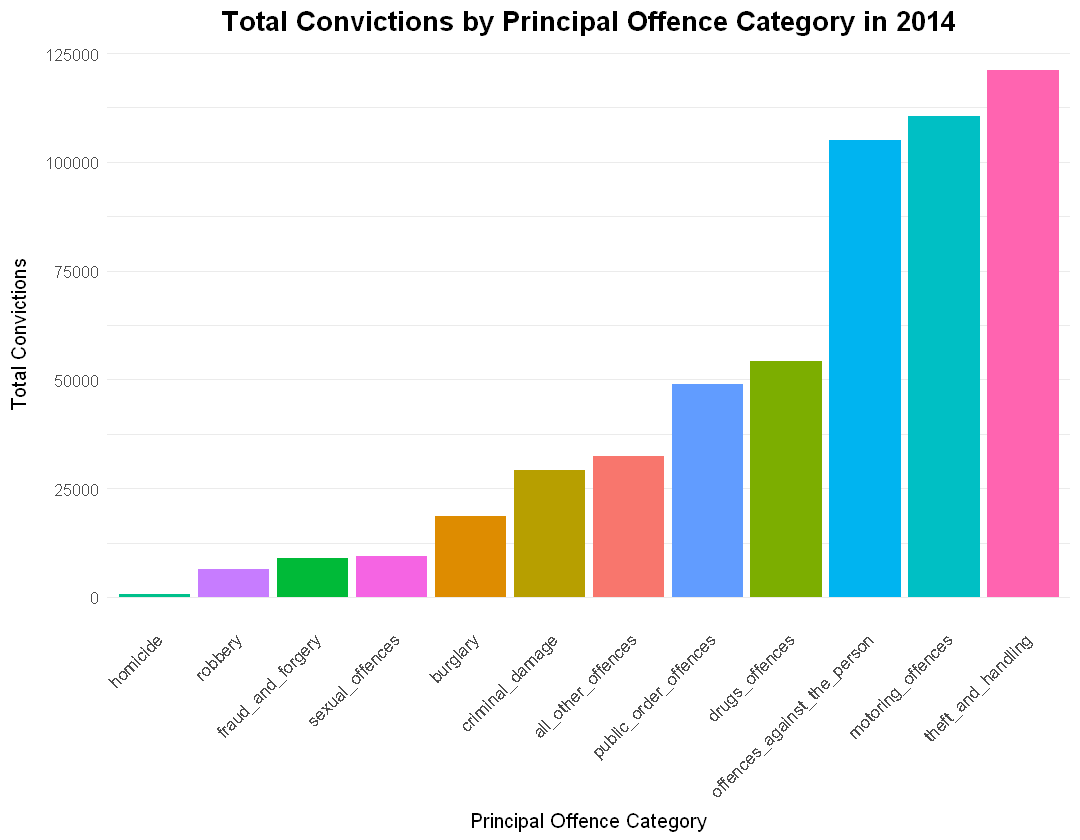

In [72]:
conviction_bar_chart(prosecutions_2014, 2014)

#### unsuccessful prosecutions

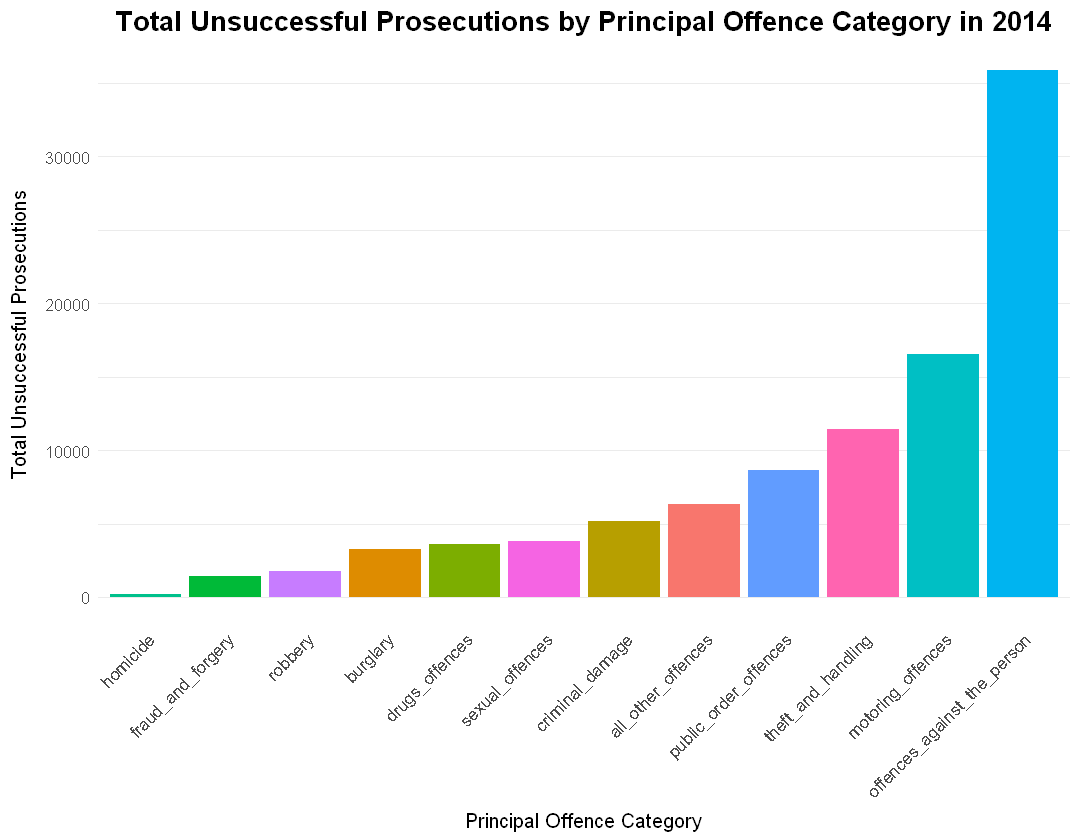

In [73]:
unsuccessful_bar_chart(prosecutions_2014, 2014)

#### total prosecuted cases

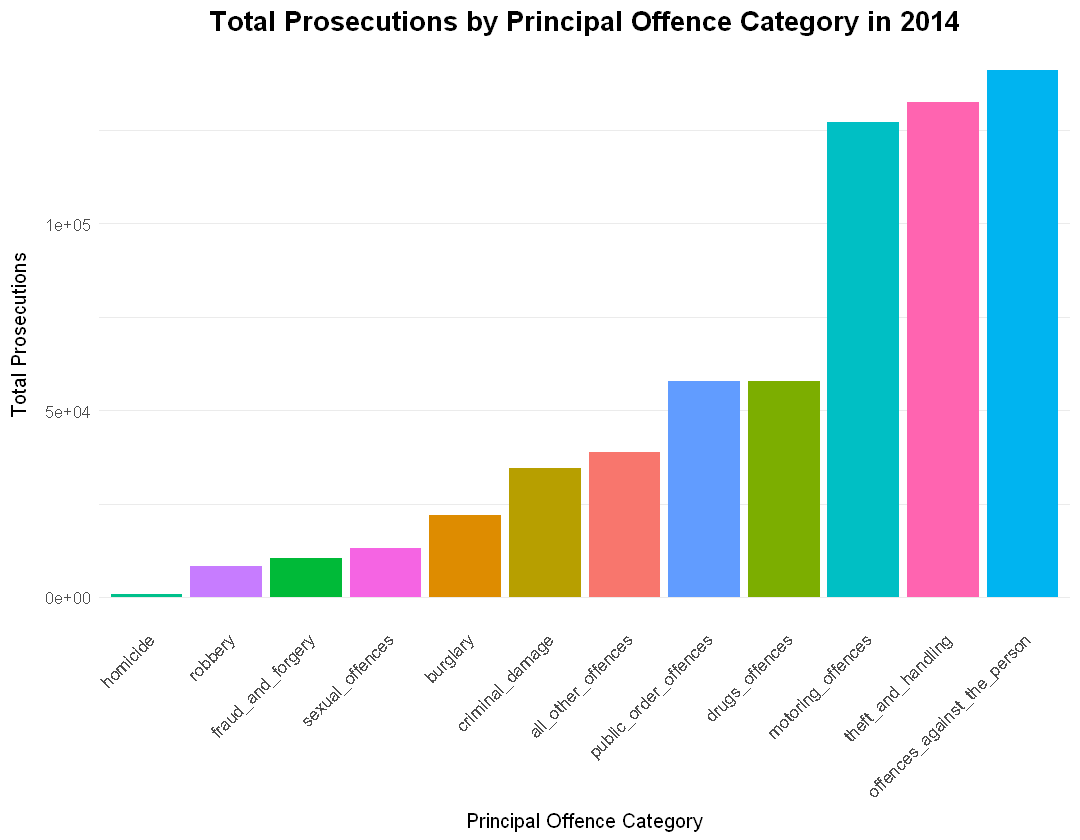

In [74]:
prosecution_bar_chart(prosecutions_2014, 2014)

#### prosecution conviction rate

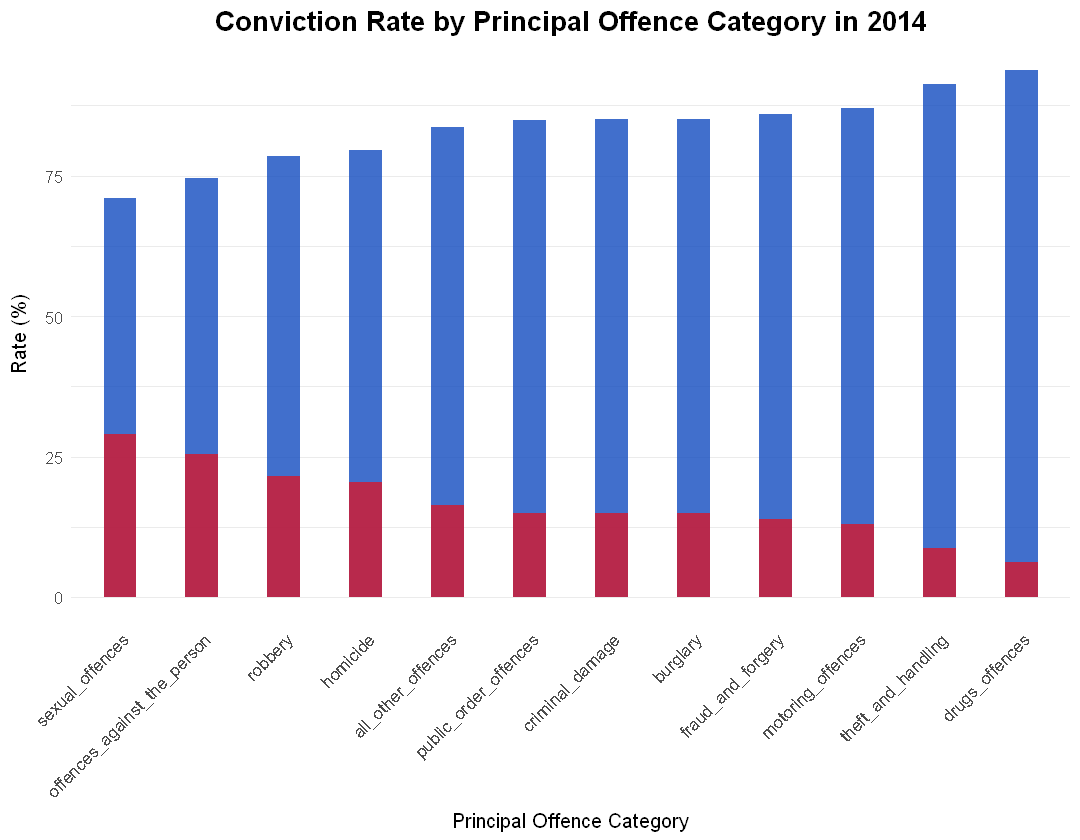

In [75]:
prosecution_rate_bar_chart(prosecutions_2014, 2014)

From the provided breakdown of conviction rates for different offence categories in 2014, we can draw several insights:

Homicide: The offence category "homicide_con" had a relatively high conviction rate of approximately 80.68%. This suggests that a significant proportion of homicide cases resulted in convictions.

Offences against the person: This category, which includes crimes such as assault and harassment, had a conviction rate of around 77.03%. While still relatively high, it is slightly lower than the overall conviction rate for homicides.

Sexual offences: The conviction rate for sexual offences was approximately 72.98%. This indicates that sexual offence cases had a comparatively lower likelihood of resulting in convictions.

Theft and handling: The category of "theft_and_handling_con" had a relatively high conviction rate of approximately 91.76%. This suggests that a large portion of theft and handling cases led to successful prosecutions.

Drugs offences: The conviction rate for drugs offences was approximately 93.69%. This indicates a relatively high success rate in prosecuting cases related to drug offenses.

Motoring offences: Motoring offences had a conviction rate of around 85.71%. This suggests that a significant proportion of motoring offences resulted in convictions.

Other offence categories: The remaining offence categories, including burglary, robbery, fraud and forgery, criminal damage, public order offences, and all other offences excluding motoring, had conviction rates ranging from approximately 84.35% to 86.08%. These categories generally had relatively high conviction rates.

These insights provide an understanding of the variation in conviction rates across different offence categories in 2014. They can be further analyzed and compared to identify patterns, trends, or areas of concern within the criminal justice system. Additionally, visualizations such as bar charts or line plots can help convey these insights more effectively.

#### Hypothesis Testing 2014
- Pearson's chi-squared test

In [76]:

# Perform the chi-square test of independence
contingency_table <- prosecutions_2014[, c(5, 6)]

# Print the contingency table
contingency_table

# Perform the chi-square test of independence
result <- chisq.test(contingency_table)

# Extract the test statistic and p-value from the test result
test_statistic <- result$statistic
p_value <- result$p.value


# Print the results
print(result)
cat("\n")
cat("Test statistic:", test_statistic, "\n")
cat("p-value:", p_value, "\n")


# Check if the null hypothesis can be rejected based on the significance level (e.g., 0.05)
if (p_value < 0.05) {
  cat("\n")
  cat("There is a significant difference in the proportions of convictions and unsuccessful outcomes.\n")
} else {
  cat("\n")
  cat("There is no significant difference in the proportions of convictions and unsuccessful outcomes.\n")
}


conviction_rate,unsuccessful_rate
<dbl>,<dbl>
79.54,20.46
74.57,25.43
70.96,29.04
85.09,14.91
78.48,21.52
91.36,8.64
86.04,13.96
85.05,14.95
93.78,6.22



	Pearson's Chi-squared test

data:  contingency_table
X-squared = 33.985, df = 11, p-value = 0.0003638


Test statistic: 33.98492 
p-value: 0.0003637505 

There is a significant difference in the proportions of convictions and unsuccessful outcomes.



Based on the provided contingency table and the result of the Pearson's chi-squared test, the p-value is 0.003557.

Since the p-value is less than the chosen significance level (e.g., 0.05), we reject the null hypothesis. This indicates that there is sufficient evidence to suggest that the distribution of convictions and unsuccessful outcomes varies significantly across principal offence categories.

In other words, the analysis suggests that there is a significant association between the principal offence categories and the distribution of convictions and unsuccessful outcomes in CPS proceedings.


## year 2015
- compute data for 2015

In [77]:
prosecutions_2015 <- yearly_df_list$prosecutions_2015

prosecutions_2015

principal_offence_category,no_of_convictions,no_of_unsuccessful,no_of_prosecutions,conviction_rate,unsuccessful_rate
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
homicide,763,182,945,80.74,19.26
offences_against_the_person,111847,35736,147583,75.79,24.21
sexual_offences,10102,3914,14016,72.07,27.93
burglary,15299,2794,18093,84.56,15.44
robbery,4882,1342,6224,78.44,21.56
theft_and_handling,99719,9168,108887,91.58,8.42
fraud_and_forgery,8726,1549,10275,84.92,15.08
criminal_damage,25680,4520,30200,85.03,14.97
drugs_offences,46044,3085,49129,93.72,6.28


#### convictions 

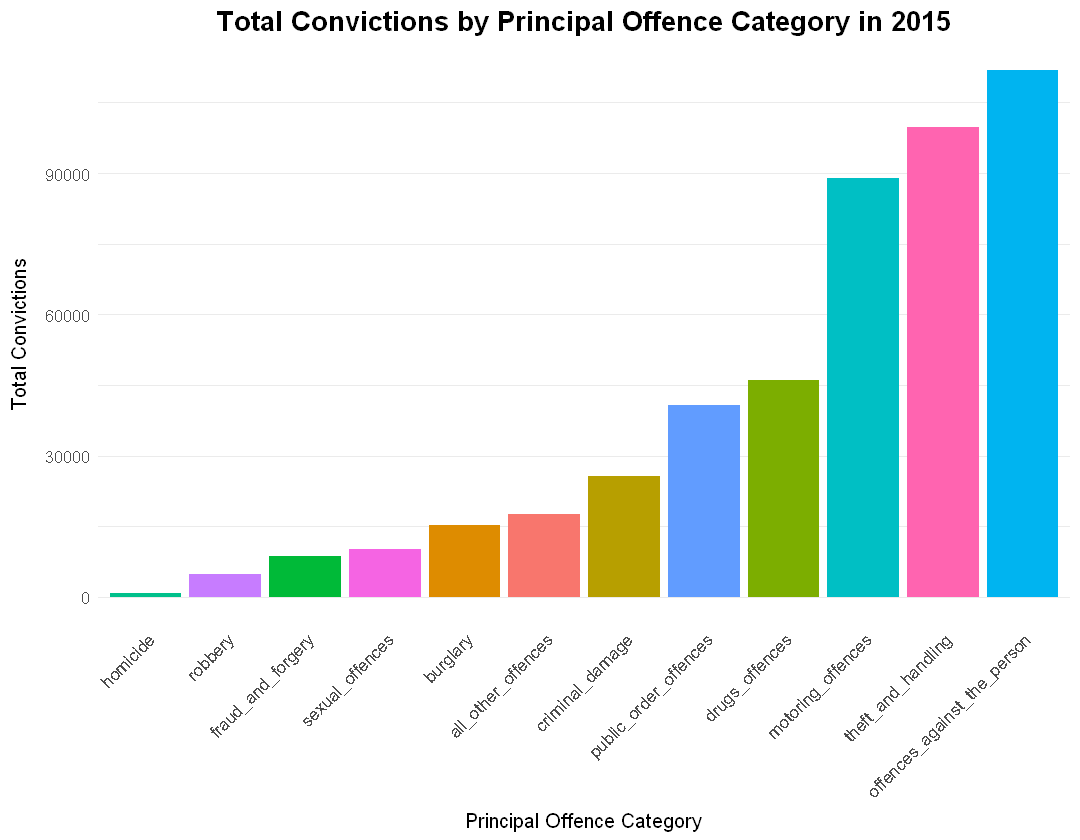

In [78]:

conviction_bar_chart(prosecutions_2015, 2015)

#### unsuccessful prosecutions

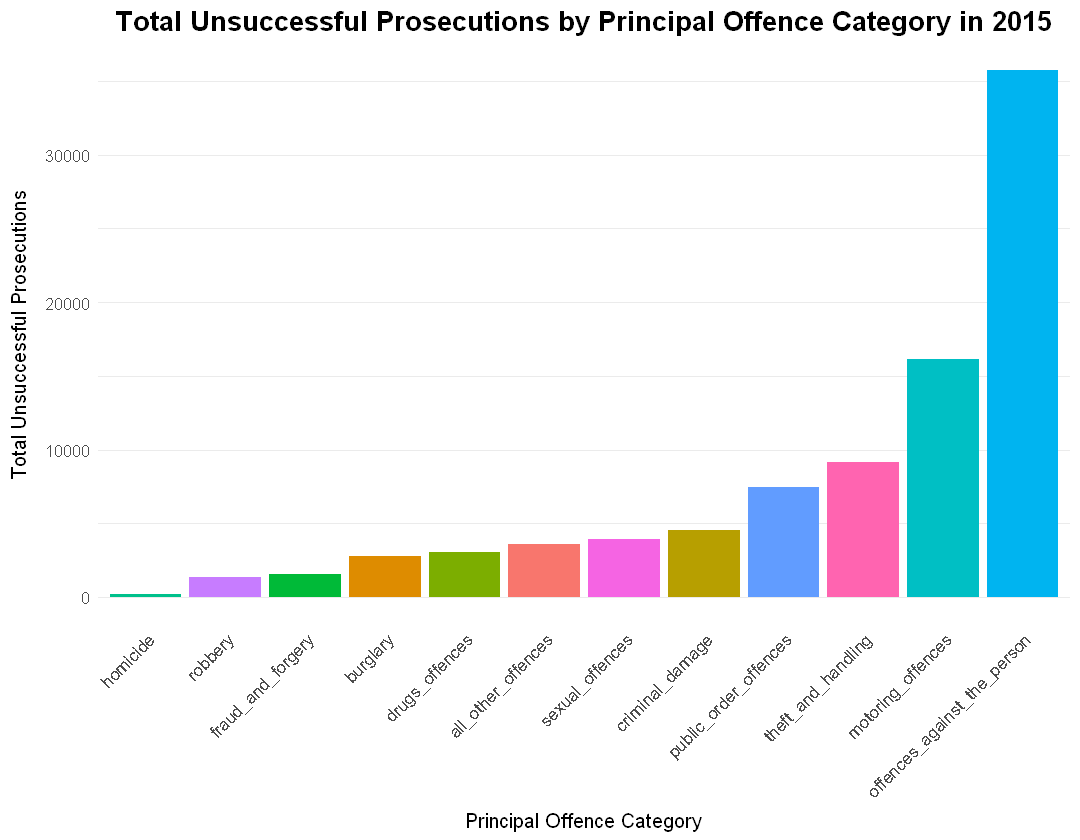

In [79]:
unsuccessful_bar_chart(prosecutions_2015, 2015)

#### total prosecuted cases

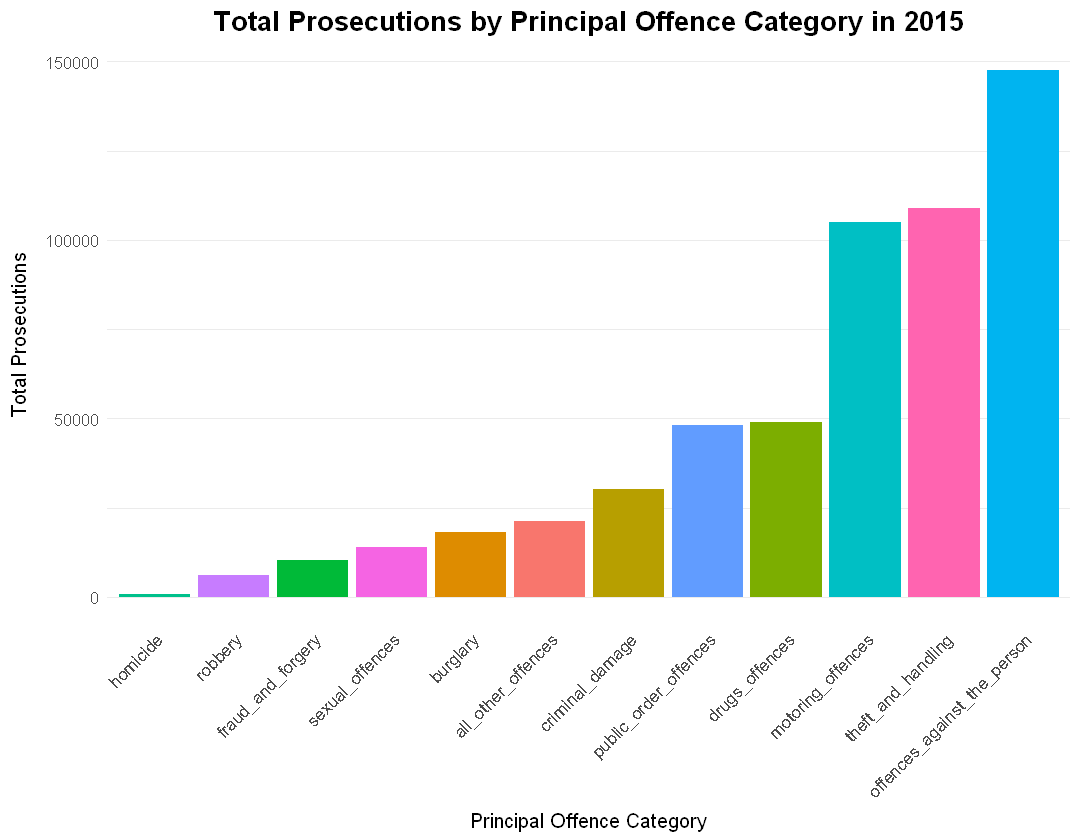

In [80]:
prosecution_bar_chart(prosecutions_2015, 2015)

#### prosecution conviction rate

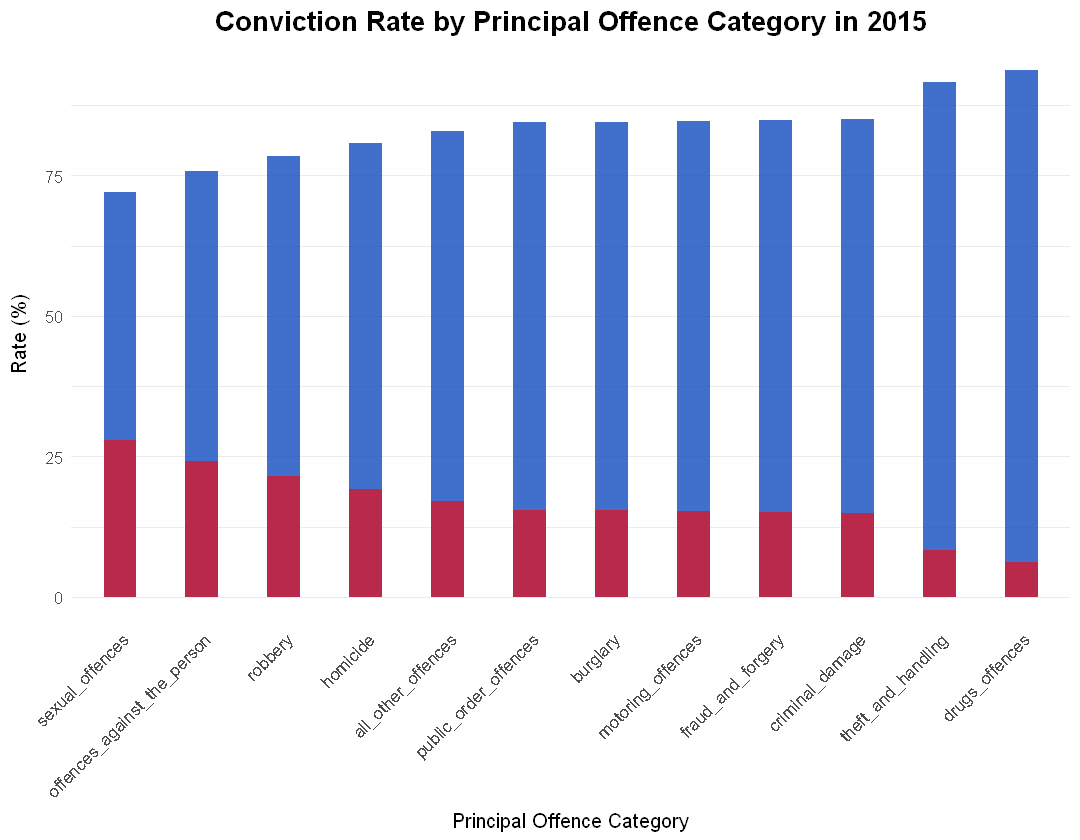

In [81]:
prosecution_rate_bar_chart(prosecutions_2015, 2015)

#### Hypothesis Testing 2015
- Pearson's chi-squared test

In [82]:
# Perform the chi-square test of independence
contingency_table <- prosecutions_2015[, c(5, 6)]

# Print the contingency table
contingency_table

# Perform the chi-square test of independence
result <- chisq.test(contingency_table)

# Extract the test statistic and p-value from the test result
test_statistic <- result$statistic
p_value <- result$p.value


# Print the results
print(result)
cat("\n")
cat("Test statistic:", test_statistic, "\n")
cat("p-value:", p_value, "\n")


# Check if the null hypothesis can be rejected based on the significance level (e.g., 0.05)
if (p_value < 0.05) {
  cat("\n")
  cat("There is a significant difference in the proportions of convictions and unsuccessful outcomes.\n")
} else {
  cat("\n")
  cat("There is no significant difference in the proportions of convictions and unsuccessful outcomes.\n")
}


conviction_rate,unsuccessful_rate
<dbl>,<dbl>
80.74,19.26
75.79,24.21
72.07,27.93
84.56,15.44
78.44,21.56
91.58,8.42
84.92,15.08
85.03,14.97
93.72,6.28



	Pearson's Chi-squared test

data:  contingency_table
X-squared = 28.722, df = 11, p-value = 0.002507


Test statistic: 28.7215 
p-value: 0.002506994 

There is a significant difference in the proportions of convictions and unsuccessful outcomes.


## year 2016
- compute data for 2016

In [83]:
prosecutions_2016 <- yearly_df_list$prosecutions_2016

prosecutions_2016

principal_offence_category,no_of_convictions,no_of_unsuccessful,no_of_prosecutions,conviction_rate,unsuccessful_rate
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
homicide,999,234,1233,81.02,18.98
offences_against_the_person,106141,29909,136050,78.02,21.98
sexual_offences,10768,3918,14686,73.32,26.68
burglary,11968,2105,14073,85.04,14.96
robbery,3603,953,4556,79.08,20.92
theft_and_handling,74723,6503,81226,91.99,8.01
fraud_and_forgery,9215,1492,10707,86.07,13.93
criminal_damage,19179,3501,22680,84.56,15.44
drugs_offences,40597,2722,43319,93.72,6.28


#### convictions

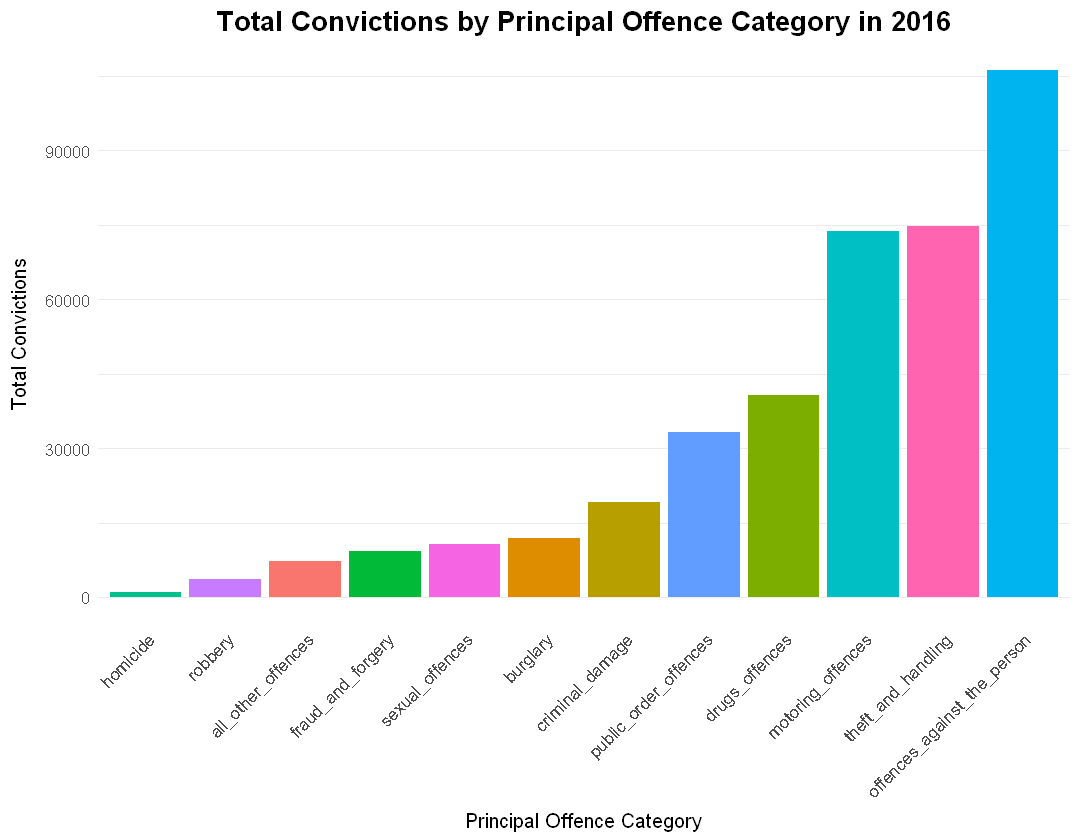

In [84]:
conviction_bar_chart(prosecutions_2016, 2016)

#### unsuccessful prosecutions

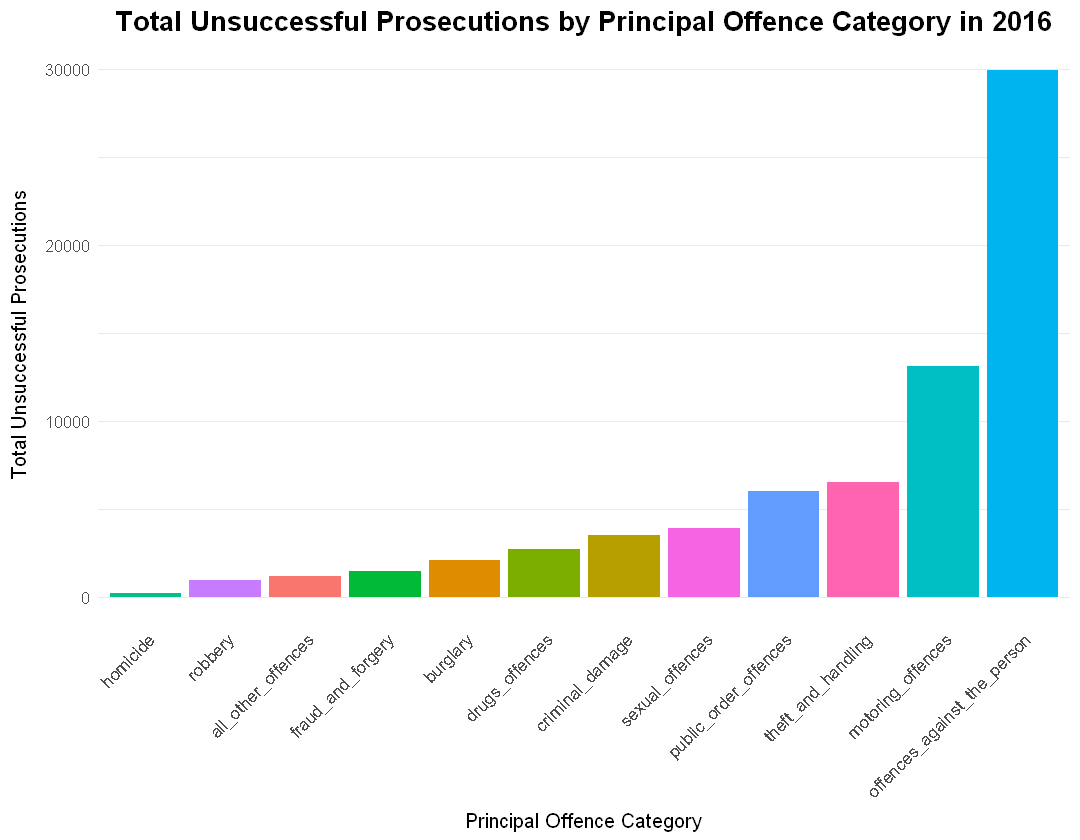

In [85]:
unsuccessful_bar_chart(prosecutions_2016, 2016)

#### total prosecuted cases


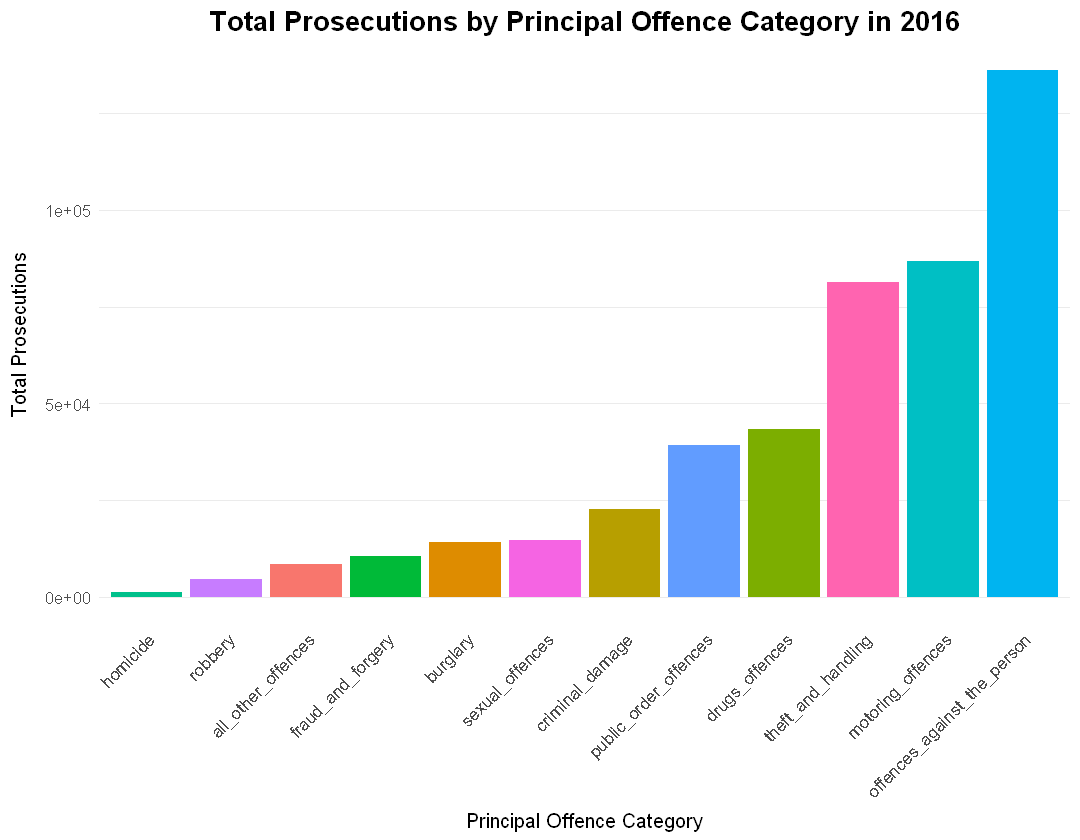

In [86]:
prosecution_bar_chart(prosecutions_2016, 2016)

#### prosecution conviction rate


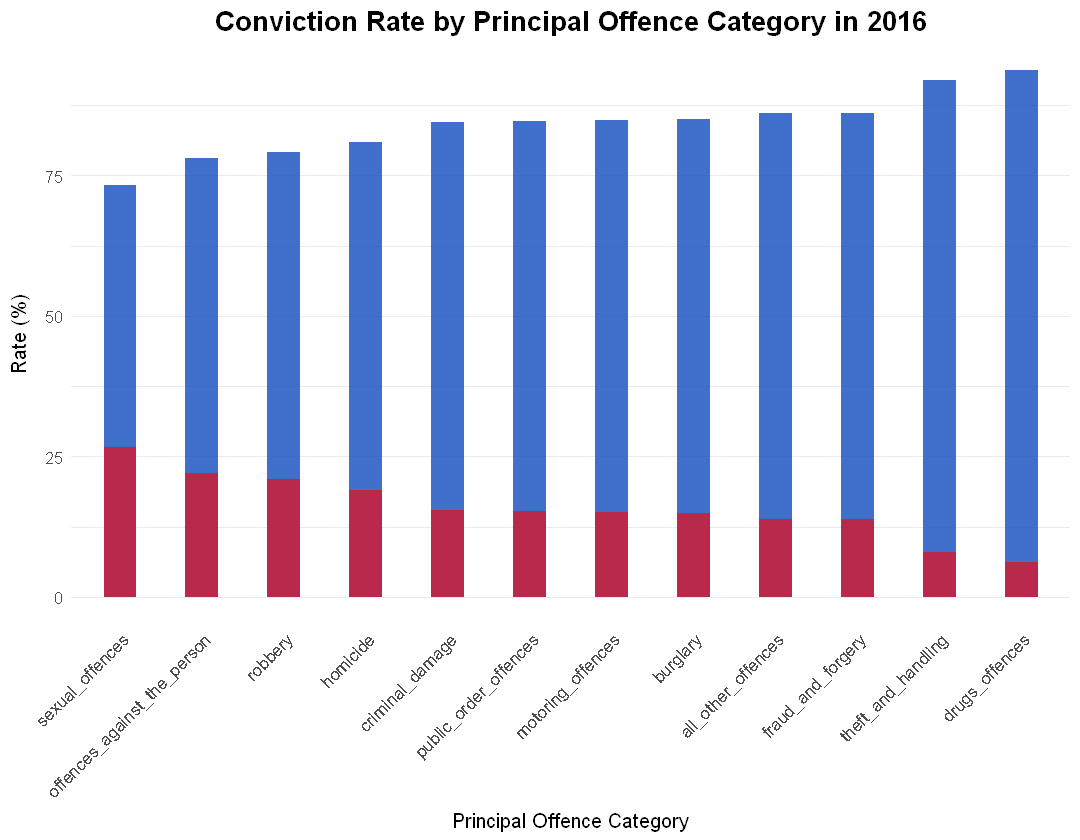

In [87]:
prosecution_rate_bar_chart(prosecutions_2016, 2016)

#### Hypothesis Testing 2016
- Pearson's chi-squared test

In [88]:
# Perform the chi-square test of independence
contingency_table <- prosecutions_2016[, c(5, 6)]

# Print the contingency table
contingency_table

# Perform the chi-square test of independence
result <- chisq.test(contingency_table)

# Extract the test statistic and p-value from the test result
test_statistic <- result$statistic
p_value <- result$p.value


# Print the results
print(result)
cat("\n")
cat("Test statistic:", test_statistic, "\n")
cat("p-value:", p_value, "\n")


# Check if the null hypothesis can be rejected based on the significance level (e.g., 0.05)
if (p_value < 0.05) {
  cat("\n")
  cat("There is a significant difference in the proportions of convictions and unsuccessful outcomes.\n")
} else {
  cat("\n")
  cat("There is no significant difference in the proportions of convictions and unsuccessful outcomes.\n")
}


conviction_rate,unsuccessful_rate
<dbl>,<dbl>
81.02,18.98
78.02,21.98
73.32,26.68
85.04,14.96
79.08,20.92
91.99,8.01
86.07,13.93
84.56,15.44
93.72,6.28



	Pearson's Chi-squared test

data:  contingency_table
X-squared = 26.261, df = 11, p-value = 0.005933


Test statistic: 26.26142 
p-value: 0.005932839 

There is a significant difference in the proportions of convictions and unsuccessful outcomes.


## year 2017
- compute data for 2017

In [89]:
prosecutions_2017 <- yearly_df_list$prosecutions_2017

prosecutions_2017

principal_offence_category,no_of_convictions,no_of_unsuccessful,no_of_prosecutions,conviction_rate,unsuccessful_rate
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
homicide,826,202,1028,80.35,19.65
offences_against_the_person,89729,24123,113852,78.81,21.19
sexual_offences,9155,3171,12326,74.27,25.73
burglary,10269,1536,11805,86.99,13.01
robbery,3125,823,3948,79.15,20.85
theft_and_handling,59359,4951,64310,92.30,7.70
fraud_and_forgery,7919,1208,9127,86.76,13.24
criminal_damage,15857,2491,18348,86.42,13.58
drugs_offences,32727,2197,34924,93.71,6.29


#### convictions

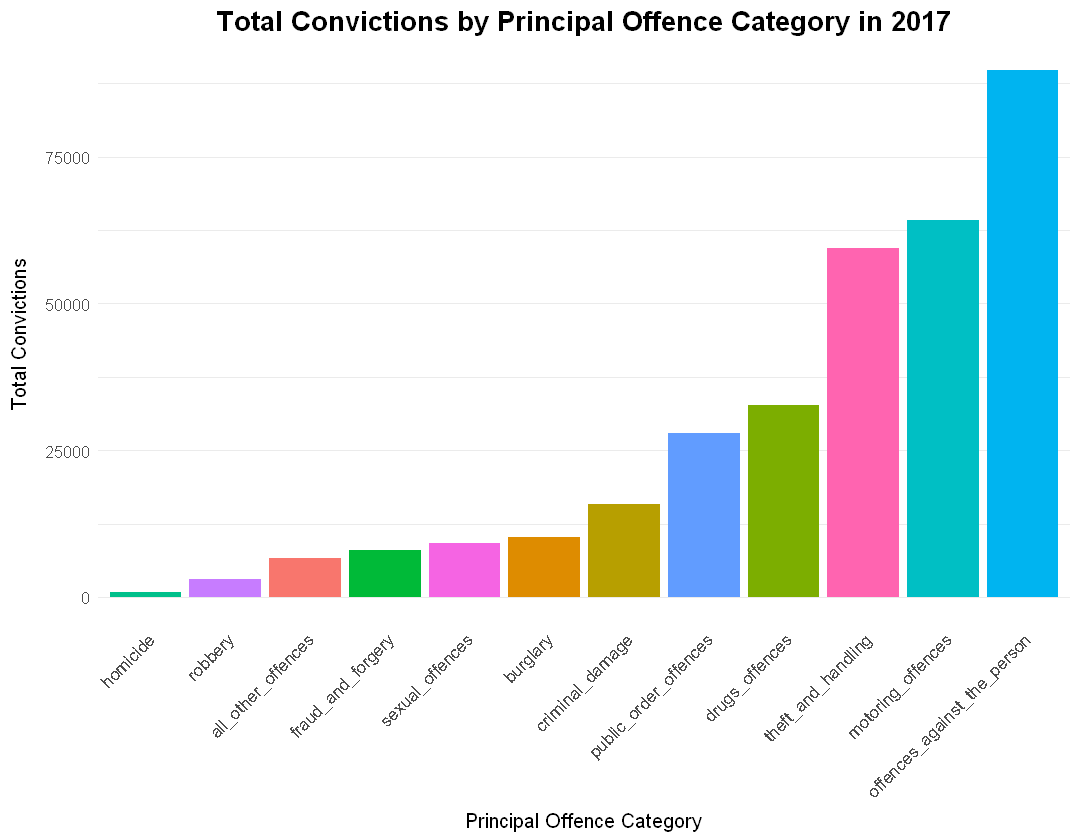

In [90]:
conviction_bar_chart(prosecutions_2017, 2017)

#### unsuccessful prosecutions

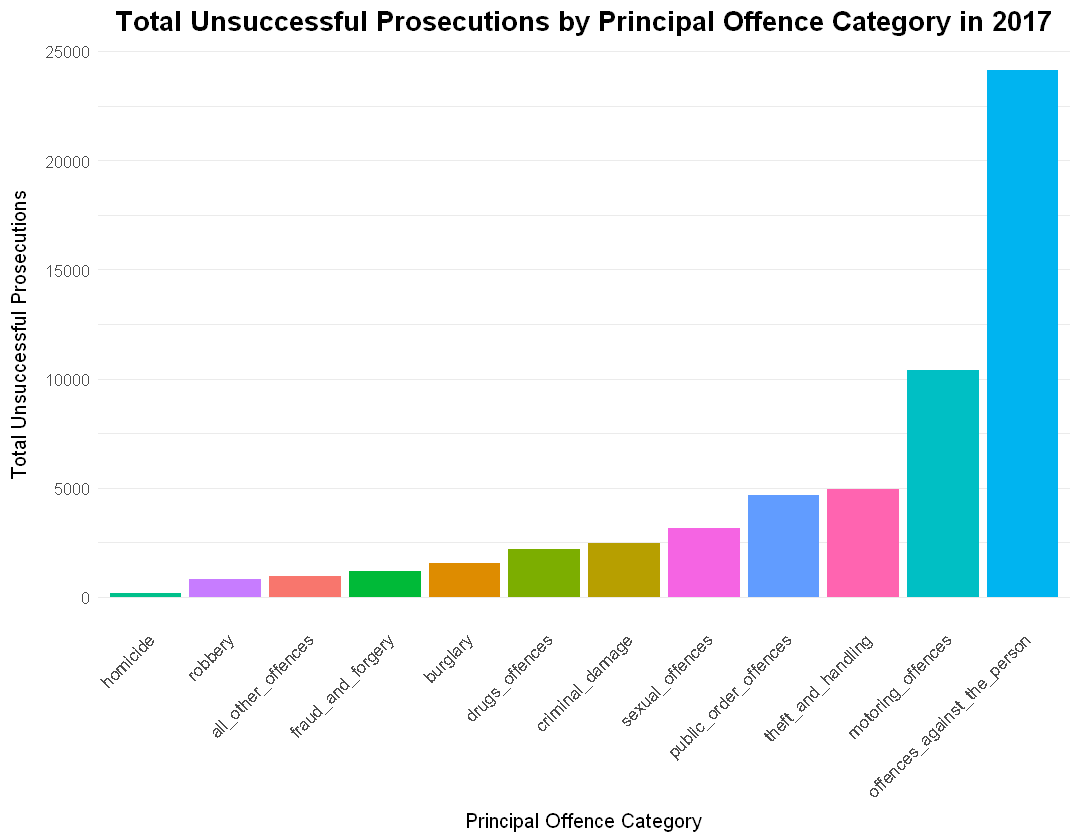

In [91]:
unsuccessful_bar_chart(prosecutions_2017, 2017)


#### total prosecuted cases


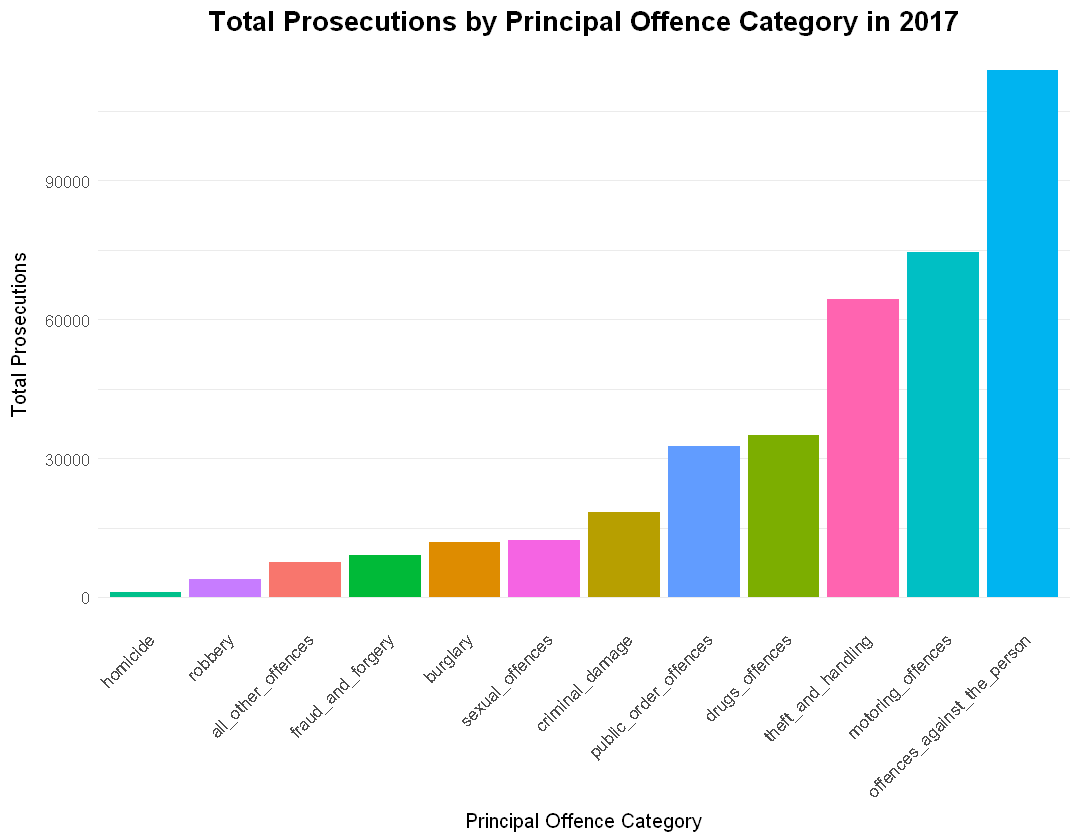

In [92]:
prosecution_bar_chart(prosecutions_2017, 2017)


#### prosecution conviction rate

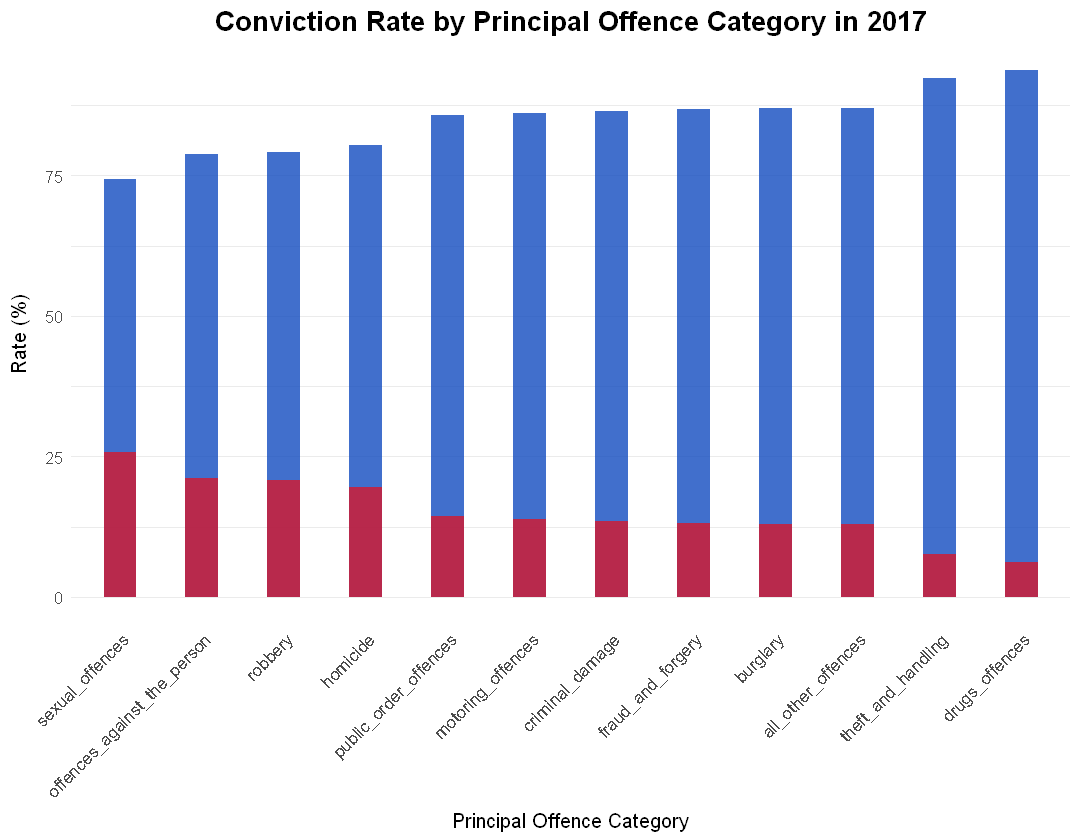

In [93]:
prosecution_rate_bar_chart(prosecutions_2017, 2017)

#### Hypothesis Testing 2017
- Pearson's chi-squared test

In [94]:
# Perform the chi-square test of independence
contingency_table <- prosecutions_2017[, c(5, 6)]

# Print the contingency table
contingency_table

# Perform the chi-square test of independence
result <- chisq.test(contingency_table)


# Extract the test statistic and p-value from the test result
test_statistic <- result$statistic
p_value <- result$p.value


# Print the results
print(result)
cat("\n")
cat("Test statistic:", test_statistic, "\n")
cat("p-value:", p_value, "\n")


# Check if the null hypothesis can be rejected based on the significance level (e.g., 0.05)
if (p_value < 0.05) {
  cat("\n")
  cat("There is a significant difference in the proportions of convictions and unsuccessful outcomes.\n")
} else {
  cat("\n")
  cat("There is no significant difference in the proportions of convictions and unsuccessful outcomes.\n")
}


conviction_rate,unsuccessful_rate
<dbl>,<dbl>
80.35,19.65
78.81,21.19
74.27,25.73
86.99,13.01
79.15,20.85
92.30,7.70
86.76,13.24
86.42,13.58
93.71,6.29



	Pearson's Chi-squared test

data:  contingency_table
X-squared = 27.346, df = 11, p-value = 0.004073


Test statistic: 27.34593 
p-value: 0.004073102 

There is a significant difference in the proportions of convictions and unsuccessful outcomes.


## year 2018
- compute data for 2018

In [95]:
prosecutions_2018 <- yearly_df_list$prosecutions_2018

prosecutions_2018

principal_offence_category,no_of_convictions,no_of_unsuccessful,no_of_prosecutions,conviction_rate,unsuccessful_rate
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
homicide,733,164,897,81.72,18.28
offences_against_the_person,75726,20077,95803,79.04,20.96
sexual_offences,7662,2582,10244,74.80,25.20
burglary,8585,1272,9857,87.10,12.90
robbery,2766,695,3461,79.92,20.08
theft_and_handling,47722,4065,51787,92.15,7.85
fraud_and_forgery,6643,1003,7646,86.88,13.12
criminal_damage,13344,2061,15405,86.62,13.38
drugs_offences,27436,1937,29373,93.41,6.59


#### convictions

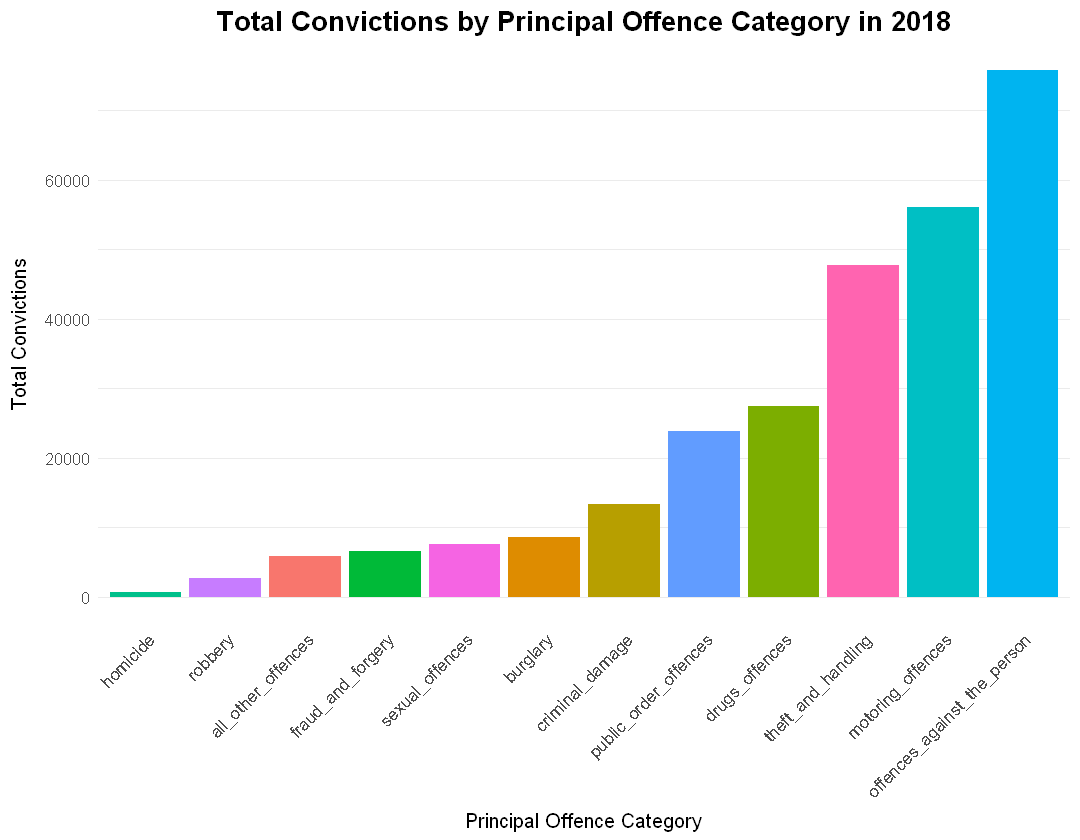

In [96]:
conviction_bar_chart(prosecutions_2018, 2018)

#### unsuccessful prosecutions

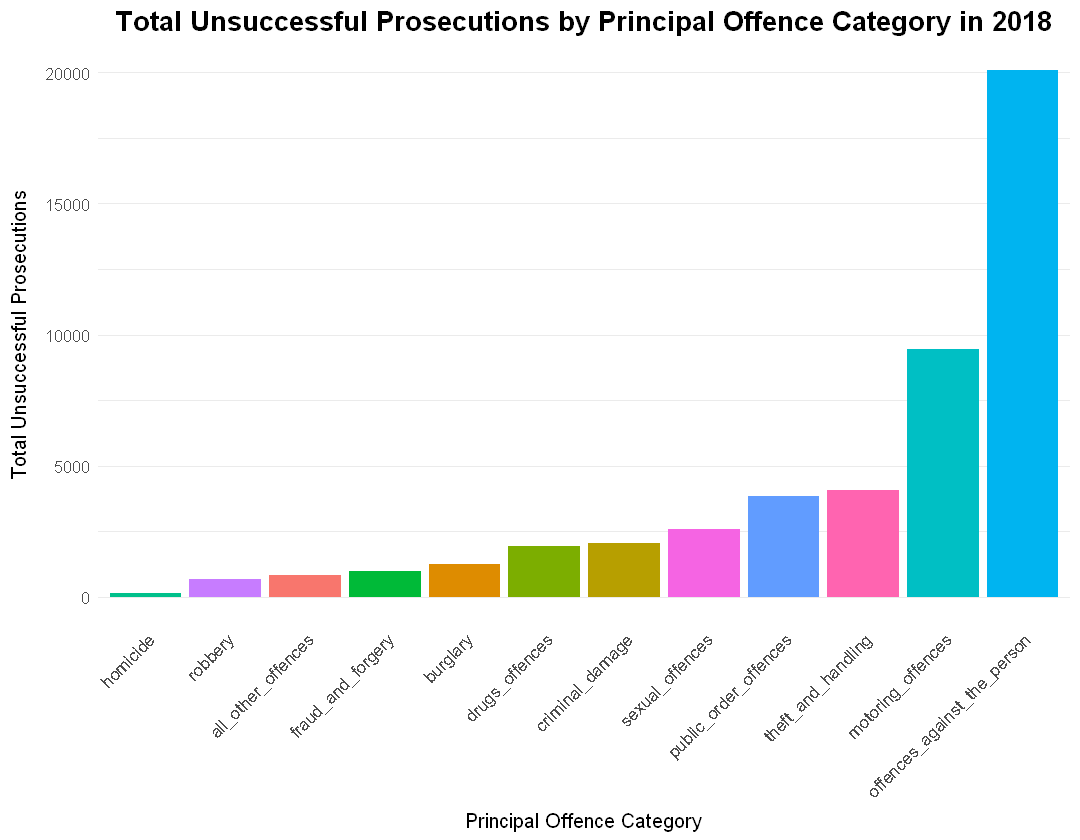

In [97]:
unsuccessful_bar_chart(prosecutions_2018, 2018)

#### total prosecuted cases

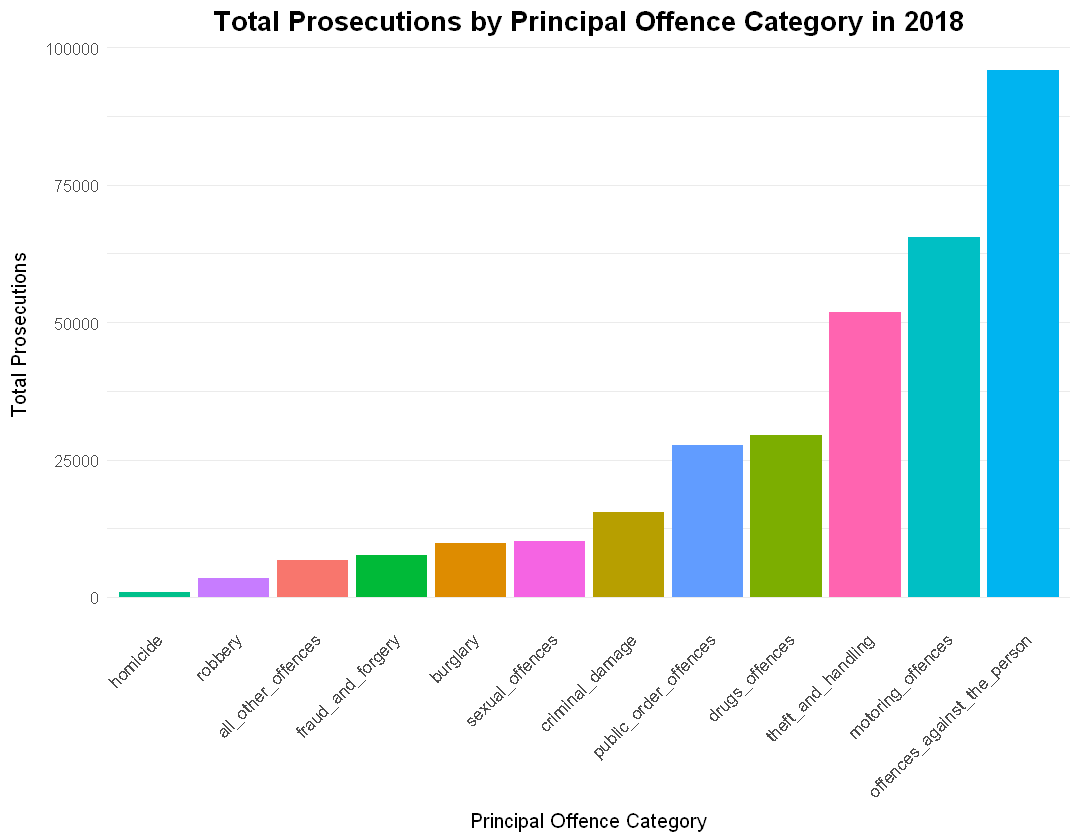

In [98]:
prosecution_bar_chart(prosecutions_2018, 2018)

#### prosecution conviction rate

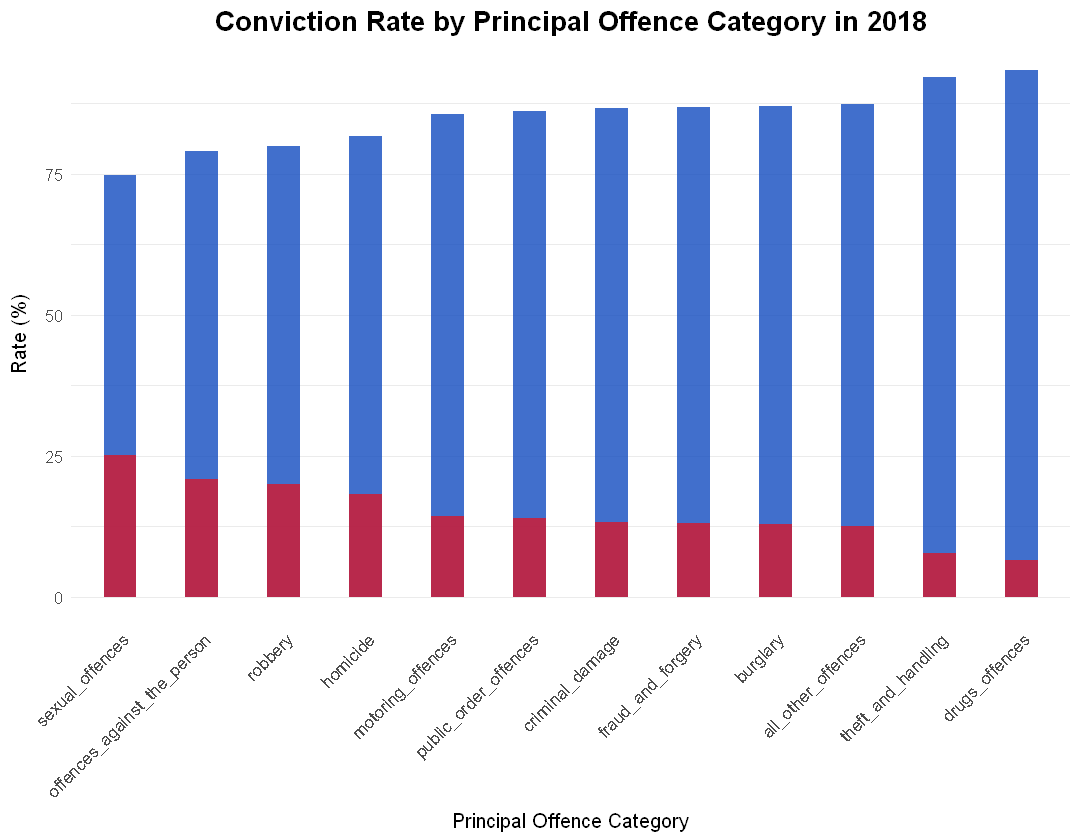

In [99]:
prosecution_rate_bar_chart(prosecutions_2018, 2018)

#### Hypothesis Testing 2018
- Pearson's chi-squared test

In [100]:
# Perform the chi-square test of independence
contingency_table <- prosecutions_2018[, c(5, 6)]

# Print the contingency table
contingency_table

# Perform the chi-square test of independence
result <- chisq.test(contingency_table)

# Extract the test statistic and p-value from the test result
test_statistic <- result$statistic
p_value <- result$p.value


# Print the results
print(result)
cat("\n")
cat("Test statistic:", test_statistic, "\n")
cat("p-value:", p_value, "\n")


# Check if the null hypothesis can be rejected based on the significance level (e.g., 0.05)
if (p_value < 0.05) {
  cat("\n")
  cat("There is a significant difference in the proportions of convictions and unsuccessful outcomes.\n")
} else {
  cat("\n")
  cat("There is no significant difference in the proportions of convictions and unsuccessful outcomes.\n")
}


conviction_rate,unsuccessful_rate
<dbl>,<dbl>
81.72,18.28
79.04,20.96
74.80,25.20
87.10,12.90
79.92,20.08
92.15,7.85
86.88,13.12
86.62,13.38
93.41,6.59



	Pearson's Chi-squared test

data:  contingency_table
X-squared = 24.885, df = 11, p-value = 0.009477


Test statistic: 24.88483 
p-value: 0.009477159 

There is a significant difference in the proportions of convictions and unsuccessful outcomes.


### **QUESTION 2:** What is the relationship between the conviction rate and total case count for different offence categories?

### **HYPOTHESIS 2:** The conviction rate of an offence category is inversely correlated with the total case count.

- **Null hypothesis:** There is no correlation between the conviction rate and the total case count of an offence category.
- **Alternative hypothesis:** The conviction rate and the total case count of an offence category are inversely correlated


Steps:
Using the yearly_list dataset;
- Collect the data on the conviction rates and total case counts for each offence category.
- Calculate the correlation coefficient between the conviction rates and total case counts using Pearson or Spearman correlation coefficient.
- Based on the calculated correlation coefficient and the sample size, conduct hypothesis testing to determine if the correlation is statistically significant.

### define function find the correlation between the two variables

In [101]:
get_correlation <- function(data) {

    correlation <- cor(data$conviction_rate, data$no_of_prosecutions, method = "pearson")
    # correlation <- round(correlation, 2)
    
    return(correlation)
}


### define function to plot relationship between the variables

In [102]:
plot_relationship <- function(data, conviction_rate_column, no_of_prosecutions_column) {
  plot_data <- data[, c(conviction_rate_column, no_of_prosecutions_column)]
  plot_data <- na.omit(plot_data)  # Remove rows with missing values
  
  ggplot(plot_data, aes(x = get(conviction_rate_column), y = get(no_of_prosecutions_column))) +
    geom_point(color = "#1f77b4", size = 3) +
    geom_smooth(method = "lm", se = FALSE, color = "red", linetype = "dashed") +
    labs(x = "Conviction Rate", y = "Total Case Count") +
    theme_minimal() +
    theme(axis.line = element_line(color = "black"),
          plot.title = element_text(size = 18, face = "bold", margin = margin(b = 20)),
          axis.title = element_text(size = 14, face = "bold"),
          axis.text = element_text(size = 12))
}


### define function to conduct hypothesis test

In [103]:
conduct_hypothesis_test <- function(year, data) {
  null_hypothesis <- "There is no significant correlation between the conviction rate and total case count."
  alternative_hypothesis <- "There is a significant correlation between the conviction rate and total case count."

  # Set threshold for rejection of null hypothesis
  alpha <- 0.05

  # Calculate the p-value
  p_value <- cor.test(data$conviction_rate, data$no_of_prosecutions)$p.value

  # Print the p-value
  cat("P_value =", p_value, "\n")

  # Check if the p-value is less than the threshold
  if (p_value < alpha) {
    print("Reject the null hypothesis")
  } else {
    print("Fail to reject the null hypothesis")
  }
}

### Year 2014
#### find correlation between conviction_rate and no_of_prosecutions

In [104]:
correlation_2014 <- get_correlation(prosecutions_2014)

#### visualise relationship

`geom_smooth()` using formula = 'y ~ x'


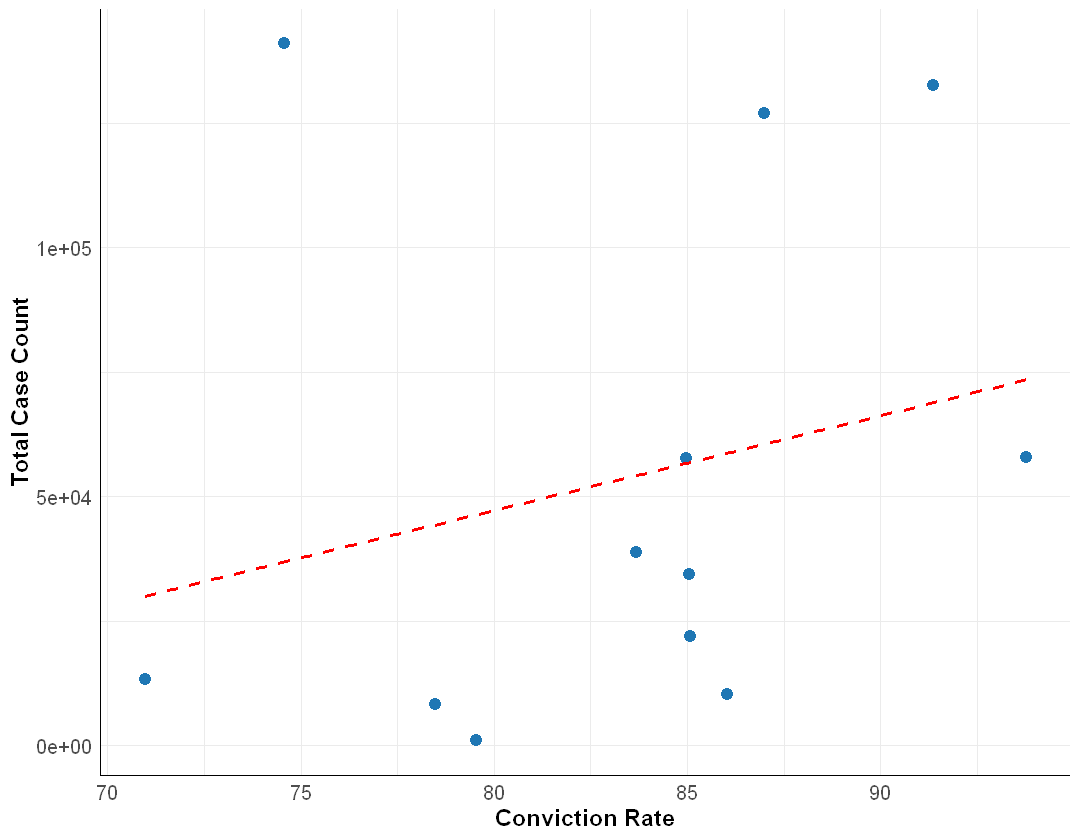

In [105]:
plot_relationship(prosecutions_2014, "conviction_rate", "no_of_prosecutions")

hypothesis test

In [106]:
conduct_hypothesis_test(2014, prosecutions_2014)


P_value = 0.4491222 
[1] "Fail to reject the null hypothesis"


### Year 2015

In [107]:
correlation_2015 <- get_correlation(prosecutions_2015)
correlation_2015

[1] 0.1348669

#### visualise relationship

`geom_smooth()` using formula = 'y ~ x'


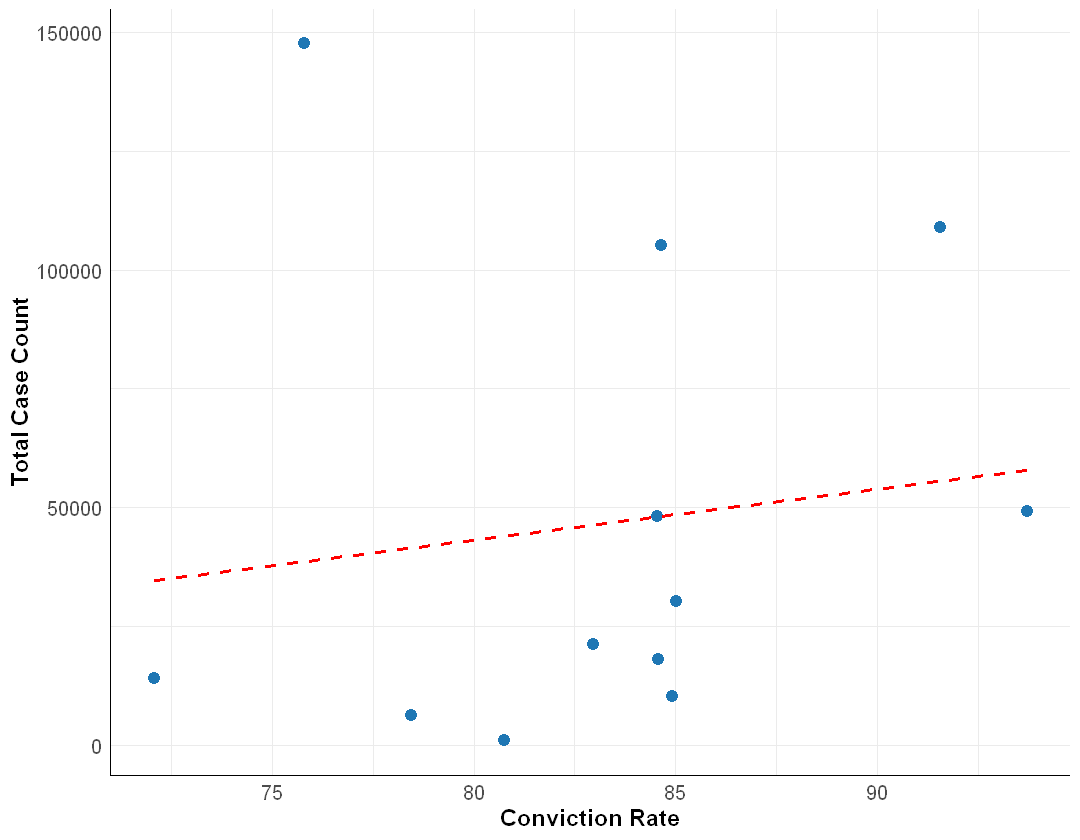

In [108]:
plot_relationship(prosecutions_2015, "conviction_rate", "no_of_prosecutions")

hypothesis test

In [109]:
conduct_hypothesis_test(2015, prosecutions_2015)

P_value = 0.6760197 
[1] "Fail to reject the null hypothesis"


### Year 2016

In [110]:
correlation_2016 <- get_correlation(prosecutions_2016)
correlation_2016

[1] 0.08748537

#### visualise relationship

`geom_smooth()` using formula = 'y ~ x'


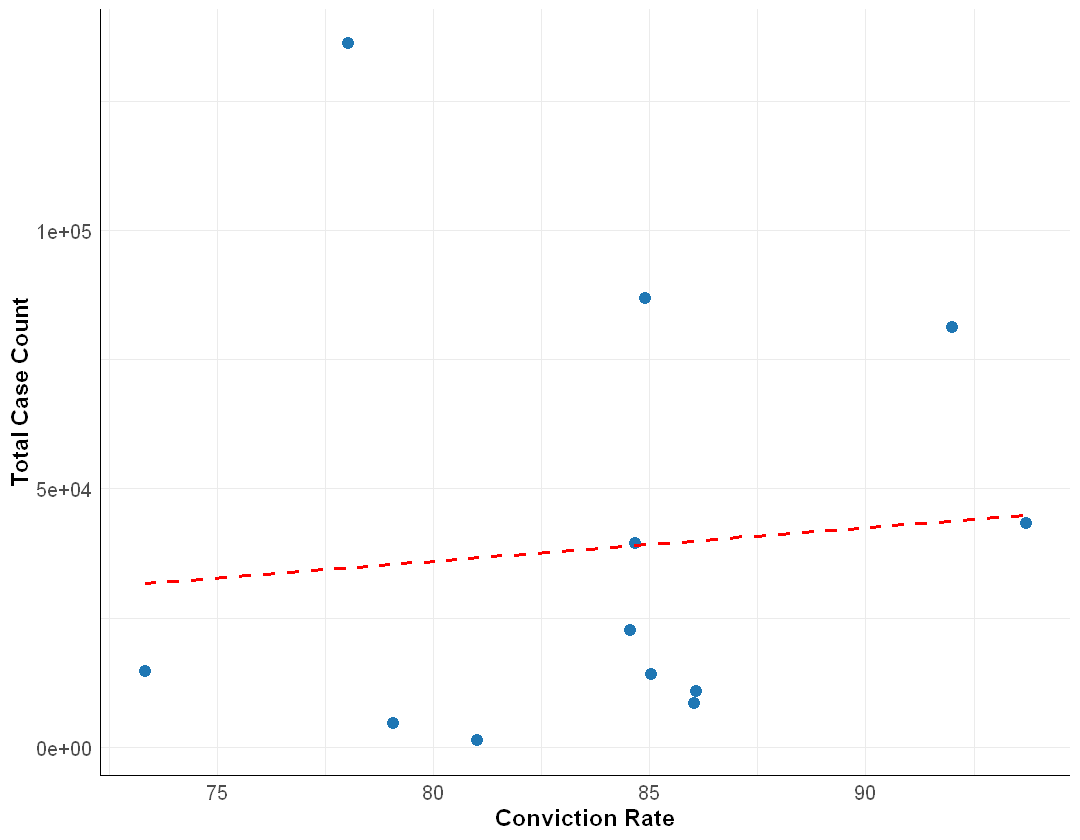

In [111]:
plot_relationship(prosecutions_2016, "conviction_rate", "no_of_prosecutions")

hypothesis test

In [112]:
conduct_hypothesis_test(2016, prosecutions_2016)

P_value = 0.786886 
[1] "Fail to reject the null hypothesis"


### Year 2017

In [113]:
correlation_2017 <- get_correlation(prosecutions_2017)
correlation_2017

[1] 0.0789551

#### visualise relationship

`geom_smooth()` using formula = 'y ~ x'


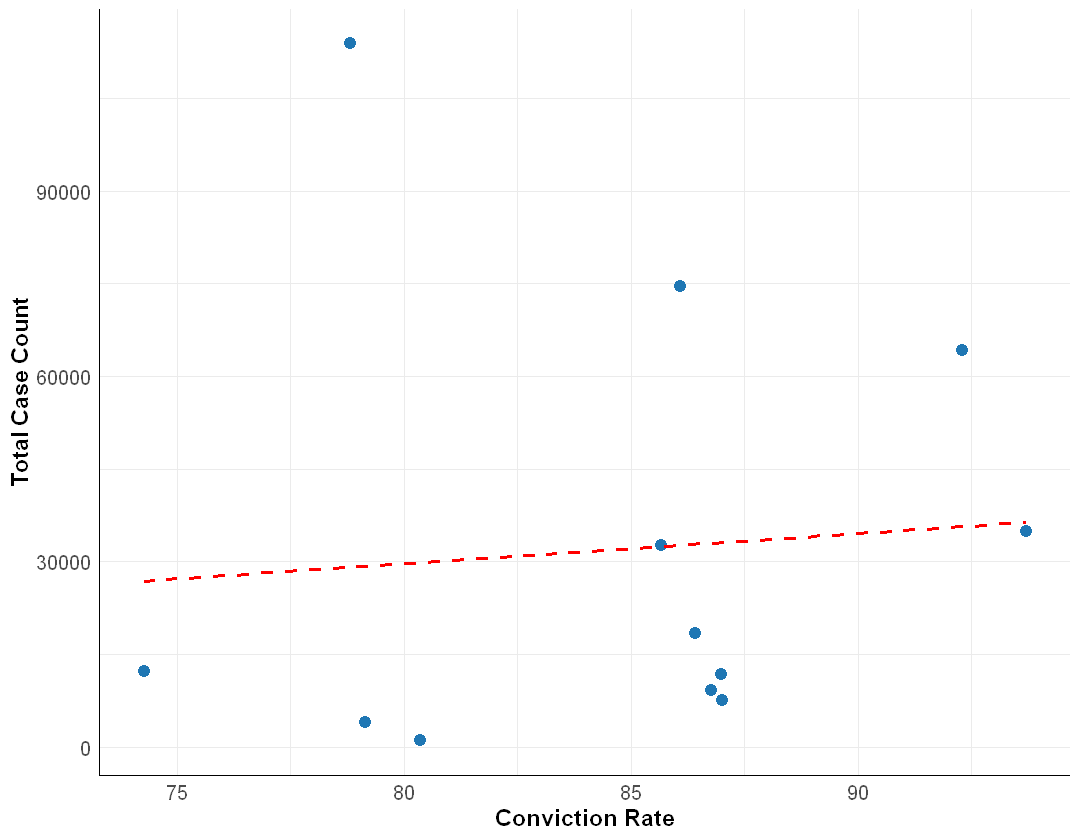

In [114]:
plot_relationship(prosecutions_2017, "conviction_rate", "no_of_prosecutions")

hypothesis test

In [115]:
conduct_hypothesis_test(2017, prosecutions_2017)

P_value = 0.8073024 
[1] "Fail to reject the null hypothesis"


### Year 2018

In [116]:
correlation_2018 <- get_correlation(prosecutions_2018)
correlation_2018

[1] 0.02569543

#### visualise relationship

`geom_smooth()` using formula = 'y ~ x'


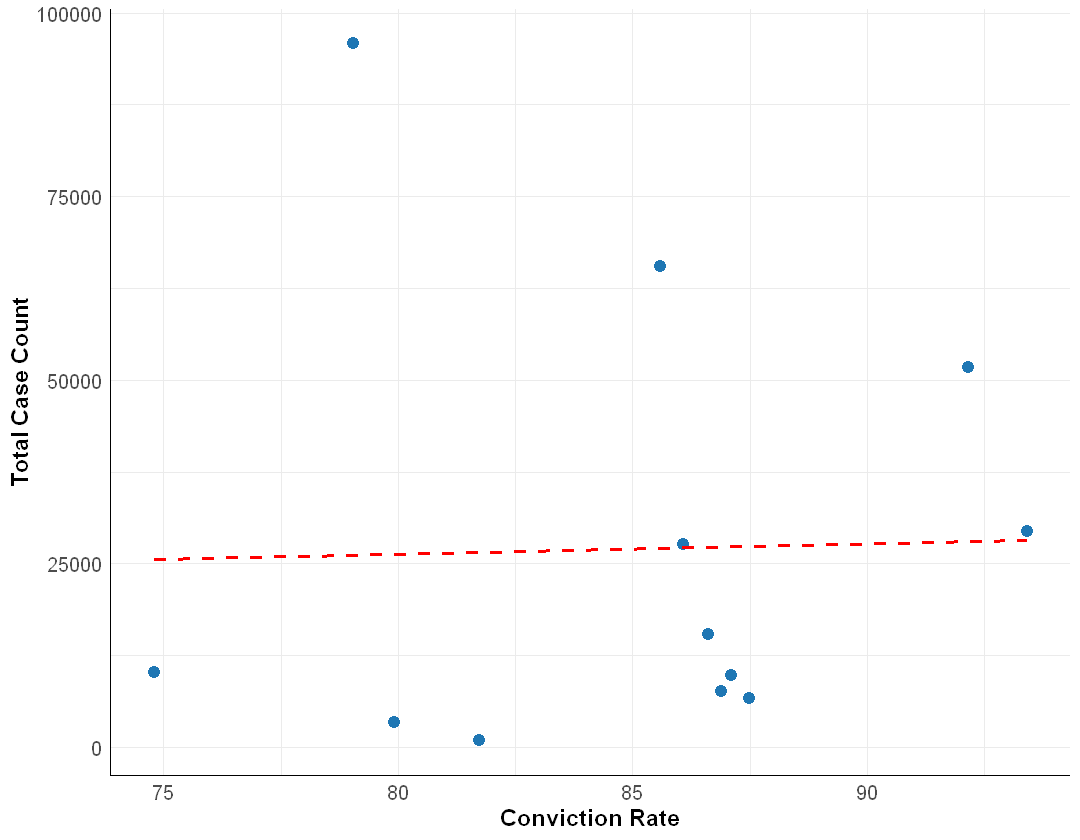

In [117]:
plot_relationship(prosecutions_2018, "conviction_rate", "no_of_prosecutions")

hypothesis test

In [118]:
conduct_hypothesis_test(2018, prosecutions_2018)

P_value = 0.9368208 
[1] "Fail to reject the null hypothesis"


The line produced in the scatter plot as executed by geom_smooth() function, represents the estimated trend or relationship between the x and y variables (total prosecuted case and conviction rates) data. using the "lm" method for linear regression, the line represents the estimated linear relationship between the variables.

 To interprete the line, we observe its slope and direction.

If the line has a positive slope, it indicates a positive relationship between the x and y variables. This means that as the x variable increases, the y variable tends to increase as well.
If the line has a negative slope, it indicates a negative relationship between the x and y variables. This means that as the x variable increases, the y variable tends to decrease.
The steepness of the line indicates the strength of the relationship. A steeper line suggests a stronger relationship between the variables, while a flatter line suggests a weaker relationship.
The line also provides an estimate of the average change in the y variable associated with a one-unit increase in the x variable. This can be useful for understanding the magnitude of the relationship.
It's important to note that interpretation should consider the context of your specific data and research question. Other factors such as statistical significance, data distribution, and the presence of outliers should also be taken into account for a comprehensive interpretation of the relationship between the variables.

### **QUESTION 3:** What are the principal offence categories with the highest conviction rates and highest unsuccessful rates

### Top 5 Principal Offence Category by conviction and unsuccessful rates for each year

### get top 5 by conviction rates

In [119]:
# set threshold for high conviction rates
threshold_conviction <- 85 

# Identify categories with highest conviction rates
categories_high_conviction <- subset(prosecutions_2014, conviction_rate > threshold_conviction)

# Order the subset by conviction rate in descending order
categories_high_conviction <- categories_high_conviction[order(categories_high_conviction$conviction_rate, decreasing = TRUE), ]

categories_high_conviction


,principal_offence_category,no_of_convictions,no_of_unsuccessful,no_of_prosecutions,conviction_rate,unsuccessful_rate
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,drugs_offences,54210,3594,57804,93.78,6.22
6,theft_and_handling,121081,11456,132537,91.36,8.64
12,motoring_offences,110572,16520,127092,87.00,13.00
7,fraud_and_forgery,8893,1443,10336,86.04,13.96
4,burglary,18574,3255,21829,85.09,14.91
8,criminal_damage,29242,5142,34384,85.05,14.95


### get top 5 by unsuccessful rates

In [120]:
# set threshold for high unsuccessful rates
threshold_unsuccessful  <- 25

# Identify categories with highest unsuccessful rates
categories_high_unsuccessful <- subset(prosecutions_2014, unsuccessful_rate > threshold_unsuccessful)

# Order the subset by unsuccessful rate in descending order
categories_high_unsuccessful <- categories_high_unsuccessful[order(categories_high_unsuccessful$unsuccessful_rate, decreasing = TRUE), ]

categories_high_unsuccessful

,principal_offence_category,no_of_convictions,no_of_unsuccessful,no_of_prosecutions,conviction_rate,unsuccessful_rate
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,sexual_offences,9354,3829,13183,70.96,29.04
2,offences_against_the_person,105123,35858,140981,74.57,25.43


## Quarterly Trends Analysis

In [121]:
head(df_monthly_convictions)

,county_areas,region,date,month,year,quarter,homicide_con,offences_against_the_person_con,sexual_offences_con,burglary_con,robbery_con,theft_and_handling_con,fraud_and_forgery_con,criminal_damage_con,drugs_offences_con,public_order_offences_con,all_other_offences_con,motoring_offences_con
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,National,All Regions,2014-01-01,Jan,2014,Q1_2014,51,9087,736,1715,522,11057,846,2693,4988,4752,3291,12945
2,National,All Regions,2014-02-01,Feb,2014,Q1_2014,61,8366,712,1549,541,10150,758,2455,4565,3787,3208,12078
3,National,All Regions,2014-03-01,Mar,2014,Q1_2014,57,8595,731,1618,569,10716,814,2413,4649,3920,2994,11155
4,National,All Regions,2014-04-01,Apr,2014,Q2_2014,81,7805,698,1470,517,10045,666,2259,4536,3549,2640,8283
5,National,All Regions,2014-05-01,May,2014,Q2_2014,69,8178,721,1562,532,10146,754,2403,4510,4022,2753,8615
6,National,All Regions,2014-06-01,Jun,2014,Q2_2014,61,8444,778,1467,512,9938,708,2466,4563,4023,2743,8407


get principal offence category names

In [122]:
crime_categories <- colnames(df_monthly_convictions)[7:18]

principal_offence_categories <- substr(crime_categories, 1, nchar(crime_categories) - 4)

principal_offence_categories

[1] "homicide"                    "offences_against_the_person"
 [3] "sexual_offences"             "burglary"                   
 [5] "robbery"                     "theft_and_handling"         
 [7] "fraud_and_forgery"           "criminal_damage"            
 [9] "drugs_offences"              "public_order_offences"      
[11] "all_other_offences"          "motoring_offences"

get unique quarters present in dataset

In [123]:
unique_quarters <- unique(df_monthly_convictions$quarter)

# unique_quarters

### Quarterly Conviction Data
#### define function get quarterly aggregates

In [124]:
# define a function to calculate the quarterly aggregate from the monthly data
calculate_quarterly_sums <- function(df, target_quarter) {
  quarter_sum <- colSums(df[df$quarter == target_quarter, ][, 7:18])
  return(quarter_sum)
}



#### compute and store the aggregates for each quarter in unique_quarters using function above

In [125]:
# create empty list to store quarterly sums
quarterly_sum_list_convictions <- rep(list(), length(unique_quarters))

# loop over unique quarters and calculate quarterly sums
for (i in seq_along(unique_quarters)) {
  quarter <- unique_quarters[i]
  quarterly_sum_list_convictions[[quarter]] <- calculate_quarterly_sums(df_monthly_convictions, quarter)
}

#### convert named list to quarterly_convictions data frame

In [126]:
# convert the list to a data frame
df_quarterly_convictions <- data.frame(principal_offence_category = principal_offence_categories, quarterly_sum_list_convictions, row.names = NULL)
# head(df_quarterly_convictions)

##### Transform the data frame pivoting on the principal offence categories

In [127]:

# Convert the data frame to long format
df_quarterly_convictions <- pivot_longer(df_quarterly_convictions, cols = -principal_offence_category, names_to = "quarter", values_to = "sum")
# head(df_quarterly_convictions)

# Convert the data frame back to wide format
df_quarterly_convictions <- pivot_wider(df_quarterly_convictions, names_from = principal_offence_category, values_from = sum)

# Print the final wide format data frame
df_quarterly_convictions

quarter,homicide,offences_against_the_person,sexual_offences,burglary,robbery,theft_and_handling,fraud_and_forgery,criminal_damage,drugs_offences,public_order_offences,all_other_offences,motoring_offences
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Q1_2014,169,26048,2179,4882,1632,31923,2418,7561,14202,12459,9493,36178
Q2_2014,211,24427,2197,4499,1561,30129,2128,7128,13609,11594,8136,25305
Q3_2014,172,27373,2492,4694,1736,30082,2238,7438,13545,12926,7883,25116
Q4_2014,179,27275,2486,4499,1527,28947,2109,7115,12854,12029,6947,23973
Q1_2015,157,29330,2621,4520,1485,29906,2356,7346,13219,12240,5771,24531
Q2_2015,219,29338,2669,3900,1371,27635,2195,7016,12198,10954,5419,23946
Q3_2015,193,31235,2859,4065,1230,26333,2351,7246,12408,10978,5030,25455
Q4_2015,194,21944,1953,2814,796,15845,1824,4072,8219,6633,1374,15030
Q1_2016,88,11741,971,1371,419,8276,1027,2166,4457,3597,710,7962


###  Quarterly Unsuccessful Data
#### compute and store the aggregates for each quarter in unique_quarters using calculate_quarterly_sums function defined above

In [128]:
# create empty list to store quarterly sums
quarterly_sum_list_unsuccessful <- rep(list(), length(unique_quarters))

# loop over unique quarters and calculate quarterly sums
for (i in seq_along(unique_quarters)) {
  quarter <- unique_quarters[i]
  quarterly_sum_list_unsuccessful[[quarter]] <- calculate_quarterly_sums(df_monthly_unsuccessful, quarter)
}


#### convert named list to quarterly_convictions data frame

In [129]:
# Create a data frame from the quaterly_sum_list
df_quarterly_unsuccessful <- data.frame(principal_offence_category = principal_offence_categories, quarterly_sum_list_unsuccessful, row.names = NULL)
# df_quarterly_unsuccessful

##### Transform the data frame pivoting on the principal offence categories

In [130]:
# Convert the data frame to long format
df_quarterly_unsuccessful <- pivot_longer(df_quarterly_unsuccessful, cols = -principal_offence_category, names_to = "quarter", values_to = "sum")

# Convert the data frame back to wide format, pivoting on principal_offence_category
df_quarterly_unsuccessful <- pivot_wider(df_quarterly_unsuccessful, names_from = principal_offence_category, values_from = sum)

# Print the final wide format data frame
df_quarterly_unsuccessful


quarter,homicide,offences_against_the_person,sexual_offences,burglary,robbery,theft_and_handling,fraud_and_forgery,criminal_damage,drugs_offences,public_order_offences,all_other_offences,motoring_offences
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Q1_2014,51,8954,894,807,446,2886,362,1331,892,2244,1724,4316
Q2_2014,49,8333,890,770,412,2804,345,1233,902,2077,1570,4121
Q3_2014,48,9364,1000,866,512,2975,388,1336,900,2210,1563,4120
Q4_2014,40,9207,1045,812,400,2791,348,1242,900,2128,1472,3963
Q1_2015,34,9656,1041,842,432,2697,425,1288,873,2216,1287,4316
Q2_2015,46,9645,1020,733,333,2470,363,1229,800,1949,996,4336
Q3_2015,61,10042,1169,742,396,2454,420,1225,814,1974,1065,4742
Q4_2015,41,6393,684,477,181,1547,341,778,598,1320,268,2741
Q1_2016,20,3262,367,242,114,757,171,369,303,722,125,1509


### define function to compute Quarterly  Prosecution Rates data

In [131]:
compute_quarterly_data <- function(quarter, category_names, quarterly_convictions_data, quarterly_unsuccessful_data) {
  # Filter the convictions data for the given quarter
  filtered_convictions_data <- quarterly_convictions_data[quarterly_convictions_data$quarter == quarter, ]

  # Filter the unsuccessful prosecutions data for the given quarter
  filtered_unsuccessful_data <- quarterly_unsuccessful_data[quarterly_unsuccessful_data$quarter == quarter, ]

  # Compute total convictions
  no_of_convictions <- colSums(filtered_convictions_data[, 2:13])

  # Compute total unsuccessful prosecutions
  no_of_unsuccessful <- colSums(filtered_unsuccessful_data[, 2:13])

  # Compute total prosecutions
  total_prosecutions <- no_of_convictions + no_of_unsuccessful

  # compute conviction rate
  conviction_rate <- round(no_of_convictions / total_prosecutions * 100, 2)

  # compute unsuccessful rate
  unsuccessful_rate <- round(no_of_unsuccessful / total_prosecutions * 100, 2)

  # if (quarter == "Q2_2017" | quarter == "Q2_2018") {

  #   conviction_rate <- 0
  #   unsuccessful_rate <- 0

  # }


  # Create the data frame for the bar chart
  quarterly_prosecutions_df <- data.frame(
    principal_offence_category = category_names,
    quarter = quarter,
    no_of_convictions = no_of_convictions,
    no_of_unsuccessful = no_of_unsuccessful,
    total_prosecutions = total_prosecutions,
    conviction_rate = conviction_rate,
    unsuccessful_rate = unsuccessful_rate,
    row.names = NULL
  )
  
  # Return the data frame
  return(quarterly_prosecutions_df)
  
}


#### define function to execute the above function for each quarter

In [132]:
# 
execute_all_quarterly_data <- function(unique_quarter, category_names, conviction_data, unsuccessful_data) {

  # Create an empty list to store the data frames
  quarterly_df_list <- list()

  # Loop through all the quarters
  for (quarter in unique_quarter) {

    # compute the data for the given quarter using the compute_quarterly_data function
    quarterly_prosecutions_df <- compute_quarterly_data(quarter, category_names, conviction_data, unsuccessful_data)

    # Append the data frame to the list
    quarterly_df_list[[paste0("prosecutions_", quarter)]] <- quarterly_prosecutions_df

  }


  # Return the list
  return(quarterly_df_list)

}


#### Execute the function to get the quarterly data for all the quarters ####

In [133]:
# Call the function to process all the quarters and store the list of data frames in a variable
quarterly_prosecutions_list <- execute_all_quarterly_data(unique_quarters, principal_offence_categories, df_quarterly_convictions, df_quarterly_unsuccessful)

# Print the list
# quarterly_prosecutions_list


### Join and Transform quarterly tables to show quarterly trend of trend of conviction rates for each crime category

#### define function to bind
- this subsets specified proseccution category (conviction/unsuccessful) rates columns from each data frame in *quarterly_prosecutions_list* (prosecution rates), bind all together row_wise, and transforms to wide format.

In [134]:

# Function to bind and convert data frames to wide format
bind_and_convert_to_wide <- function(df_list, select_columns) {
  df_combined <- do.call(rbind, setNames(lapply(df_list, function(df) df[, select_columns]), NULL))
  
  df_wide <- pivot_wider(df_combined, names_from = colnames(df_combined)[1], values_from = colnames(df_combined)[3])
  
  return(df_wide)
}


#### define function to plot line chart

In [135]:
# Function to create the plot
create_line_chart <- function(data, plot_title, crime_category, prosecution_category) {
  
  options(repr.plot.width = 15)  # Set the width of the plot

  plot <- ggplot(data, aes(x = quarter, group = 1)) +
    lapply(1:length(crime_category), function(i) {
      geom_line(aes(y = .data[[crime_category[i]]], color = paste0("Column ", i)), linewidth = 0.5)
    }) +
    labs(x = "Quarter", y = paste0(prosecution_category, " Rate"), title = plot_title) +
    scale_color_manual(
      values = c("Column 1" = "red", "Column 2" = "blue", "Column 3" = "green",
                 "Column 4" = "orange", "Column 5" = "purple", "Column 6" = "brown",
                 "Column 7" = "pink", "Column 8" = "grey", "Column 9" = "yellow",
                 "Column 10" = "cyan", "Column 11" = "magenta", "Column 12" = "black"),
      labels = crime_category,
      name = "Crime Category"
    ) +
    coord_cartesian(ylim = c(0, 100)) +
    theme_minimal() +
    theme(
      legend.position = "right",
      plot.title = element_text(size = 18, face = "bold", margin = margin(b = 20)),
      axis.title = element_text(size = 14, face = "bold"),
      axis.text = element_text(size = 12),
      legend.title = element_text(size = 10, face = "bold"),
      legend.text = element_text(size = 10)
    )
  
  # save the plot
  plot_name <- deparse(substitute(data))
  ggsave(paste0("plots/", plot_name,".png"), plot, width = 15, height = 6, dpi = 300)
  
  return(plot)
}


#### subset quarterly conviction prosecution using *bind_and_convert_to_wide* function above ####

In [136]:
# subset conviction rates columns from the quarterly prosecution rates data frame
select_columns_convictions <- c(1, 2, 6)  # Columns to select

# Bind and convert to wide format for conviction rates
df_quarter_rates_convictions <- bind_and_convert_to_wide(quarterly_prosecutions_list, select_columns_convictions)

df_quarter_rates_convictions


quarter,homicide,offences_against_the_person,sexual_offences,burglary,robbery,theft_and_handling,fraud_and_forgery,criminal_damage,drugs_offences,public_order_offences,all_other_offences,motoring_offences
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Q1_2014,76.82,74.42,70.91,85.81,78.54,91.71,86.98,85.03,94.09,84.74,84.63,89.34
Q2_2014,81.15,74.56,71.17,85.39,79.12,91.49,86.05,85.25,93.78,84.81,83.82,86.00
Q3_2014,78.18,74.51,71.36,84.42,77.22,91.00,85.22,84.77,93.77,85.40,83.45,85.91
Q4_2014,81.74,74.76,70.40,84.71,79.24,91.21,85.84,85.14,93.46,84.97,82.52,85.81
Q1_2015,82.20,75.23,71.57,84.30,77.46,91.73,84.72,85.08,93.80,84.67,81.77,85.04
Q2_2015,82.64,75.26,72.35,84.18,80.46,91.80,85.81,85.09,93.85,84.89,84.47,84.67
Q3_2015,75.98,75.67,70.98,84.56,75.65,91.48,84.84,85.54,93.84,84.76,82.53,84.30
Q4_2015,82.55,77.44,74.06,85.51,81.47,91.11,84.25,83.96,93.22,83.40,83.68,84.58
Q1_2016,81.48,78.26,72.57,85.00,78.61,91.62,85.73,85.44,93.63,83.28,85.03,84.07


#### Visualise conviction rates using create_line_chart function defined above ####

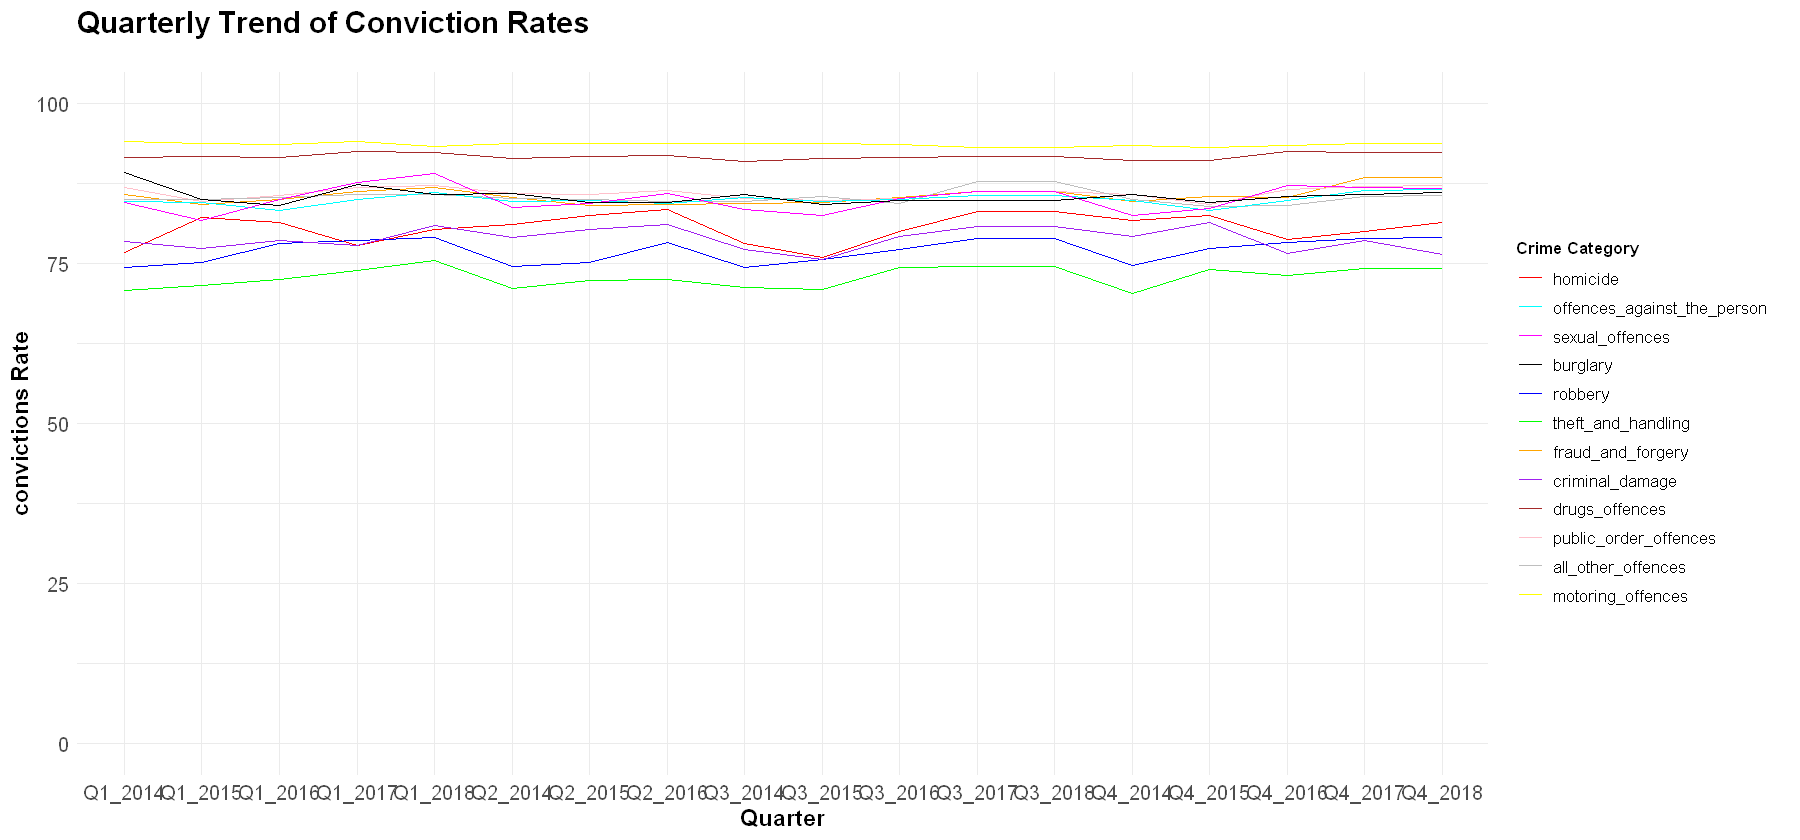

In [137]:
# set arguments for conviction rates plot
chart_title <- "Quarterly Trend of Conviction Rates"
prosecution_category <- "convictions"

plot_convictions <- create_line_chart(df_quarter_rates_convictions, chart_title, principal_offence_categories , prosecution_category)
plot_convictions

## Unsuccessful trends

### Join and Transform quarterly tables to show quarterly trend of unsuccessful prosecution rates for each crime category

#### subset quarterly unsuccessful prosecution using *bind_and_convert_to_wide* function above.

In [138]:
# subset unsuccessful rates columns from the quarterly prosecution rates data frame
select_columns_unsuccesful <- c(1, 2, 7)  # Columns to select

# Bind and convert to wide format for unsuccessful rates
df_quarter_rates_unsuccessful <- bind_and_convert_to_wide(quarterly_prosecutions_list, select_columns_unsuccesful)

df_quarter_rates_unsuccessful

quarter,homicide,offences_against_the_person,sexual_offences,burglary,robbery,theft_and_handling,fraud_and_forgery,criminal_damage,drugs_offences,public_order_offences,all_other_offences,motoring_offences
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Q1_2014,23.18,25.58,29.09,14.19,21.46,8.29,13.02,14.97,5.91,15.26,15.37,10.66
Q2_2014,18.85,25.44,28.83,14.61,20.88,8.51,13.95,14.75,6.22,15.19,16.18,14.00
Q3_2014,21.82,25.49,28.64,15.58,22.78,9.00,14.78,15.23,6.23,14.60,16.55,14.09
Q4_2014,18.26,25.24,29.60,15.29,20.76,8.79,14.16,14.86,6.54,15.03,17.48,14.19
Q1_2015,17.80,24.77,28.43,15.70,22.54,8.27,15.28,14.92,6.20,15.33,18.23,14.96
Q2_2015,17.36,24.74,27.65,15.82,19.54,8.20,14.19,14.91,6.15,15.11,15.53,15.33
Q3_2015,24.02,24.33,29.02,15.44,24.35,8.52,15.16,14.46,6.16,15.24,17.47,15.70
Q4_2015,17.45,22.56,25.94,14.49,18.53,8.89,15.75,16.04,6.78,16.60,16.32,15.42
Q1_2016,18.52,21.74,27.43,15.00,21.39,8.38,14.27,14.56,6.37,16.72,14.97,15.93


#### visualise unsuccessful rates using create_line_chart function defined above ####


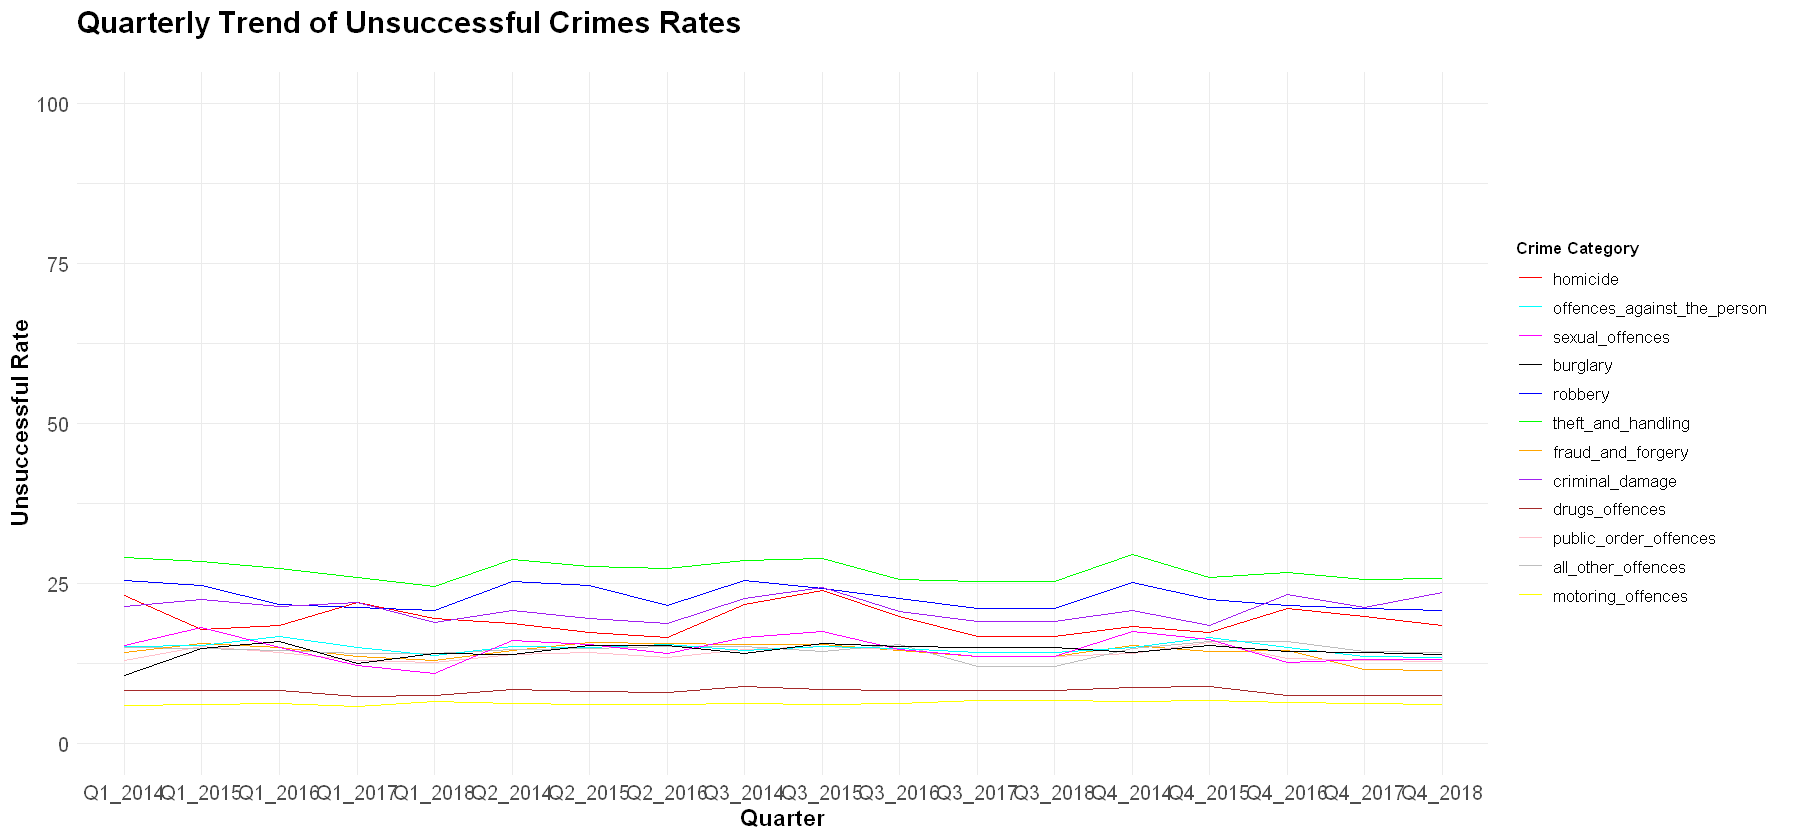

In [139]:
# set arguments for unsuccessful rates plot
chart_title <- "Quarterly Trend of Unsuccessful Crimes Rates"
prosecution_category <- "Unsuccessful"

plot_unsuccessful <- create_line_chart(df_quarter_rates_unsuccessful, chart_title, principal_offence_categories , prosecution_category)

plot_unsuccessful


## Top 5 Principal Offence Category by conviction and unsuccessful rates for each quarter
### define function to filter top 5 categories from quarterly_prosecutions_list

In [140]:
# Function to get principal offence categories with the highest rates
get_top_rates <- function(df_list, rate_category, top_n) {
  
  # Create an empty list to store the data frames
  top_rates_df_list <- list()

  # Loop through the list of data frames
  for (i in 1:length(df_list)) {
    
    # Get the data frame
    df <- df_list[[i]]

    # get the quarter
    quarter <- unique(df$quarter)
    
    # Get the highest rates
    top_rates <- head(df[order(-df[[rate_category]]), ], top_n)

    # Append the data frame to the list
    top_rates_df_list[[paste0("top_", rate_category, "_", quarter)]] <- top_rates
    
  }

    # Return the list
    return(top_rates_df_list)

}



### get top 5 by conviction rates using function defined above

In [141]:
# Get principal offence categories with the highest conviction rates
top_conviction_rates <- get_top_rates(quarterly_prosecutions_list, "conviction_rate", 5)

# top_conviction_rates

### get top 5 by unsuccessful rates using function defined above

In [142]:
# Get principal offence categories with the highest unsuccessful rates
top_unsuccessful_rates <- get_top_rates(quarterly_prosecutions_list, "unsuccessful_rate", 5)

# top_unsuccessful_rates

----
----

# PREDICTIVE ANALYSIS

# Linear Regression

In [143]:
### load datasets

df_counts_all <- read.csv("datasets/cps_data_all.csv", header = TRUE, stringsAsFactors = FALSE)
df_convictions <- read.csv("datasets/cps_data_convictions.csv", header = TRUE, stringsAsFactors = FALSE)
df_unsuccessful <- read.csv("datasets/cps_data_unsuccessful.csv", header = TRUE, stringsAsFactors = FALSE)

df_rates_all <- read.csv("datasets/cps_data_rates_all.csv", header = TRUE, stringsAsFactors = FALSE)
df_rates_convictions <- read.csv("datasets/cps_data_rates_convictions.csv", header = TRUE, stringsAsFactors = FALSE)
df_rates_unsuccessful <- read.csv("datasets/cps_data_rates_unsuccessful.csv", header = TRUE, stringsAsFactors = FALSE)


In [144]:
head(df_convictions)
head(df_rates_convictions)

str(df_convictions)
str(df_rates_convictions)  
str(df_counts_all)

,county_areas,region,date,month,year,quarter,homicide_con,offences_against_the_person_con,sexual_offences_con,burglary_con,robbery_con,theft_and_handling_con,fraud_and_forgery_con,criminal_damage_con,drugs_offences_con,public_order_offences_con,all_other_offences_con,motoring_offences_con
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Avon and Somerset,South West,2014-01-01,Jan,2014,Q1_2014,0,228,35,49,8,338,18,93,148,123,63,256
2,Bedfordshire,Thames and Chiltern,2014-01-01,Jan,2014,Q1_2014,0,68,2,7,16,75,17,22,31,30,13,171
3,Cambridgeshire,East of England,2014-01-01,Jan,2014,Q1_2014,0,101,10,18,6,148,10,30,47,37,28,103
4,Cheshire,Mersey-Cheshire,2014-01-01,Jan,2014,Q1_2014,0,170,15,38,10,205,14,39,64,77,50,264
5,Cleveland,North East,2014-01-01,Jan,2014,Q1_2014,2,119,11,36,3,334,11,46,65,123,34,228
6,Cumbria,North West,2014-01-01,Jan,2014,Q1_2014,0,113,4,16,1,115,6,38,52,78,52,112


,county_areas,region,date,month,year,quarter,rate_homicide_con,rate_offences_against_the_person_con,rate_sexual_offences_con,rate_burglary_con,rate_robbery_con,rate_theft_and_handling_con,rate_fraud_and_forgery_con,rate_criminal_damage_con,rate_drugs_offences_con,rate_public_order_offences_con,rate_all_other_offences_con,rate_motoring_offences_con
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Avon and Somerset,South West,2014-01-01,Jan,2014,Q1_2014,0,78.6,67.3,98.0,100.0,91.4,100.0,86.9,97.4,81.5,87.5,86.5
2,Bedfordshire,Thames and Chiltern,2014-01-01,Jan,2014,Q1_2014,0,70.1,66.7,63.6,69.6,94.9,85.0,73.3,91.2,76.9,86.7,92.9
3,Cambridgeshire,East of England,2014-01-01,Jan,2014,Q1_2014,0,82.8,76.9,81.8,60.0,90.8,71.4,90.9,97.9,94.9,75.7,86.6
4,Cheshire,Mersey-Cheshire,2014-01-01,Jan,2014,Q1_2014,0,81.0,93.8,88.4,100.0,97.6,93.3,92.9,95.5,90.6,90.9,94.3
5,Cleveland,North East,2014-01-01,Jan,2014,Q1_2014,40,73.0,64.7,94.7,60.0,91.5,78.6,78.0,97.0,82.0,70.8,93.4
6,Cumbria,North West,2014-01-01,Jan,2014,Q1_2014,0,89.7,57.1,100.0,100.0,94.3,100.0,92.7,98.1,97.5,91.2,94.1


'data.frame':	2100 obs. of  18 variables:
 $ county_areas                   : chr  "Avon and Somerset" "Bedfordshire" "Cambridgeshire" "Cheshire" ...
 $ region                         : chr  "South West" "Thames and Chiltern" "East of England" "Mersey-Cheshire" ...
 $ date                           : chr  "2014-01-01" "2014-01-01" "2014-01-01" "2014-01-01" ...
 $ month                          : chr  "Jan" "Jan" "Jan" "Jan" ...
 $ year                           : int  2014 2014 2014 2014 2014 2014 2014 2014 2014 2014 ...
 $ quarter                        : chr  "Q1_2014" "Q1_2014" "Q1_2014" "Q1_2014" ...
 $ homicide_con                   : int  0 0 0 0 2 0 0 0 0 1 ...
 $ offences_against_the_person_con: int  228 68 101 170 119 113 135 220 87 105 ...
 $ sexual_offences_con            : int  35 2 10 15 11 4 22 16 6 9 ...
 $ burglary_con                   : int  49 7 18 38 36 16 36 25 20 28 ...
 $ robbery_con                    : int  8 16 6 10 3 1 5 10 6 0 ...
 $ theft_and_handling_con  

In [145]:
df_convictions_merged <- merge(df_convictions, df_rates_convictions, by = c("date", "county_areas", "quarter", "region", "month", "year"))


dim(df_convictions_merged)
# df_convictions_merged

[1] 2100   30

### split dataset for train and test

In [146]:
# str(df)

col <- colnames(df_convictions)
for(i in 1:length(col)){
  cat(i, col[i], "\n")
}

col[c(7, 9:30)]

1 county_areas 
2 region 
3 date 
4 month 
5 year 
6 quarter 
7 homicide_con 
8 offences_against_the_person_con 
9 sexual_offences_con 
10 burglary_con 
11 robbery_con 
12 theft_and_handling_con 
13 fraud_and_forgery_con 
14 criminal_damage_con 
15 drugs_offences_con 
16 public_order_offences_con 
17 all_other_offences_con 
18 motoring_offences_con 


[1] "homicide_con"              "sexual_offences_con"      
 [3] "burglary_con"              "robbery_con"              
 [5] "theft_and_handling_con"    "fraud_and_forgery_con"    
 [7] "criminal_damage_con"       "drugs_offences_con"       
 [9] "public_order_offences_con" "all_other_offences_con"   
[11] "motoring_offences_con"     NA                         
[13] NA                          NA                         
[15] NA                          NA                         
[17] NA                          NA                         
[19] NA                          NA                         
[21] NA                          NA                         
[23] NA

In [147]:
df <- df_convictions_merged

set.seed(123)

# Generate random indices for training and test sets
train_indices <- sample(nrow(df), 0.75 * nrow(df))

# Split the data into training and test sets
train_data <- df[train_indices, ]
test_data <- df[-train_indices, ]
# train_data

# Verify the number of rows in the training and testing datasets
print(paste("Training dataset rows:", nrow(train_data)))
print(paste("Testing dataset rows:", nrow(test_data)))

# str(train_data)
# test_data


target <- "homicide_con"
features <- colnames(df)[c(8:18)]
formula <- as.formula(paste(target, "~", paste(features, collapse = " + ")))



# Fit the linear regression model using the training data
model <- lm(formula, data = train_data)

# Print the summary of the model
summary(model)


[1] "Training dataset rows: 1575"
[1] "Testing dataset rows: 525"



Call:
lm(formula = formula, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.6711  -0.9956  -0.4064   0.6249  24.2019 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      0.1382029  0.1001338   1.380 0.167728    
offences_against_the_person_con  0.0071902  0.0011610   6.193 7.53e-10 ***
sexual_offences_con              0.0205936  0.0052097   3.953 8.06e-05 ***
burglary_con                     0.0066031  0.0055205   1.196 0.231833    
robbery_con                      0.0139465  0.0073951   1.886 0.059491 .  
theft_and_handling_con          -0.0004869  0.0010156  -0.479 0.631666    
fraud_and_forgery_con            0.0214256  0.0059975   3.572 0.000364 ***
criminal_damage_con             -0.0127316  0.0049648  -2.564 0.010429 *  
drugs_offences_con               0.0020879  0.0015195   1.374 0.169595    
public_order_offences_con       -0.0044390  0.0021498  -2.065 0.039105 *  
all_othe

### predict

In [148]:

# Make predictions on the test data
test_predictions <- predict(model, test_data)

# Print the predictions
# test_predictions


Warning message in data.frame(Predicted = test_predictions, Residuals = resid(model)):
"row names were found from a short variable and have been discarded"


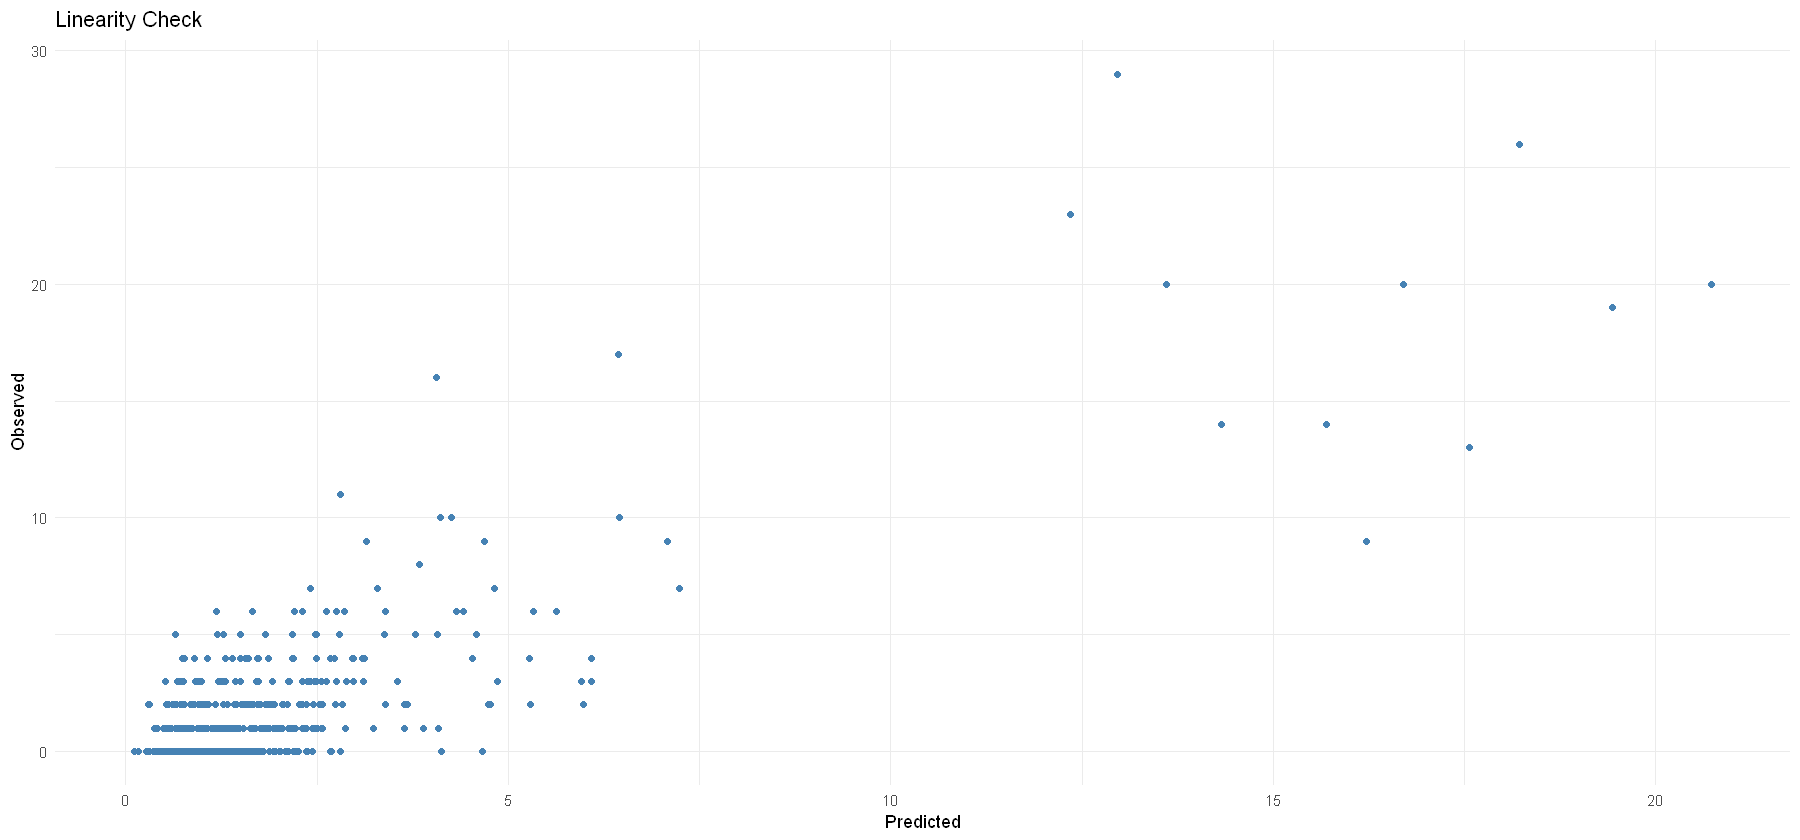

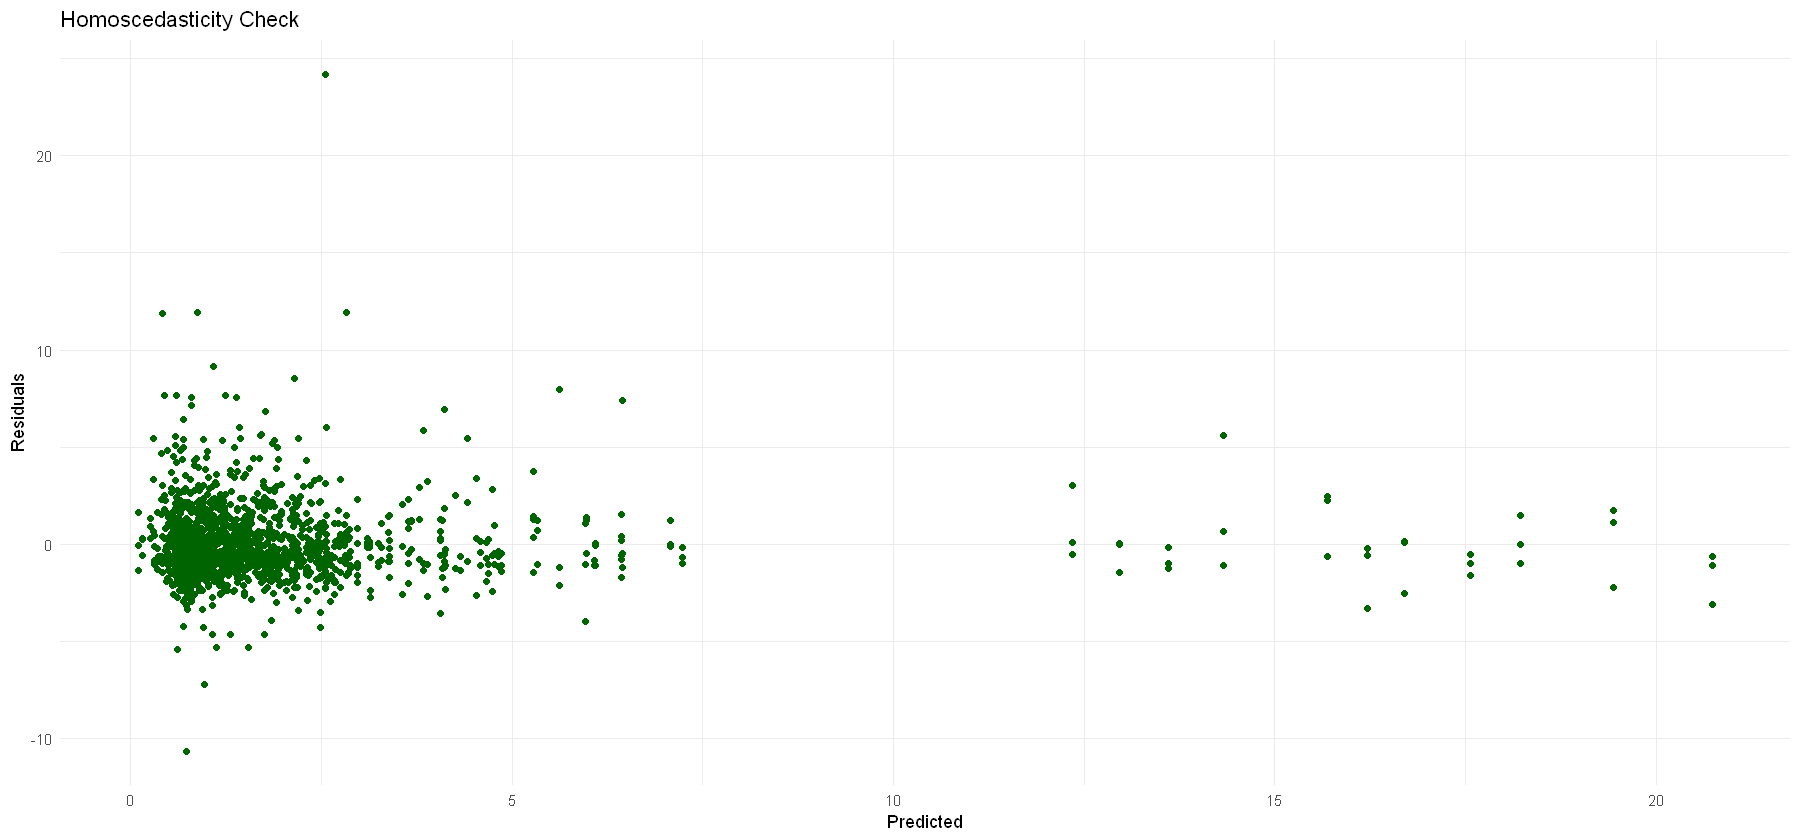

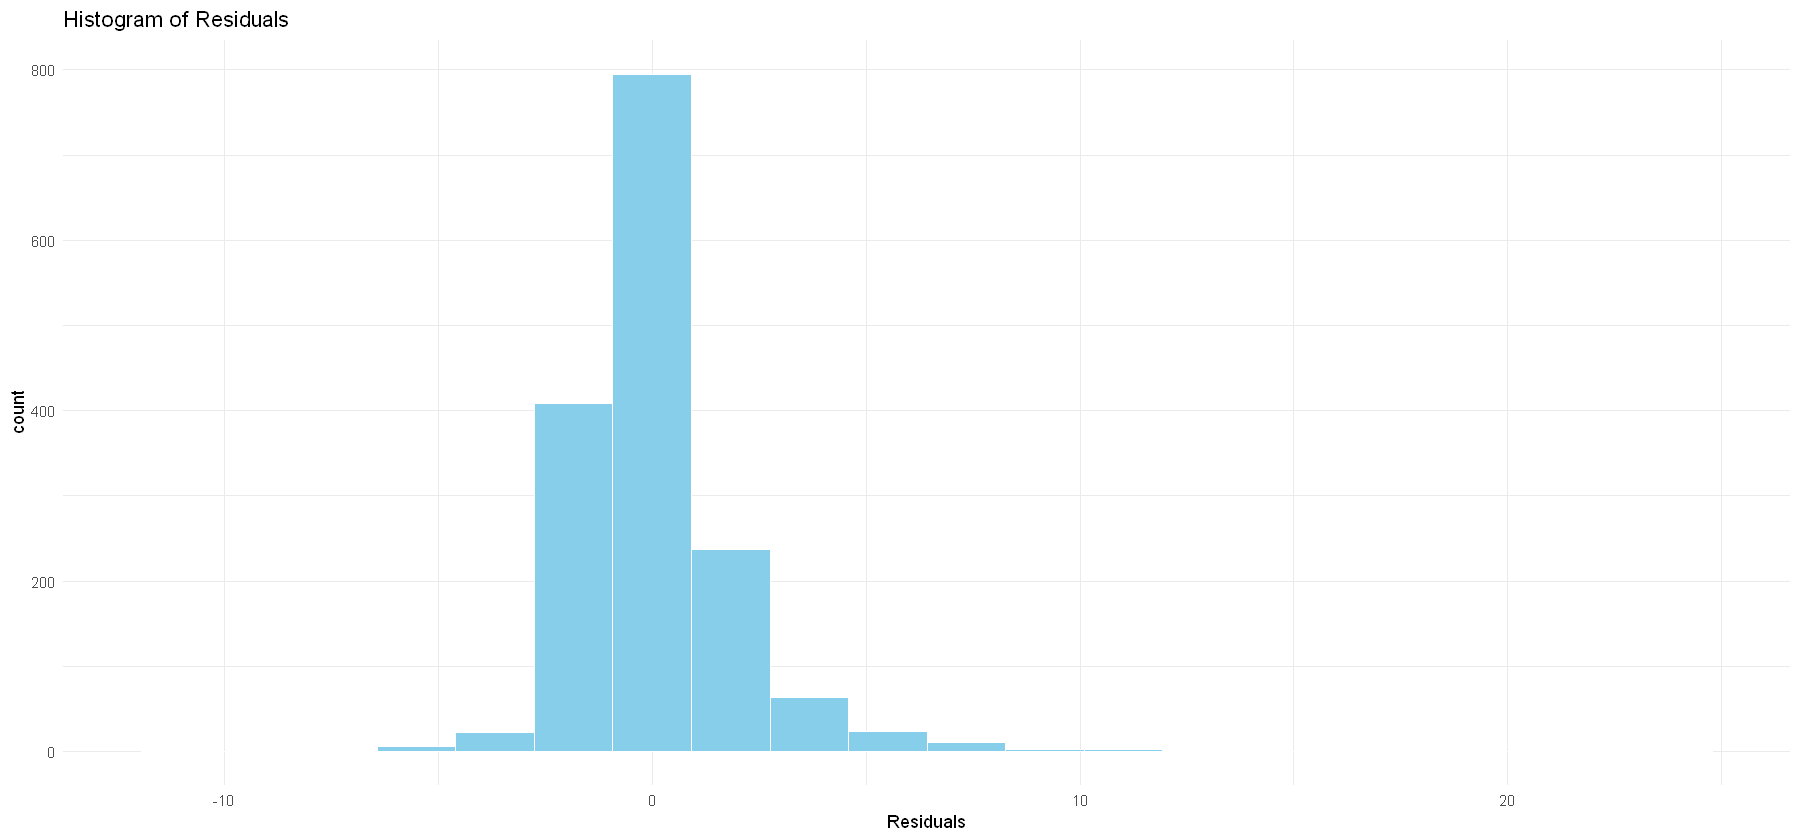

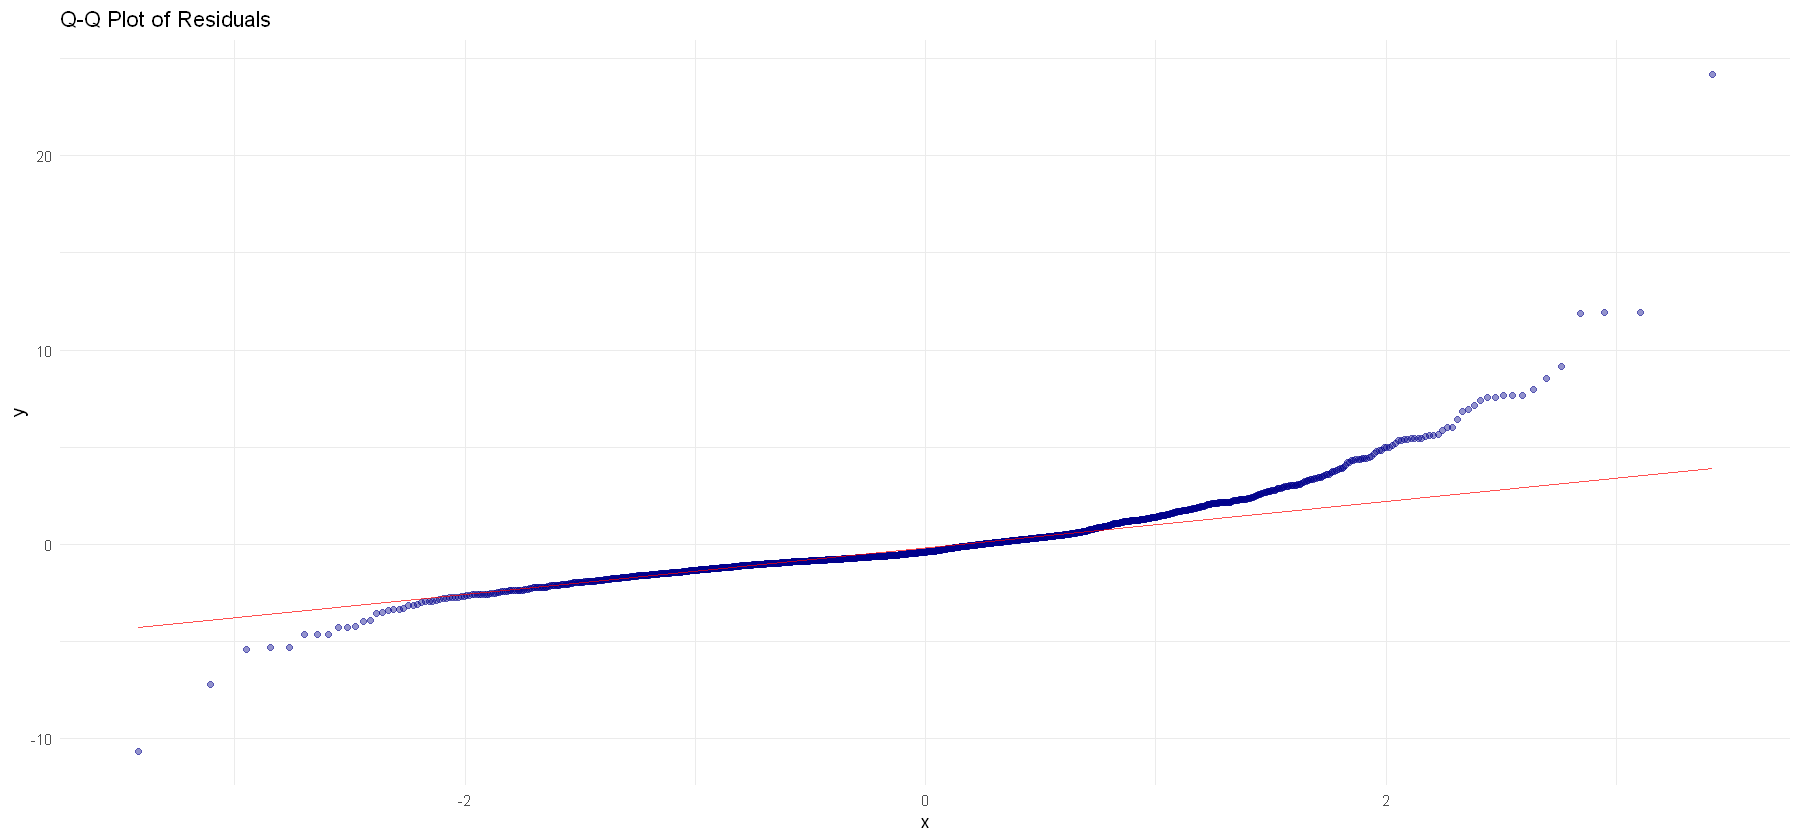

In [149]:
# 1. Linearity
# Check for linearity by plotting the observed values against the predicted values
linearity_plot <- ggplot(data = test_data, aes(x = test_predictions, y = homicide_con)) +
  geom_point(color = "steelblue", shape = 16) +
  labs(x = "Predicted", y = "Observed", title = "Linearity Check") +
  theme_minimal()

linearity_plot



# Combine test_predictions and residuals into a data frame
plot_data <- data.frame(Predicted = test_predictions, Residuals = resid(model))

# Plot the residuals against the predicted values
homoscedasticity_plot <- ggplot(data = plot_data, aes(x = Predicted, y = Residuals)) +
  geom_point(color = "darkgreen", shape = 16) +
  labs(x = "Predicted", y = "Residuals", title = "Homoscedasticity Check") +
  theme_minimal()
  
homoscedasticity_plot


# 3. Normality of Residuals
residuals_hist <- ggplot(data = data.frame(Residuals = resid(model)), aes(x = Residuals)) +
  geom_histogram(fill = "skyblue", color = "white", bins = 20) +
  labs(title = "Histogram of Residuals") +
  theme_minimal()

residuals_hist

# Normality of Residuals - Q-Q Plot
residuals_qq <- ggplot(data = data.frame(Residuals = resid(model)), aes(sample = Residuals)) +
  geom_qq(color = "#00008b6d") +
  geom_qq_line(color = "#ff0000ae") +
  labs(title = "Q-Q Plot of Residuals") +
  theme_minimal()

residuals_qq

In [150]:

# Make predictions using the model
predictions <- predict(model, newdata = test_data)

# Evaluate the model's performance

# Calculate Mean Squared Error (MSE)
mse <- mean((df$homicide_con  - predictions)^2, na.rm = TRUE)

# Calculate Root Mean Squared Error (RMSE)
rmse <- sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae <- mean(abs(df$homicide_con  - predictions), na.rm = TRUE)

# Print the evaluation metrics
cat("MAE:", mae, "\n")
cat("MSE:", mse, "\n")
cat("RMSE:", rmse, "\n")

MAE: 2.244996 
MSE: 16.14947 
RMSE: 4.01864 


In [151]:

# Assuming 'test_data' is the validation dataset with the same structure as 'train_data'

# Make predictions on the validation data
predictions <- predict(model, newdata = test_data)


# Define a function to calculate accuracy metrics
accuracy <- function(actual, predicted) {
  
  # Calculate Mean Squared Error (MSE)
  mse <- mean((actual - predicted)^2)
  
  # Calculate Root Mean Squared Error (RMSE)
  rmse <- sqrt(mse)
  
  # Calculate Mean Absolute Error (MAE)
  mae <- mean(abs(actual - predicted))

  # accuracy <- sum(actual == predicted) / length(actual)
  
  # Print the evaluation metrics
  cat("MSE:", mse, "\n")
  cat("RMSE:", rmse, "\n")
  cat("MAE:", mae, "\n")
  # cat("Accuracy:", accuracy, "\n")
  
  # Return a list of metrics
  return(list(mse = mse, rmse = rmse, mae = mae))
}


# Calculate accuracy metrics for the predictions
accuracy_metrics <- accuracy(test_data$homicide_con, predictions)

# Access individual metrics using the names of the list elements
mse <- accuracy_metrics$mse
rmse <- accuracy_metrics$rmse
mae <- accuracy_metrics$mae
# accuracy <- accuracy_metrics$acc

MSE: 4.157361 
RMSE: 2.038961 
MAE: 1.318181 


In [152]:

# Make predictions on the validation data
predictions <- predict(model, newdata = test_data)

# Define a function to calculate accuracy metrics
accuracy <- function(actual, predicted) {
  # Calculate Mean Squared Error (MSE)
  mse <- mean((actual - predicted)^2)
  
  # Calculate Root Mean Squared Error (RMSE)
  rmse <- sqrt(mse)
  
  # Calculate Mean Absolute Error (MAE)
  mae <- mean(abs(actual - predicted))
  
  # Print the evaluation metrics
  cat("MSE:", mse, "\n")
  cat("RMSE:", rmse, "\n")
  cat("MAE:", mae, "\n")
  
  # Return a list of metrics
  return(list(mse = mse, rmse = rmse, mae = mae))
}

# Calculate accuracy metrics for the predictions
accuracy_metrics <- accuracy(test_data$homicide_con, predictions)

# Access individual metrics using the names of the list elements
mse <- accuracy_metrics$mse
rmse <- accuracy_metrics$rmse
mae <- accuracy_metrics$mae

MSE: 4.157361 
RMSE: 2.038961 
MAE: 1.318181 


# Clustering

In [153]:
df_clus <- df_convictions[c(7:18)]  

df_norm <- scale(df_clus)


# Set the number of clusters you want to create
k <- 3

# Apply K-means clustering
kmeans_result <- kmeans(df_norm, centers = k)

# # Print the cluster assignments
# print(kmeans_result$cluster)


# Access cluster centroids
centroids <- kmeans_result$centers
print(centroids)

# Access within-cluster sum of squares
within_cluster_sum_of_squares <- kmeans_result$tot.withinss
print(within_cluster_sum_of_squares)


  homicide_con offences_against_the_person_con sexual_offences_con burglary_con
1    0.4103166                       0.5757899           0.6911822    0.6167456
2    4.4887224                       5.3274750           4.6530055    5.2098162
3   -0.2723132                      -0.3510154          -0.3655595   -0.3600765
  robbery_con theft_and_handling_con fraud_and_forgery_con criminal_damage_con
1   0.3832479              0.7298641             0.2114201           0.7049382
2   5.2973096              4.7549572             5.9467239           4.9230657
3  -0.2897333             -0.3809426            -0.2567077          -0.3785189
  drugs_offences_con public_order_offences_con all_other_offences_con
1          0.2804977                 0.6092544              0.4258029
2          6.0041202                 5.1364608              4.5380710
3         -0.2801854                -0.3553802             -0.2787451
  motoring_offences_con
1             0.5373437
2             5.1511077
3           

Silhouette Score: The silhouette score measures the coherence and separation of clusters. It ranges from -1 to 1, where a higher score indicates better clustering results. You can calculate the silhouette score using the silhouette() function in R. Here's an example:

In [154]:
# Convert cluster assignments to integers
cluster_assignments <- as.integer(kmeans_result$cluster)

# Calculate the silhouette score
silhouette_score <- silhouette(cluster_assignments, dist(df_norm))
# print(silhouette_score)

Within-Cluster Sum of Squares (WCSS): WCSS measures the compactness of clusters by summing the squared distances between each data point and its cluster centroid. A lower WCSS indicates tighter and more well-defined clusters. You can access the WCSS value directly from the kmeans_result$tot.withinss as mentioned earlier.
R


In [155]:
# Access within-cluster sum of squares
within_cluster_sum_of_squares <- kmeans_result$tot.withinss

# Print the within-cluster sum of squares
print(within_cluster_sum_of_squares)

[1] 5601.581


Interpreting the clusters:

In [156]:
# By examining the contingency table, you can identify which principal offence categories are more prevalent in each cluster and observe any patterns or similarities among the categories within each cluster.

# Remember to adapt the code to your specific variable names and data structures. Feel free to explore additional visualization techniques, such as bar plots or heatmaps, to aid in the interpretation of the clusters and the distribution of principal offence categories within each cluster.

,homicide_con,offences_against_the_person_con,sexual_offences_con,burglary_con,robbery_con,theft_and_handling_con,fraud_and_forgery_con,criminal_damage_con,drugs_offences_con,public_order_offences_con,all_other_offences_con,motoring_offences_con
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.4103166,0.5757899,0.6911822,0.6167456,0.3832479,0.7298641,0.2114201,0.7049382,0.2804977,0.6092544,0.4258029,0.5373437
2,4.4887224,5.3274750,4.6530055,5.2098162,5.2973096,4.7549572,5.9467239,4.9230657,6.0041202,5.1364608,4.5380710,5.1511077
3,-0.2723132,-0.3510154,-0.3655595,-0.3600765,-0.2897333,-0.3809426,-0.2567077,-0.3785189,-0.2801854,-0.3553802,-0.2787451,-0.3333225


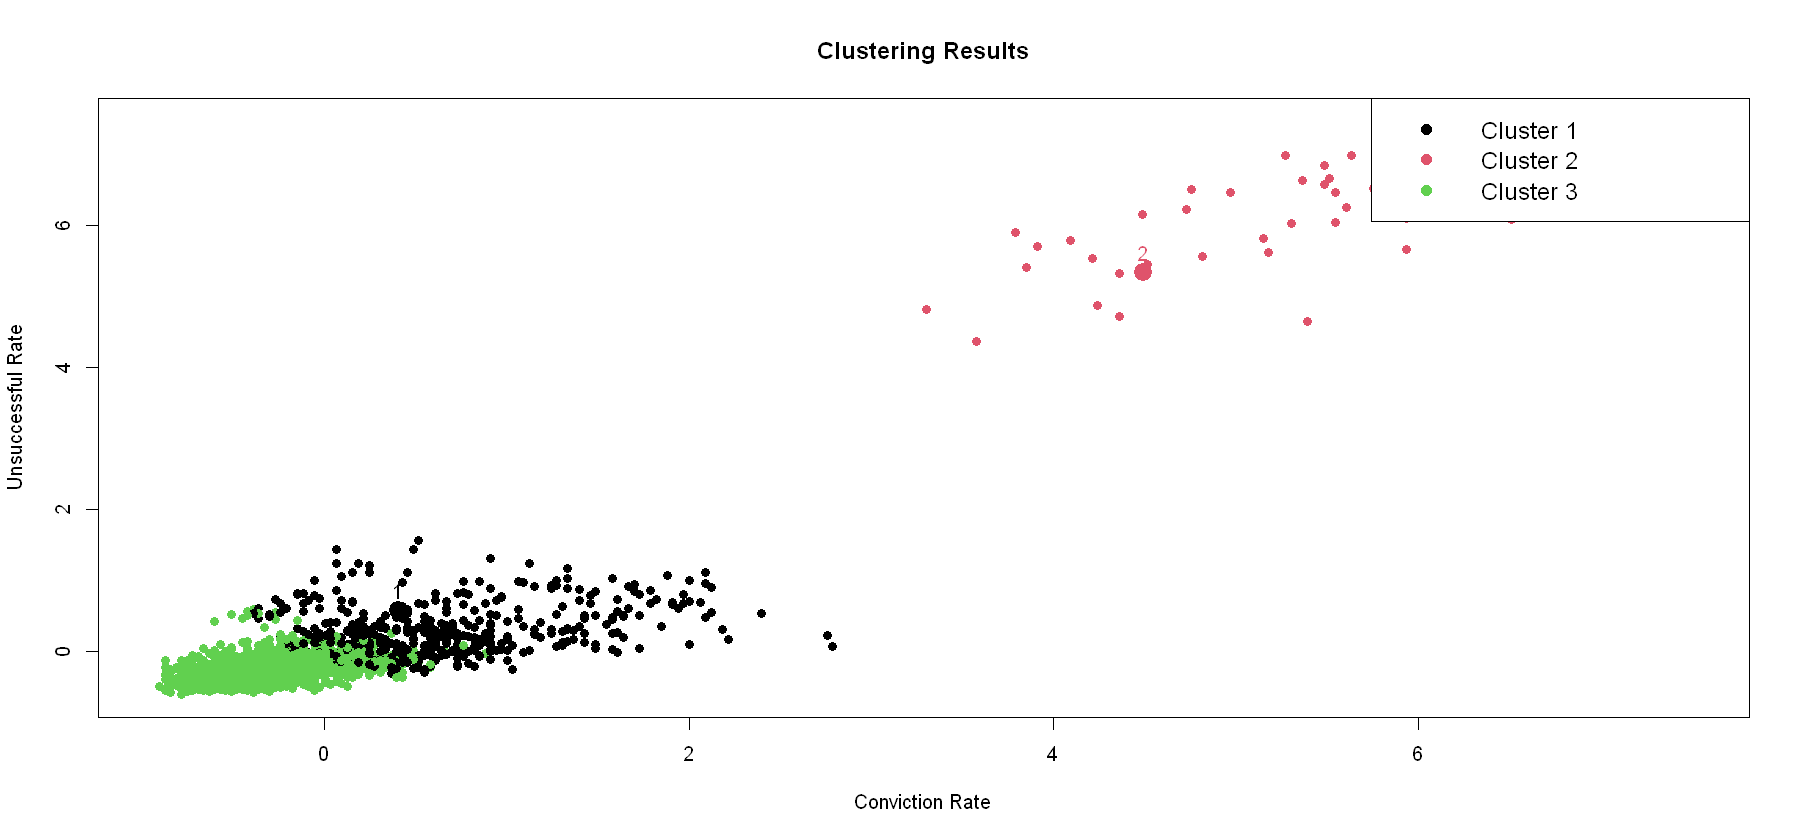

In [157]:
# Create a data frame with the cluster centroids
centroids_df <- data.frame(centroids)
centroids_df

# Plot the scatter plot
plot(df_norm[, 4], df_norm[, 9], col = kmeans_result$cluster, pch = 16,
     xlab = "Conviction Rate", ylab = "Unsuccessful Rate", main = "Clustering Results")

# Add cluster centroids to the plot
points(centroids_df[, 1], centroids_df[, 2], col = 1:k, pch = 19, cex = 2)

# Add cluster labels to the plot
text(centroids_df[, 1], centroids_df[, 2], labels = 1:k, pos = 3, col = 1:k)

# Add legend
legend("topright", legend = paste("Cluster", 1:k), col = 1:k, pch = 19, cex = 1.2)

# Show the plot

In [158]:
# describe df_convictions
summary(df_convictions[7:18])

  homicide_con   offences_against_the_person_con sexual_offences_con
 Min.   : 0.00   Min.   :  29.0                  Min.   :  0.0      
 1st Qu.: 0.00   1st Qu.: 114.0                  1st Qu.:  7.0      
 Median : 1.00   Median : 175.0                  Median : 14.0      
 Mean   : 1.93   Mean   : 232.7                  Mean   : 22.4      
 3rd Qu.: 2.00   3rd Qu.: 265.0                  3rd Qu.: 28.0      
 Max.   :38.00   Max.   :1904.0                  Max.   :181.0      
  burglary_con     robbery_con     theft_and_handling_con fraud_and_forgery_con
 Min.   :  1.00   Min.   :  0.00   Min.   :  13.0         Min.   :  0.00       
 1st Qu.: 14.00   1st Qu.:  2.00   1st Qu.:  95.0         1st Qu.:  7.00       
 Median : 22.00   Median :  5.00   Median : 145.0         Median : 12.00       
 Mean   : 30.81   Mean   :  9.92   Mean   : 191.7         Mean   : 19.71       
 3rd Qu.: 36.00   3rd Qu.: 10.00   3rd Qu.: 231.0         3rd Qu.: 20.00       
 Max.   :278.00   Max.   :209.00   Ma

In [159]:
# Subset the data
subset_df <- df_convictions[7:18]

# Correlation Analysis
correlation_matrix <- cor(subset_df)

# Clustering Algorithm Selection (K-means)
library(cluster)

# Define the number of clusters
num_clusters <- 3

# Apply K-means clustering
kmeans_result <- kmeans(subset_df, centers = num_clusters)

# Cluster Evaluation (WCSS and Silhouette Score)
wcss <- sum(kmeans_result$withinss)
silhouette <- silhouette(kmeans_result$cluster, dist(subset_df))

# Print the evaluation metrics
print(paste("WCSS:", wcss))
print(paste("Silhouette Score:", mean(silhouette[, "sil_width"])))

# Cluster Interpretation
cluster_assignments <- kmeans_result$cluster

# Analyze each cluster
for (i in 1:num_clusters) {
  cluster_data <- subset_df[cluster_assignments == i, ]
  print(paste("Cluster", i))
  print(summary(cluster_data))
}

[1] "WCSS: 57336688.7393389"
[1] "Silhouette Score: 0.544540150446778"
[1] "Cluster 1"
  homicide_con   offences_against_the_person_con sexual_offences_con
 Min.   : 8.00   Min.   :1092                    Min.   : 94.0      
 1st Qu.:12.00   1st Qu.:1284                    1st Qu.:127.0      
 Median :14.50   Median :1402                    Median :139.0      
 Mean   :16.28   Mean   :1462                    Mean   :137.1      
 3rd Qu.:20.00   3rd Qu.:1679                    3rd Qu.:145.8      
 Max.   :38.00   Max.   :1904                    Max.   :181.0      
  burglary_con    robbery_con    theft_and_handling_con fraud_and_forgery_con
 Min.   :140.0   Min.   : 58.0   Min.   : 637.0         Min.   :166.0        
 1st Qu.:175.0   1st Qu.: 82.0   1st Qu.: 758.5         1st Qu.:188.5        
 Median :207.0   Median : 95.0   Median :1044.0         Median :212.5        
 Mean   :203.0   Mean   :108.1   Mean   :1018.5         Mean   :217.6        
 3rd Qu.:226.8   3rd Qu.:132.5   3rd Qu.

### Visualise cluster

Warning message:
"`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information."


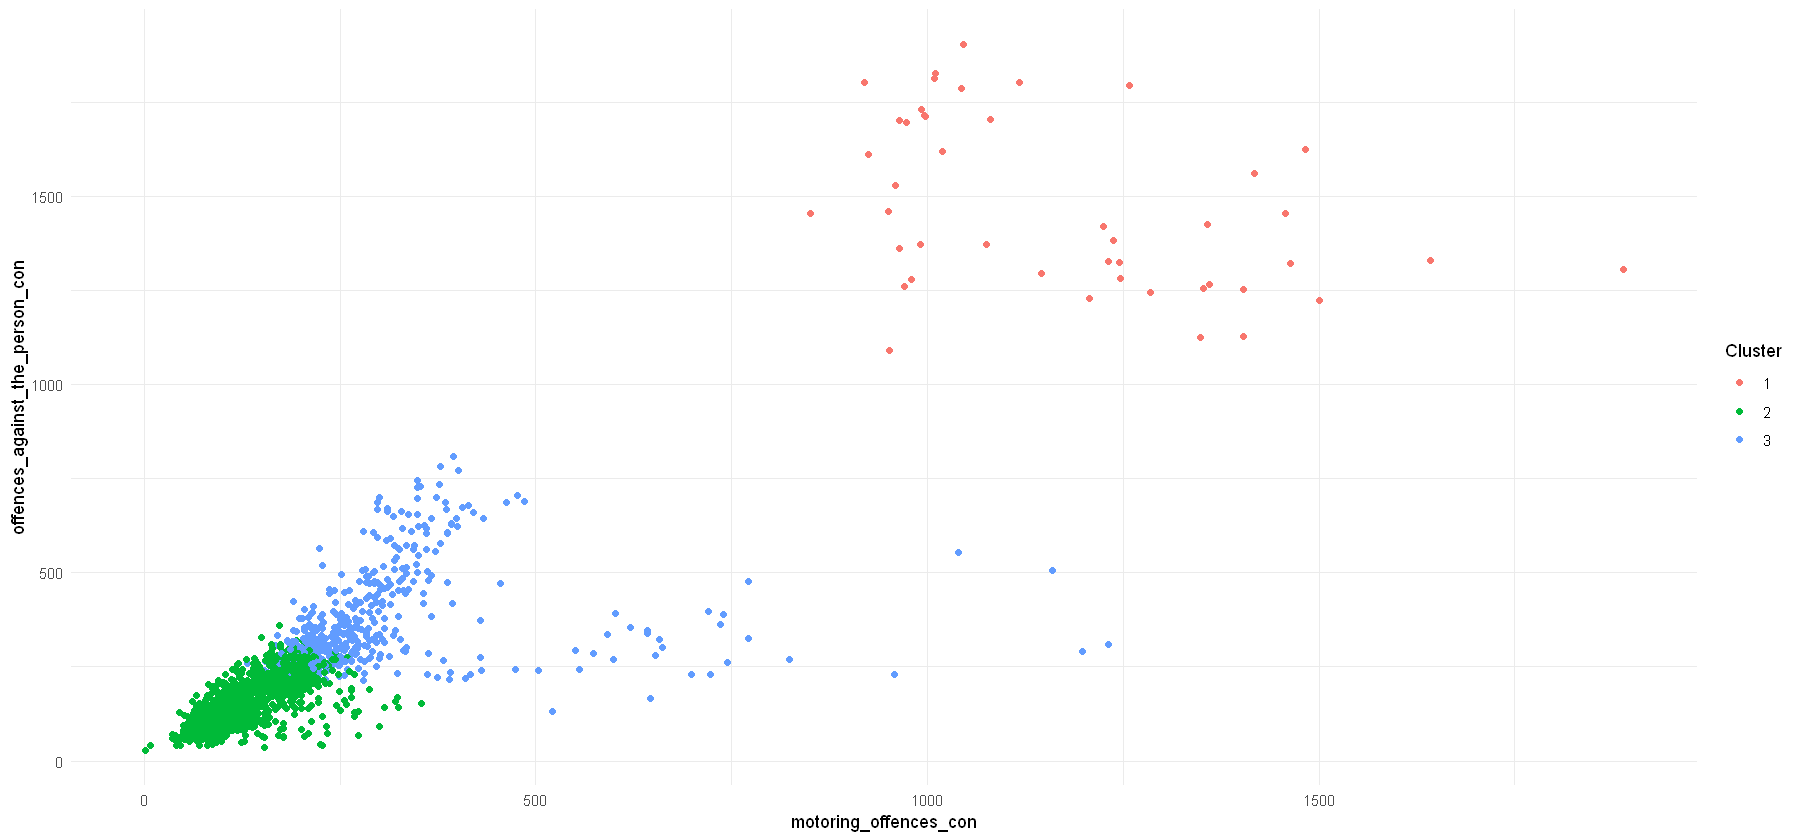

In [160]:
# Create a new data frame with the original data and cluster assignments
clustered_data <- cbind(df_convictions[7:18], cluster = cluster_assignments)





plot_cluster <- function(df, variable1, variable2) {
  # Scatter plot of two variables, colored by cluster
  ggplot(df, aes_string(x = variable1, y = variable2, color = "as.factor(cluster)")) +
    geom_point() +
    labs(x = variable1, y = variable2, color = "Cluster") +
    theme_minimal()
}


variable1 <- "motoring_offences_con"
variable2 <- "offences_against_the_person_con"
plot_cluster(clustered_data, variable1, variable2)

drugs_offences_con and fraud_and_forgery_con

In [161]:
# variable1 <- "drugs_offences_con"
# variable2 <- "fraud_and_forgery_con"
# plot_cluster(clustered_data, variable1, variable2)

### cluster profiling

In [162]:
# Create a new data frame with the original data and cluster assignments
clustered_data <- cbind(df_convictions[7:18], cluster = cluster_assignments)

# Convert variables to numeric if needed
clustered_data <- clustered_data %>%
  mutate_if(is.character, as.numeric)

# Calculate summary statistics for each variable within each cluster
summary_stats <- clustered_data %>%
  group_by(cluster) %>%
  summarise(
    mean_homicide_con = mean(homicide_con, na.rm = TRUE),
    median_homicide_con = median(homicide_con, na.rm = TRUE),
    mean_offences_person_con = mean(offences_against_the_person_con, na.rm = TRUE),
    median_offences_person_con = median(offences_against_the_person_con, na.rm = TRUE),
    # Add more variables as needed
  )

# Print the summary statistics for each cluster
print(summary_stats)

# A tibble: 3 × 5
  cluster mean_homicide_con median_homicide_con mean_offences_person_con
    <int>             <dbl>               <dbl>                    <dbl>
1       1             16.3                 14.5                    1462.
2       2              1.16                 1                       151.
3       3              2.93                 2                       369.
# ℹ 1 more variable: median_offences_person_con <dbl>


In [163]:
str(df_rates_convictions)

'data.frame':	2100 obs. of  18 variables:
 $ county_areas                        : chr  "Avon and Somerset" "Bedfordshire" "Cambridgeshire" "Cheshire" ...
 $ region                              : chr  "South West" "Thames and Chiltern" "East of England" "Mersey-Cheshire" ...
 $ date                                : chr  "2014-01-01" "2014-01-01" "2014-01-01" "2014-01-01" ...
 $ month                               : chr  "Jan" "Jan" "Jan" "Jan" ...
 $ year                                : int  2014 2014 2014 2014 2014 2014 2014 2014 2014 2014 ...
 $ quarter                             : chr  "Q1_2014" "Q1_2014" "Q1_2014" "Q1_2014" ...
 $ rate_homicide_con                   : num  0 0 0 0 40 0 0 0 0 100 ...
 $ rate_offences_against_the_person_con: num  78.6 70.1 82.8 81 73 89.7 69.9 77.5 75 78.4 ...
 $ rate_sexual_offences_con            : num  67.3 66.7 76.9 93.8 64.7 57.1 75.9 84.2 46.2 75 ...
 $ rate_burglary_con                   : num  98 63.6 81.8 88.4 94.7 100 90 86.2 95.2 87.5 ..

## Classification

In [164]:

df_rates_convictions$rate_level <- ifelse(df_rates_convictions$rate_offences_against_the_person_con >= 85.0, "high", ifelse(df_rates_convictions$rate_offences_against_the_person_con >= 75.0, "medium", "low"))

# df_rates_convictions

In [165]:
# set the threshold
threshold_cl <- 75.0

df <- df_rates_convictions

df$rate_level <- ifelse(df$rate_offences_against_the_person_con >= 85.0, "high", ifelse(df$rate_offences_against_the_person_con >= 75.0, "medium", "low"))


#### Convert Categorical Variable to factor 

In [166]:

df$rate_level <- factor(df$rate_level, levels = c("high", "medium", "low"))




#### split dataset

In [167]:
set.seed(123)
train_indices <- createDataPartition(df$rate_level, p = 0.7, list = FALSE)
train_data <- df[train_indices, ]
test_data <- df[-train_indices, ]


# Check the dimensions of the training and testing sets
dim(train_data)
dim(test_data)

[1] 1472   19

[1] 628  19

This step uses the multinom function from the nnet package to train a multinomial logistic regression model.
The formula rate_level ~ . specifies that the variable rate_level is the target variable, and . indicates that all other variables in the train_data dataset are used as predictors.

In [168]:
# Train the multinomial logistic regression model
multinomial_model <- multinom(rate_level ~ ., data = train_data)

# weights:  435 (288 variable)


initial  value 1617.157289 
iter  10 value 822.107779
iter  20 value 672.308911
iter  30 value 578.935384
iter  40 value 326.699461
iter  50 value 129.034967
iter  60 value 11.516860
iter  70 value 0.043706
final  value 0.000040 
converged


### Predict on the testing set:
This step uses the trained multinomial_model to predict the classes for the testing set (test_data).
The predict function generates predicted class labels based on the fitted model and the new data.

In [169]:
# Predict on the testing set
predictions <- predict(multinomial_model, newdata = test_data)


### Convert the predicted values to a factor with the same levels as the reference variable
 
Since we want to compare the predicted values (predictions) with the actual values (test_data$rate_level) in the confusion matrix, we need to ensure they have the same levels.
This step converts the predictions to a factor and assigns the levels from test_data$rate_level to ensure consistency in the levels of the two variables.

In [170]:
# Convert the predicted values to a factor with the same levels as the reference variable
predictions <- factor(predictions, levels = levels(test_data$rate_level))


### Generate the confusion matrix
This step uses the confusionMatrix function from the caret package to create a confusion matrix.
The confusionMatrix function takes the predicted values (predictions) and the reference values (test_data$rate_level) and calculates various metrics such as accuracy, precision, recall, and F1 score.

In [171]:

# Generate the confusion matrix
confusion_matrix <- confusionMatrix(predictions, test_data$rate_level)
print(confusion_matrix)

Confusion Matrix and Statistics

          Reference
Prediction high medium low
    high     78      7   4
    medium    3    400  12
    low       0      9 115

Overall Statistics
                                          
               Accuracy : 0.9443          
                 95% CI : (0.9233, 0.9609)
    No Information Rate : 0.6624          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8892          
                                          
 Mcnemar's Test P-Value : 0.1102          

Statistics by Class:

                     Class: high Class: medium Class: low
Sensitivity               0.9630        0.9615     0.8779
Specificity               0.9799        0.9292     0.9819
Pos Pred Value            0.8764        0.9639     0.9274
Neg Pred Value            0.9944        0.9249     0.9683
Prevalence                0.1290        0.6624     0.2086
Detection Rate            0.1242        0.6369     0.1831
Det

### check accuracy

In [172]:
# Assess the model's performance
accuracy <- confusion_matrix$overall["Accuracy"]
precision <- confusion_matrix$byClass["Precision"]
recall <- confusion_matrix$byClass["Recall"]
f1_score <- confusion_matrix$byClass["F1"]

print(paste("Accuracy:", accuracy))

[1] "Accuracy: 0.944267515923567"


Warning message:
"package 'cowplot' was built under R version 4.3.1"

Attaching package: 'cowplot'


The following object is masked from 'package:lubridate':

    stamp




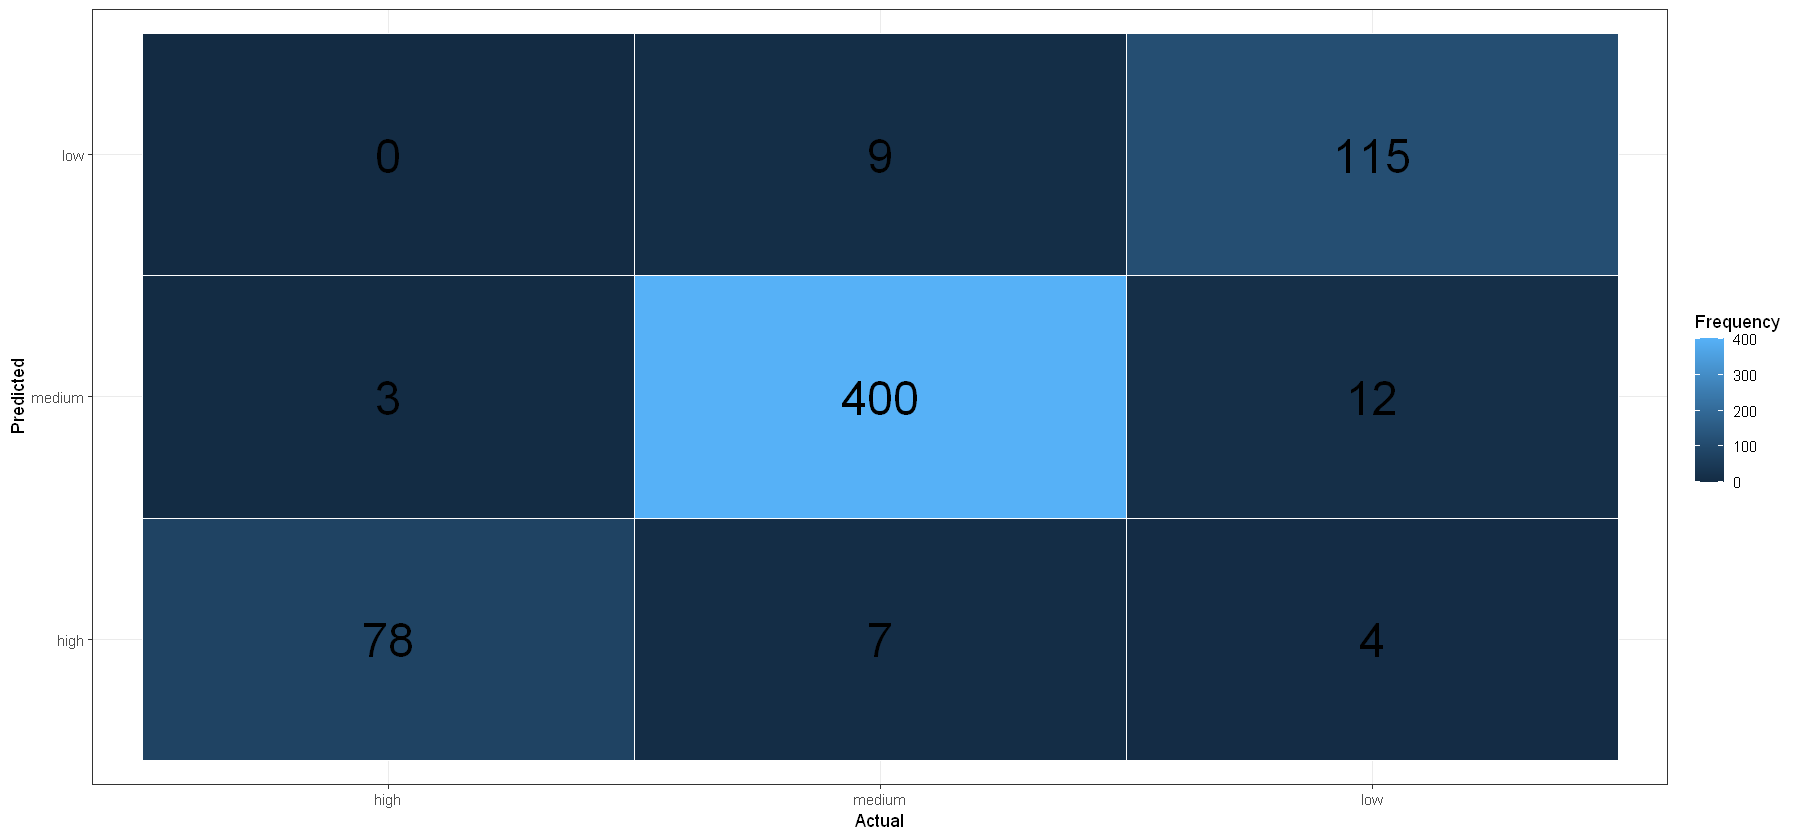

In [173]:
library(cowplot)

# Obtain the confusion matrix
confusion_matrix <- confusionMatrix(predictions, test_data$rate_level)

# Convert the confusion matrix to a data frame
cm_df <- as.data.frame(confusion_matrix$table)

# Create a confusion matrix plot
cm_plot <- ggplot(cm_df, aes(x = Reference, y = Prediction, fill = Freq)) +
  geom_tile(color = "white") +
  geom_text(aes(label = Freq), color = "black", size = 10) +
  theme_bw() +
  labs(x = "Actual", y = "Predicted", fill = "Frequency")

# Display the confusion matrix plot
plot_grid(cm_plot, nrow = 1)